In [2]:
import tensorflow as tf
import numpy as np 
from matplotlib import pyplot as plt
import seaborn as sns
from time import time
from sklearn.decomposition import PCA

## Loading Data ##

Loading the MNIST datasets. Splitting it up in Training & Test.

In [ ]:
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()

## Pre-Processing Data

* ### Normalization

Since PCA is wanted, standardization is necessary so that data has mean equal to zero. This way, the covariance matrix becomes effectively the correlation matrix as seen in PCA theory.

In [ ]:
x_train_norm = x_train/255.0*2 - 1
x_test_norm = x_test/255.0*2 - 1

x_train = x_train_norm.reshape((x_train_norm.shape[0], -1)).astype(np.float32)
x_test  = x_test_norm.reshape((x_test_norm.shape[0], -1)).astype(np.float32)

In [ ]:
x_train.shape

(60000, 784)

* ### PCA

To cut computational time (it runs real slow on this PC), I'll try to eliminate as many axis as possible by cutting the least possible information.

In [ ]:
pca = PCA()

pca.fit(x_train)

U = pca.transform(x_train)
S = pca.explained_variance_
V = pca.components_

Using the explained variance to evaluate how many Principal Components we need to effectively describe the dataset.

In the plot below, for each Principal Component the Explained Variance is graphed.

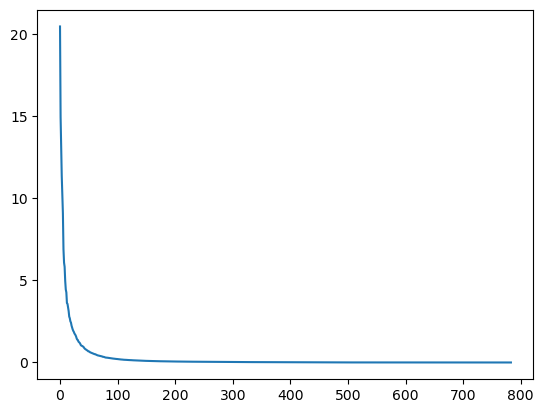

In [ ]:
plt.plot(pca.explained_variance_)

Choosing to keep 95% of the information. That is about the same as finding the elbow of the explained variance. 

In [ ]:
ev_cumsum = np.cumsum(pca.explained_variance_)/(pca.explained_variance_).sum() 
ev_at95 = ev_cumsum[ev_cumsum<0.95].shape[0]
print (ev_at95)

153


Instead of 784 coordinates, now we can safely keep track of just 153.

In [ ]:
pca = PCA(ev_at95)

x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)


## Functions

### Models

Let's build a function that creates a Neural Network with set parameters. In here, we will tweak activation functions, initializations of the parameters, deepness of the network and regularization.

In [ ]:
def get_regularizer(regularization_type, regularization_value):
    if regularization_type == 'l2':
        return tf.keras.regularizers.l2(regularization_value)
    elif regularization_type == 'l1':
        return tf.keras.regularizers.l1(regularization_value)
    return None


def create_dense_layer(units, activation, initializer, regularizer, name):
    return tf.keras.layers.Dense(
        units=units, activation=activation, kernel_initializer=initializer,
        kernel_regularizer=regularizer, bias_initializer=initializer,
        bias_regularizer=regularizer, name=name
    )

In [ ]:
input_shape = (28,28,1)

# CREATING FULLY CONNECTED NN
def make_MLPnet(input_shape=input_shape, input_shape, activation, predicter, initializer, name, n_hidden=1, units=1, regularization_type=None, regularization_value=0.0):
    """
    Builds a Multi-Layer Perceptron (MLP) model based on the provided configuration.

    Parameters
    ----------
    input_shape : tuple
        The shape of the input data.
    activation : str
        The activation function to use for the hidden layers (e.g., 'relu', 'tanh').
    predicter : str
        The activation function to use for the output layer.
    initializer : str
        The initializer to use for kernel and bias (e.g., 'he_normal', 'glorot_uniform').
    layers_name : str
        The base name for the layers in the model.
    n_hidden : int, optional
        The number of hidden layers in the model. Defaults to 1.
    units : int, optional
        The number of units in each hidden layer. Defaults to 1.
    regularization_type : str, optional
        The type of regularization to apply ('l1', 'l2', etc.). Defaults to None.
    regularization_value : float, optional
        The regularization value to apply if regularization is used. Defaults to 0.0.

    Returns
    -------
    tf.keras.Model
        A TensorFlow Keras Sequential model configured as a MLP based on the provided parameters.

    """
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Input(input_shape, name='Input'))
    model.add(tf.keras.layers.Flatten(name=name))

    
    regularizer = get_regularizer(regularization_type, regularization_value)
    for i in range(n_hidden):
        model.add(create_dense_layer(units, activation, initializer, regularizer, f"{name}{i+1}"))
    
    model.add(create_dense_layer(10, predicter, initializer, regularizer, f"{name}{n_hidden+1}"))

    return model

    
# CREATING CNN + MLP
def make_CNNnet(input_shape, activation, predicter, initializer, name, n_hidden=1, units=1, regularization_type=None, regularization_value=0.0):
    """
    Builds a Convolutional Neural Network (CNN) model followed by a Multi-Layer Perceptron (MLP) based on the provided configuration.

    Parameters
    ----------
    input_shape : tuple
        The shape of the input data.
    activation : str
        The activation function to use for the convolutional and hidden layers (e.g., 'relu', 'tanh').
    predicter : str
        The activation function to use for the output layer.
    initializer : str
        The initializer to use for kernel and bias (e.g., 'he_normal', 'glorot_uniform').
    layers_name : str
        The base name for the layers in the model.
    n_hidden : int, optional
        The number of hidden layers after the convolutional layers. Defaults to 1.
    units : int, optional
        The number of units in each hidden layer. Defaults to 1.
    regularization_type : str, optional
        The type of regularization to apply ('l1', 'l2', etc.). Defaults to None.
    regularization_value : float, optional
        The regularization value to apply if regularization is used. Defaults to 0.0.

    Returns
    -------
    tf.keras.Model
        A TensorFlow Keras Sequential model configured as a CNN followed by an MLP based on the provided parameters.

    """
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Input(input_shape, name='Input'))

    regularizer = get_regularizer(regularization_type, regularization_value)
    for i in range(1, 5):
        model.add(tf.keras.layers.Convolution2D(
            36, (3, 3), activation=activation, kernel_initializer=initializer,
            kernel_regularizer=regularizer, bias_initializer=initializer,
            bias_regularizer=regularizer, name=f'Convo{i}', padding='same'
        ))
        if i % 2 == 0:
            model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name=f'Pool{i//2}'))
    
    for i in range(n_hidden):
        model.add(create_dense_layer(units, activation, initializer, regularizer, f"{name}{i+1}"))
    
    model.add(create_dense_layer(10, predicter, initializer, regularizer, f"{name}{n_hidden+1}"))

    return model

Here's the function that builds the exact same network from the paper. 
Since the network used varied based on the analyzed problem (Large Parameters Regime & Many Layers Regime), a function parameter "issue" is added, so that the problem at hand can be chosen.

In [ ]:
def paper_net(input_shape, issue, activation, predicter, initializer, name, regularization_type=None, regularization_value=0.0):
    """
    Builds a convolutional neural network model based on the provided configuration. 

    Parameters
    ----------
    input_shape : tuple
        The shape of the input data.
    issue : str
        Specifies the configuration type: 'parameters' for parameter-heavy layers or 'layers' for layer-heavy configuration.
    activation : str
        The activation function to use for the convolutional and dense layers (e.g., 'relu', 'tanh').
    predicter : str
        The activation function to use for the output layer.
    initializer : str
        The initializer to use for kernel and bias (e.g., 'he_normal', 'glorot_uniform').
    name : str
        The base name for the layers in the model.
    regularization_type : str, optional
        The type of regularization to apply ('l1', 'l2', etc.). Defaults to None.
    regularization_value : float, optional
        The regularization value to apply if regularization is used. Defaults to 0.0.

    Returns
    -------
    tf.keras.Model
        A TensorFlow Keras Sequential model configured based on the provided parameters.

    """
    regularizer = get_regularizer(regularization_type, regularization_value)

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(input_shape, name = 'Input')) 

    if issue == 'parameters':
        for i in range(1, 7):
          model.add(tf.keras.layers.Convolution2D(
              36, (3, 3), activation=activation, kernel_initializer=initializer,
              kernel_regularizer=regularizer, bias_initializer=initializer,
              bias_regularizer=regularizer, name=f'Convo{i}', padding='same'
              ))
          if i % 2 == 0:
              model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name=f'Pool{i//2}'))

        model.add(tf.keras.layers.Flatten(name = name+str(0))) #From here on is FFNN    
        model.add(create_dense_layer(8, activation, initializer, regularizer, f"{name}1"))
        model.add(create_dense_layer(10, predicter, initializer, regularizer, f"{name}2"))

    if issue == 'layers':
        for i in range(1, 7):
           model.add(tf.keras.layers.Convolution2D(
               3, (3, 3), activation=activation, kernel_initializer=initializer,
               kernel_regularizer=regularizer, bias_initializer=initializer,
               bias_regularizer=regularizer, name=f'Convo{i}', padding='same'
               ))
           if i % 3 == 0:
             model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name=f'Pool{i//2}'))
        
        model.add(tf.keras.layers.Flatten(name = name+str(0))) #Da qui è una FFNN
        
        for i in range(4):
            model.add(create_dense_layer(8, activation, initializer, regularizer, f"{name}{i+1}"))
        model.add(create_dense_layer(10, activation=predicter, initializer=initializer, regularizer=regularizer, name=f"{name}5"))
    
    return model


### Training ###

In order to record the way weights change during the learning process, we must be able to record the gradients' components at each epoch.

To do that, we must have fine control of the training process. We do that by using the "Train Model" function below, rather than using the model.fit() function.

***Added note:*** Actually it could be done using CallBacks, which would have allowed to use the optimised fit() method of Keras' models. At the time of working on this project, however, this concept was not familiar to me.

In [ ]:
def train_model(X_train, y_train, X_val, y_val, model, n_epochs, optimizer, loss, metric, batch_size):
    """
    Trains a TensorFlow model using a manual training loop, with support for gradient recording, loss tracking, 
    and accuracy evaluation on both training and validation datasets.

    Parameters
    ----------
    X_train : tf.Tensor
        The input training data.
    y_train : tf.Tensor
        The labels for the training data.
    X_val : tf.Tensor
        The input validation data.
    y_val : tf.Tensor
        The labels for the validation data.
    model : tf.keras.Model
        The TensorFlow Keras model to be trained.
    n_epochs : int
        The number of epochs to train the model.
    optimizer : tf.keras.optimizers.Optimizer
        The optimizer to use for training.
    loss : tf.keras.losses.Loss
        The loss function to use during training.
    metric : tf.keras.metrics.Metric
        The metric to evaluate model performance (e.g., accuracy).
    batch_size : int
        The size of the batches used during training and validation.

    Returns
    -------
    train_gradhistory : list of dict
        A history of gradients for each layer, recorded at the start and end of the training.
    train_losshistory : list of float
        A history of training loss values recorded at the start and end of the training.
    train_acchistory : list of float
        A history of training accuracy values recorded at the end of each epoch.
    val_losshistory : list of float
        A history of validation loss values recorded at the end of each epoch.
    val_acchistory : list of float
        A history of validation accuracy values recorded at the end of each epoch.
    timing : float
        The total time taken to complete the training process.

    """  
    from time import time
    
    #Define a secondary function to record weights
    def record_train(): 
        data = {}
        for g,w in zip(grads, model.trainable_weights):
            if '/kernel:' not in w.name:
                continue # skip bias
            name = w.name.split("/")[0]
            data[name] = g.numpy()
        train_gradhistory.append(data)
        train_losshistory.append(train_loss_value.numpy())
        
        
    @tf.function
    def train_step(x, y):
        with tf.GradientTape() as tape:
            y_pred = model(x, training=True)
            train_loss_value = loss(y, y_pred)
            train_loss_value += sum(model.losses)
        grads = tape.gradient(train_loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        metric.update_state(y, y_pred)
        return train_loss_value, grads
    

    @tf.function
    def val_step(x, y):
        y_pred = model(x, training=False)
        val_loss_value = loss(y, y_pred)
        metric.update_state(y, y_pred)
        return val_loss_value
    
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)) #Transform tensor (X,y) into a dataset made up of many rows (image + label)
    train_dataset = train_dataset.shuffle(buffer_size=10000).batch(batch_size)  #Shuffle dataset and batch consecutive rows together
    
    #Do the same thing for the validation dataset
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)) #Transform tensor (X,y) into a dataset made up of many rows (image + label)
    val_dataset = val_dataset.shuffle(buffer_size=1000).batch(batch_size) #Shuffle dataset and batch consecutive rows together
    
    
    train_gradhistory = []
    train_losshistory = []
    train_acchistory  = []
    
    val_losshistory = []
    val_acchistory = []
    
    start_time = time()
    for epoch in range(n_epochs):
        
        #Some logging
        print("\nStart of epoch %d" % (epoch,))
        
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset): #For each step, corresponding to a single batc
            # Open a GradientTape to record the operations run
            # during the forward pass, which enables auto-differentiation.
            train_loss_value, grads = train_step(x_batch_train, y_batch_train)
            
            # Log every 200 batches.
            if step % 200 == 0:
                print(
                    "Training loss (for one batch) at step %d: %.4f"
                    % (step, float(train_loss_value))
                )
                print("Seen so far: %d samples" % ((step + 1) * batch_size))
#
            if step == 0:
                record_train() #Record gradient, loss at the start of each epoch
    
        print("\nEnd of epoch %d" % (epoch,))
        
        # Display metrics at the end of each epoch.
        train_acc = metric.result()
        train_acchistory.append(train_acc)
        print("Training acc over epoch: %.4f" % (float(train_acc),))
        metric.reset_states() #Reset the metric value at the start of the epoch
        
        ##############VALIDATION EPOCH#############################
        print("\nStarting Validation of epoch %d" % (epoch,))
        for step, (x_batch_val, y_batch_val) in enumerate(val_dataset):
            val_loss_value = val_step(x_batch_val, y_batch_val)
            
            if step == 0:
                val_losshistory.append(val_loss_value.numpy())
                
        val_acc = metric.result()
        val_acchistory.append(val_acc)
        metric.reset_states()
        print("Validation acc: %.4f" % (float(val_acc),))
        
    # After all epochs, record again
    record_train()
    val_losshistory.append(val_loss_value.numpy())
    
    end_time = time()
    timing = end_time - start_time    
        
    
    return train_gradhistory, train_losshistory, train_acchistory, val_losshistory, val_acchistory, timing

### Plotting Gradients at each epoch

Now we can Plot the Gradients' statistics per epoch (mean and stddev)

In [ ]:
from sklearn.metrics import accuracy_score

def plot_accuracy_loss(train_accuracy, val_accuracy, train_loss, val_loss):
    """Plot the training/validation accuracy and loss"""
    fig, (ax_acc, ax_loss) = plt.subplots(1, 2, figsize=(15,5))
    ax_acc.xlabel = 'Epoch'
    ax_acc.ylabel = 'Accuracy'
    ax_acc.set_title("Training Accuracy vs Validation Accuracy")
    ax_acc.plot(np.arange(len(train_accuracy)), train_accuracy, label='Training Accuracy')
    ax_acc.plot(np.arange(len(train_accuracy)), val_accuracy, label='Validation Accuracy')  
    ax_acc.legend()
    
    ax_loss.xlabel = 'Epoch'
    ax_loss.ylabel = 'Loss'
    ax_loss.set_title("Training Loss vs Validation Loss")
    ax_loss.plot(np.arange(len(train_loss)), train_loss, label='Training Loss')
    ax_loss.plot(np.arange(len(train_loss)), val_loss, label='Validation Loss')  
    ax_loss.legend()
    
    plt.show()

            
    
    
def plot_gradient(gradhistory):
    """Plot gradient mean and sd across epochs"""
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    ax[0].set_title("Mean gradient")
    for key in gradhistory[0]:
        ax[0].plot(range(len(gradhistory)), [w[key].mean() for w in gradhistory], label=key)
    ax[0].legend()
    
    ax[1].set_title("S.D.")
    for key in gradhistory[0]:
        ax[1].semilogy(range(len(gradhistory)), [w[key].std() for w in gradhistory], label=key)
    ax[1].legend()
    
    
    
def plot_gradient_first_last(gradhistory, paper=False):
    """Plot the distribution of the first layer's and last layer's gradients
    
    Parameters
    ----------
    gradhistory : np.ndarray
        array with gradients' records.
    paper : bool
        change naming of layers in the plot to match the type of layers use in the paper model
    """
    first_layer_name = 'Convo1' if paper else 'Layer1'
    
    mu1 = '$\mu_{first}$ = '
    mu2 = '$\mu_{last}$ = '
    sigma1 = '$\sigma_{first}$ = '
    sigma2 = '$\sigma_{last}$ = '
    

    mean1 = str(np.mean(gradhistory[-1][first_layer_name]))
    stdev1 = str(np.std(gradhistory[-1][first_layer_name]))
    mean2 = str(np.mean(gradhistory[-1]['Layer2']))
    stdev2 = str(np.std(gradhistory[-1]['Layer2']))
    

    fig, ax = plt.subplots(1, 3, figsize=(20, 8))
    
    plt.subplot(1,3,1)
    if paper:

    ax = sns.distplot(gradhistory[-1][first_layer_name], color = 'brown', axlabel = 'Gradients', label = 'First Layer Gradients')
    sns.distplot(gradhistory[-1]['Layer2'], color = 'blue', axlabel = 'Gradients', label = 'Last Layer Gradients')
    ax.set_title("First&Last Layer Gradients")
    plt.text(0.9, 0.95, mu1+mean1, horizontalalignment='right', size='medium', color='black', transform = ax.transAxes)
    plt.text(0.9, 0.90, mu2+mean2, horizontalalignment='right', size='medium', color='black', transform = ax.transAxes)
    plt.text(0.9, 0.85, sigma1+stdev1, horizontalalignment='right', size='medium', color='black', transform = ax.transAxes)
    plt.text(0.9, 0.80, sigma2+stdev2, horizontalalignment='right', size='medium', color='black', transform = ax.transAxes)
    ax.legend(loc = "upper left")
    
    plt.subplot(1,3,2)
    ax = sns.distplot(gradhistory[-1][first_layer_name], color = 'brown', axlabel = 'Gradients', label = 'First Layer Gradients')    
    ax.set_title("Last Layer Gradients")
    plt.text(0.9, 0.95, mu1+mean1, horizontalalignment='right', size='medium', color='black', transform = ax.transAxes)
    plt.text(0.9, 0.90, sigma1+stdev1, horizontalalignment='right', size='medium', color='black', transform = ax.transAxes)
    ax.legend(loc = "upper left")
    
    plt.subplot(1,3,3)
    ax = sns.distplot(gradhistory[-1]['Layer2'], color = 'blue', axlabel = 'Gradients', label = 'Last Layer Gradients')
    ax.set_title("Last Layer Gradients")
    plt.text(0.9, 0.95, mu2+mean2, horizontalalignment='right', size='medium', color='black', transform = ax.transAxes)
    plt.text(0.9, 0.90, sigma2+stdev2, horizontalalignment='right', size='medium', color='black', transform = ax.transAxes)
    ax.legend(loc = "upper left")

## 1 - MLP Large Parameters Regime ##

### 1.1 - Initializations Comparison ($\sigma^2=1$ vs. $\sigma^2=10$)

Configuration:

* **Shallow FFNN:** to check that the large parameters is indipendent of how many layers the network has. 


* **Activation Functions:** $tanh$


* **Initialization:** 

    * $N(\omega, \mu = 0, \sigma^2 = 1)$ --> Not-Large Parameters Regime 
    * $N(\omega, \mu = 0, \sigma^2 = 10)$ --> Large Parameters Regime


* **Loss:** Unregularized Sparse Categorical Cross-Entropy (r = 0)


* **Learning Algorithm:** Adam --> so as to ensure the fastest convergence and isolate the issue of Large Parameters Regime.

The comparison shows that in the Large Parameter regime the learning process is hindered by the large values of the parameters. Indeed, the Training Accuracy improves very slowly compared to the optimized initialization and the plots of the gradients show that the first layer's gradient at the end of learning have the mean in zero but very low standard deviation, which means that all the gradient components in the first layer barely move, making the convergence of learning very slow.


In [ ]:
# Model input shape
input_shape = (28, 28, 1)

#Hyperparameters
epochs = 20
r = 0.0
batch_size = 32
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
loss= tf.keras.losses.SparseCategoricalCrossentropy()
metric = tf.keras.metrics.SparseCategoricalAccuracy()


model = make_MLPnet(input_shape=input_shape,
                    activation = 'tanh',
                    predicter = 'softmax', 
                    initializer = tf.keras.initializers.RandomNormal(0,10,seed=1), # THE OBJECT OF THIS COMPARISON
                    #initializer = tf.keras.initializers.GlorotUniform(seed = 1),
                    name = 'Layer', 
                    n_hidden=1, 
                    units = 8,
                    regularization_type='l2', 
                    regularization_value=r)

grad_history, loss_history, accuracy_history, val_loss_history, val_accuracy_history, time = train_model(x_train, y_train, x_test, y_test,  model, epochs, optimizer, loss, metric, batch_size)

model.save('Models/mnist_largeparams/model')

In [ ]:
# Model input shape
input_shape = (28, 28, 1)

#Hyperparameters
epochs = 20
r = 0.0
batch_size = 32
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
loss= tf.keras.losses.SparseCategoricalCrossentropy()
metric = tf.keras.metrics.SparseCategoricalAccuracy()


model2 = make_MLPnet(input_shape=input_shape, 
                     activation = 'tanh',
                     predicter = 'softmax', 
                     initializer = tf.keras.initializers.RandomNormal(0,1,seed=1), #THE OBJECT OF THIS COMPARISON
#                      initializer = tf.keras.initializers.GlorotUniform(seed = 1),
                     name = 'Layer', 
                     n_hidden=1, 
                     units =8,
                     regularization_type='l2', 
                     regularization_value=r)

grad_history2, loss_history2, accuracy_history2, val_loss_history2, val_accuracy_history2, time2 = train_model(x_train, y_train, x_test, y_test,  model2, epochs, optimizer, loss, metric, batch_size)
model.save('Models/mnist_largeparams/model2')

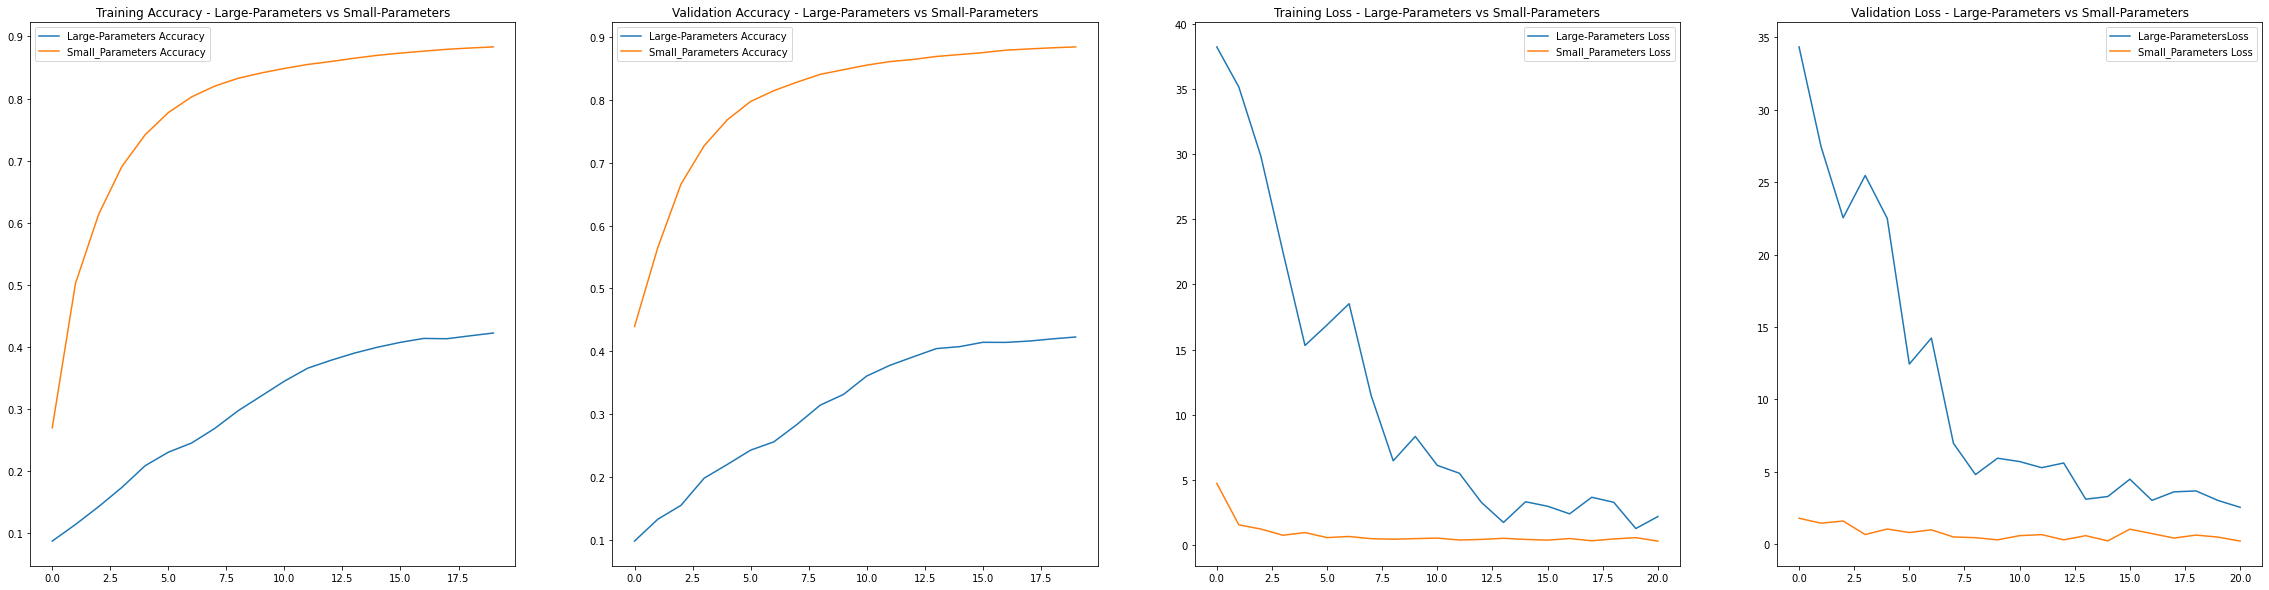

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(40,10))

ax[0].xlabel = 'Epoch'
ax[0].ylabel = 'Training Accuracy'
ax[0].set_title("Training Accuracy - Large-Parameters vs Small-Parameters")
ax[0].plot(np.arange(len(accuracy_history)), accuracy_history, label='Large-Parameters Accuracy')
ax[0].plot(np.arange(len(accuracy_history)), accuracy_history2, label='Small_Parameters Accuracy')  
ax[0].legend()

ax[1].xlabel = 'Epoch'
ax[1].ylabel = 'Validation Accuracy'
ax[1].set_title("Validation Accuracy - Large-Parameters vs Small-Parameters")
ax[1].plot(np.arange(len(val_accuracy_history)), val_accuracy_history, label='Large-Parameters Accuracy')
ax[1].plot(np.arange(len(val_accuracy_history)), val_accuracy_history2, label='Small_Parameters Accuracy')  
ax[1].legend()

ax[2].xlabel = 'Epoch'
ax[2].ylabel = 'Training Loss'
ax[2].set_title("Training Loss - Large-Parameters vs Small-Parameters")
ax[2].plot(np.arange(len(loss_history)), loss_history, label='Large-Parameters Loss')
ax[2].plot(np.arange(len(loss_history)), loss_history2, label='Small_Parameters Loss')  
ax[2].legend()

ax[3].xlabel = 'Epoch'
ax[3].ylabel = 'Validation Loss'
ax[3].set_title("Validation Loss - Large-Parameters vs Small-Parameters")
ax[3].plot(np.arange(len(val_loss_history)), val_loss_history, label='Large-ParametersLoss')
ax[3].plot(np.arange(len(val_loss_history)), val_loss_history2, label='Small_Parameters Loss')  
ax[3].legend()

plt.show()

/home/alboz/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/alboz/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/alboz/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level func

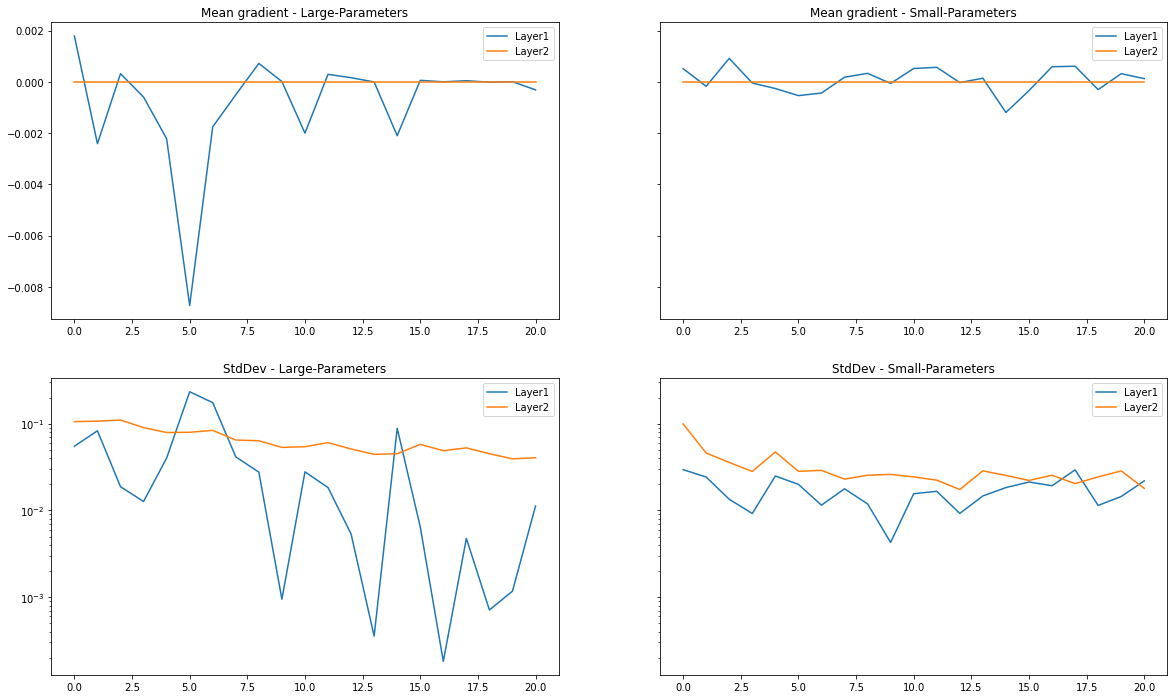

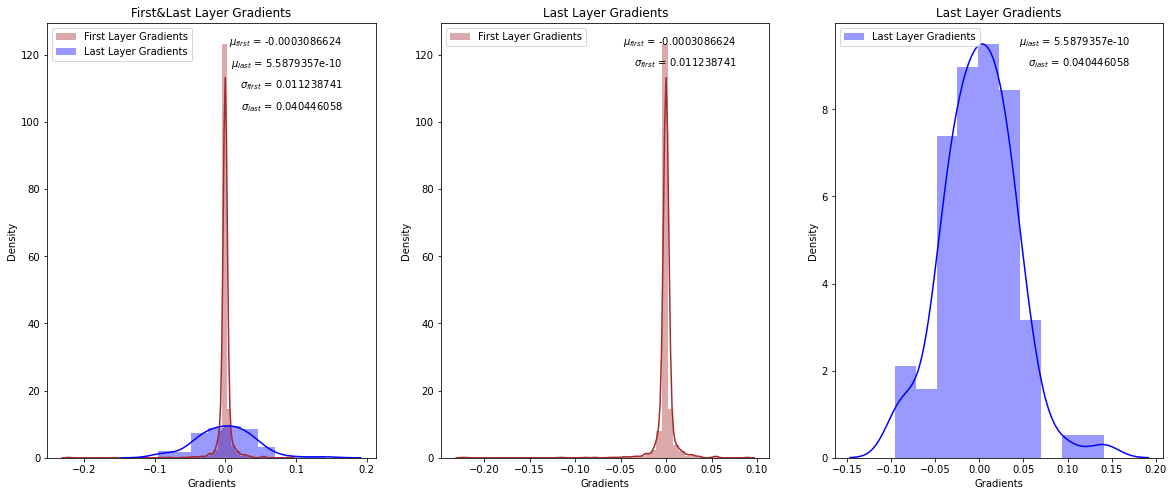

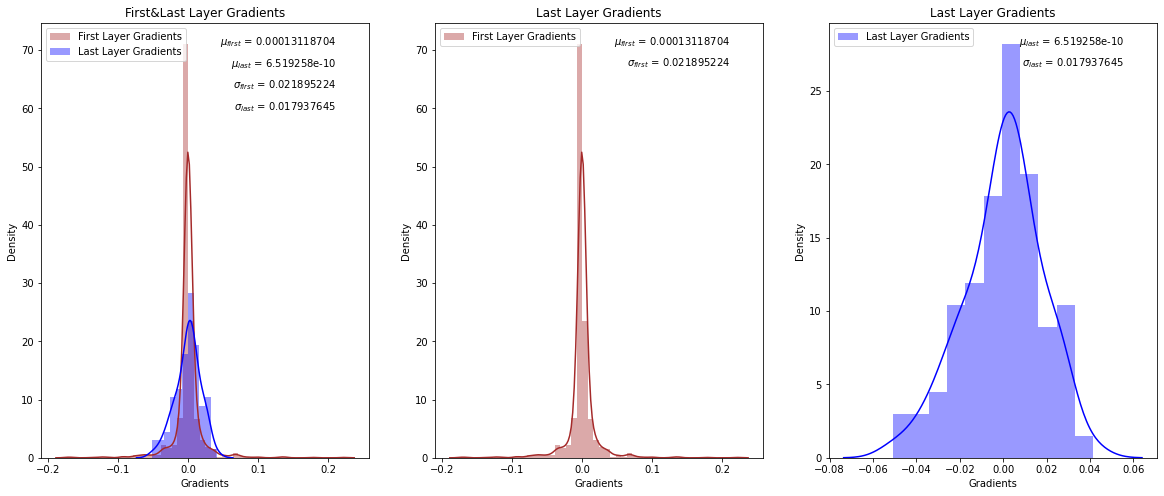

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(20, 12), sharey = "row")
    
ax[0,0].set_title("Mean gradient - Large-Parameters")
for key in grad_history[0]:
    ax[0,0].plot(range(len(grad_history)), [w[key].mean() for w in grad_history], label=key)
ax[0,0].legend()

ax[1,0].set_title("StdDev - Large-Parameters")
for key in grad_history[0]:
    ax[1,0].semilogy(range(len(grad_history)), [w[key].std() for w in grad_history], label=key)
ax[1,0].legend()

ax[0,1].set_title("Mean gradient - Small-Parameters")
for key in grad_history2[0]:
    ax[0,1].plot(range(len(grad_history2)), [w[key].mean() for w in grad_history2], label=key)
ax[0,1].legend()

ax[1,1].set_title("StdDev - Small-Parameters")
for key in grad_history2[0]:
    ax[1,1].semilogy(range(len(grad_history2)), [w[key].std() for w in grad_history2], label=key)
ax[1,1].legend()


#First Layer and Last Layer Gradients' Distribution at the end of the Learning Process

plot_gradient_first_last(grad_history)
plot_gradient_first_last(grad_history2)

### 1.2 - Adding Regularization

Configuration:

* **Shallow FFNN:** to check that the large parameters is indipendent of how many layers the network has. 


* **Activation Functions:** $tanh$


* **Initialization:** 

    * $N(\omega, \mu = 0, \sigma^2 = 10)$ --> Large Parameters Regime


* **Loss:** Sparse Categorical Cross-Entropy (r = 0)


* **Learning Algorithm:** Adam --> so as to ensure the fastest convergence and isolate the issue of Large Parameters Regime.

* **Regularization:** L2 (r=0.01)

Adding regularization to see how the results change when regularization is added. Does it perform better compared to the non regularized case?

L2-regularized model performs significantly better than the unregularized one, reaching in very few training epochs the performance of the optimized-initialization model. LASSO does not show the same efficacy, although it still provides a decent improvement over no regularization.


In [ ]:
# Model input shape
input_shape = (28, 28, 1)

#Hyperparameters
epochs = 20
r = 0.01
batch_size = 32
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
loss= tf.keras.losses.SparseCategoricalCrossentropy()
metric = tf.keras.metrics.SparseCategoricalAccuracy()


model = make_MLPnet(input_shape=input_shape, 
                    activation = 'tanh',
                    predicter = 'softmax', 
                    initializer = tf.keras.initializers.RandomNormal(0,10,seed=1),
                    #initializer = tf.keras.initializers.GlorotUniform(seed = 1),
                    name = 'Layer', 
                    n_hidden=1, 
                    units = 8,
                    regularization_type='l2', # OBJECT OF COMPARISON
                    regularization_value=r)

grad_history3, loss_history3, accuracy_history3, val_loss_history3, val_accuracy_history3, time3 = train_model(x_train, y_train, x_test, y_test,  model, epochs, optimizer, loss, metric, batch_size)

In [ ]:
# Model input shape
input_shape = (28, 28, 1)

#Hyperparameters
epochs = 20
r = 0.01
batch_size = 32
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
loss= tf.keras.losses.SparseCategoricalCrossentropy()
metric = tf.keras.metrics.SparseCategoricalAccuracy()


model = make_MLPnet(input_shape=input_shape, 
                    activation = 'tanh',
                    predicter = 'softmax', 
                    initializer = tf.keras.initializers.RandomNormal(0,10,seed=1),
                    #initializer = tf.keras.initializers.GlorotUniform(seed = 1),
                    name = 'Layer', 
                    n_hidden=1, 
                    units = 8,
                    regularization_type='l1', # OBJECT OF COMPARISON
                    regularization_value=r)

grad_history4, loss_history4, accuracy_history4, val_loss_history4, val_accuracy_history4, time4 = train_model(x_train, y_train, x_test, y_test,  model, epochs, optimizer, loss, metric, batch_size)

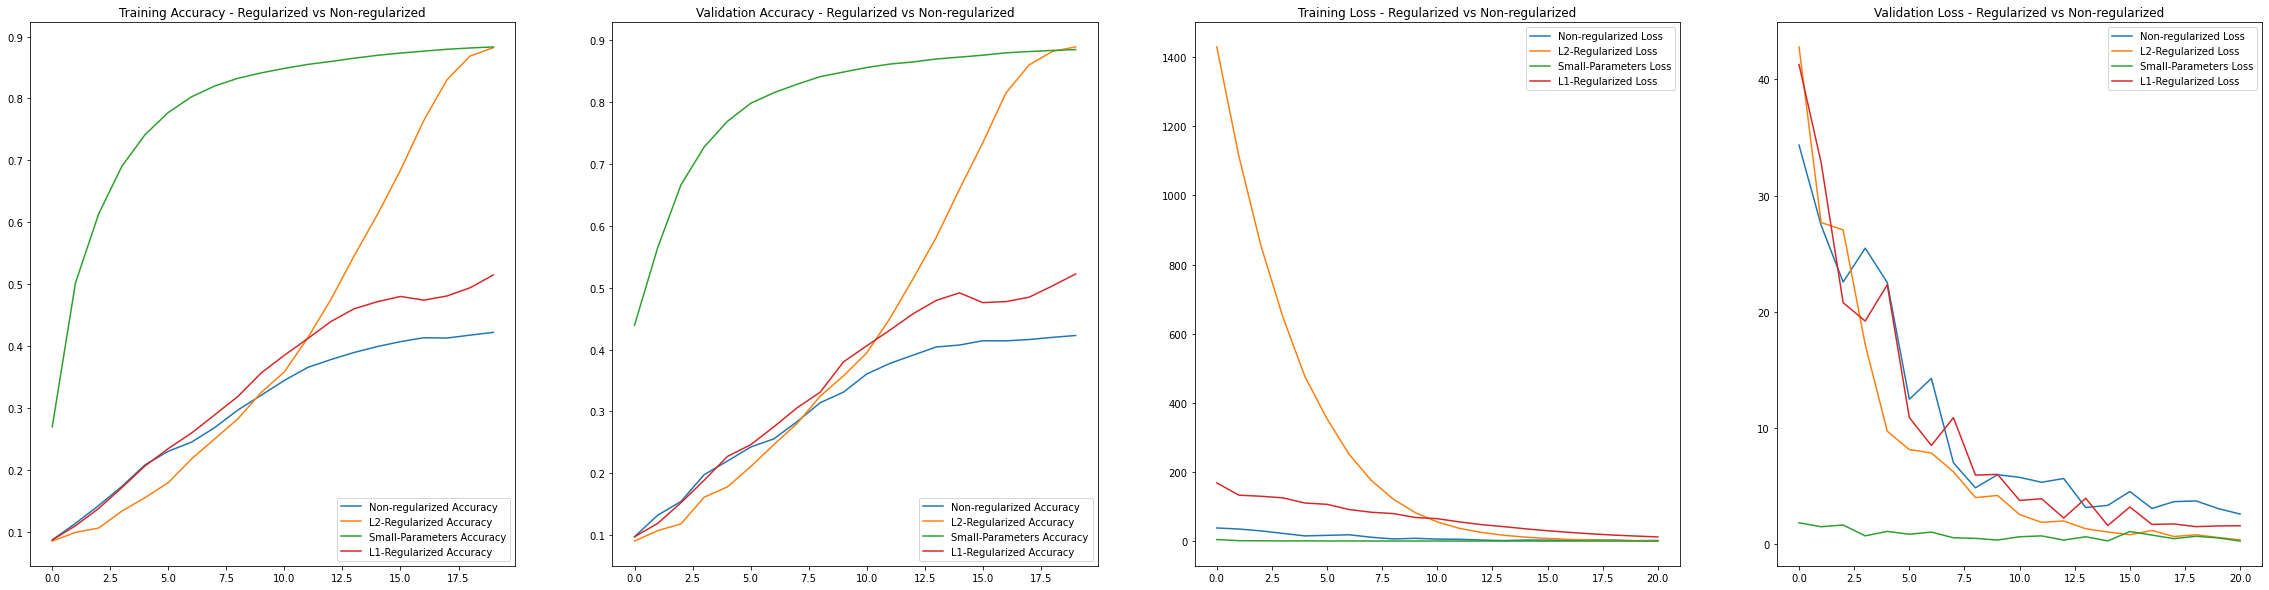

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(40, 10))

ax[0].xlabel = 'Epoch'
ax[0].ylabel = 'Training Accuracy'
ax[0].set_title("Training Accuracy - Regularized vs Non-regularized")
ax[0].plot(np.arange(len(accuracy_history)), accuracy_history, label='Non-regularized Accuracy')
ax[0].plot(np.arange(len(accuracy_history3)), accuracy_history3, label='L2-Regularized Accuracy')
ax[0].plot(np.arange(len(accuracy_history2)), accuracy_history2, label='Small-Parameters Accuracy') 
ax[0].plot(np.arange(len(accuracy_history4)), accuracy_history4, label='L1-Regularized Accuracy') 
ax[0].legend()

ax[1].xlabel = 'Epoch'
ax[1].ylabel = 'Validation Accuracy'
ax[1].set_title("Validation Accuracy - Regularized vs Non-regularized")
ax[1].plot(np.arange(len(val_accuracy_history)), val_accuracy_history, label='Non-regularized Accuracy')
ax[1].plot(np.arange(len(val_accuracy_history3)), val_accuracy_history3, label='L2-Regularized Accuracy')
ax[1].plot(np.arange(len(val_accuracy_history2)), val_accuracy_history2, label='Small-Parameters Accuracy')  
ax[1].plot(np.arange(len(val_accuracy_history4)), val_accuracy_history4, label='L1-Regularized Accuracy')
ax[1].legend()

ax[2].xlabel = 'Epoch'
ax[2].ylabel = 'Training Loss'
ax[2].set_title("Training Loss - Regularized vs Non-regularized")
ax[2].plot(np.arange(len(loss_history)), loss_history, label='Non-regularized Loss')
ax[2].plot(np.arange(len(loss_history3)), loss_history3, label='L2-Regularized Loss')
ax[2].plot(np.arange(len(loss_history)), loss_history2, label='Small-Parameters Loss')  
ax[2].plot(np.arange(len(loss_history4)), loss_history4, label='L1-Regularized Loss')
ax[2].legend()

ax[3].xlabel = 'Epoch'
ax[3].ylabel = 'Validation Loss'
ax[3].set_title("Validation Loss - Regularized vs Non-regularized")
ax[3].plot(np.arange(len(val_loss_history)), val_loss_history, label='Non-regularized Loss')
ax[3].plot(np.arange(len(val_loss_history3)), val_loss_history3, label='L2-Regularized Loss')
ax[3].plot(np.arange(len(val_loss_history)), val_loss_history2, label='Small-Parameters Loss')
ax[3].plot(np.arange(len(val_loss_history4)), val_loss_history4, label='L1-Regularized Loss')
ax[3].legend()

plt.show()

/home/alboz/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/alboz/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/alboz/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level func

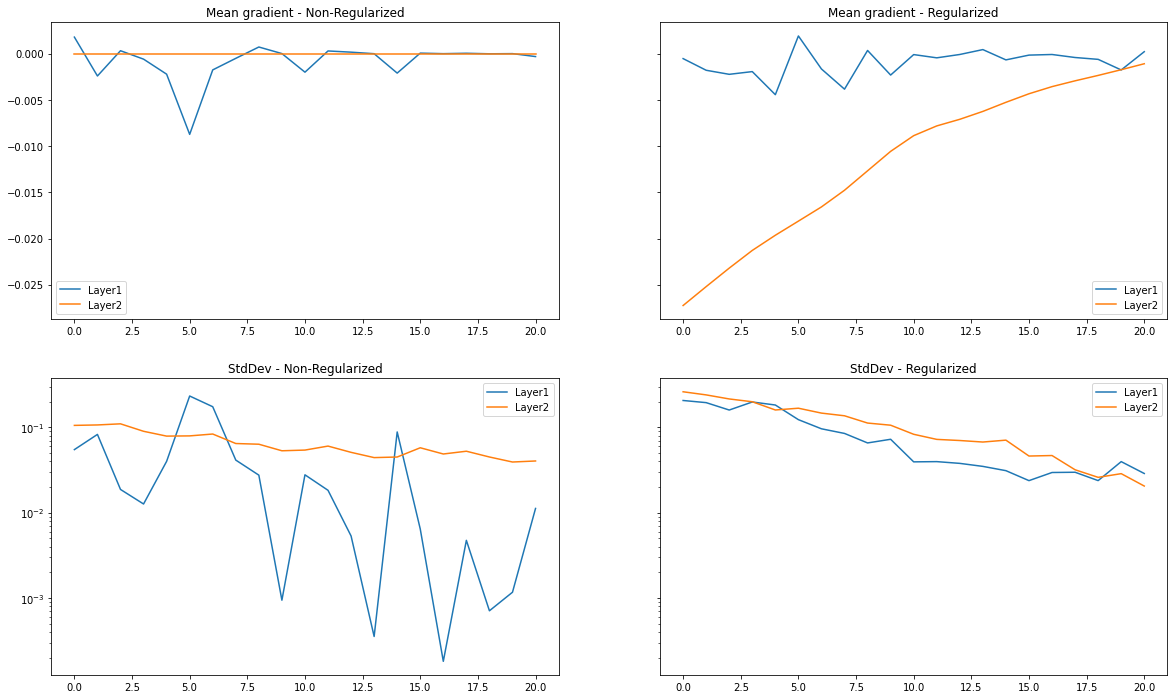

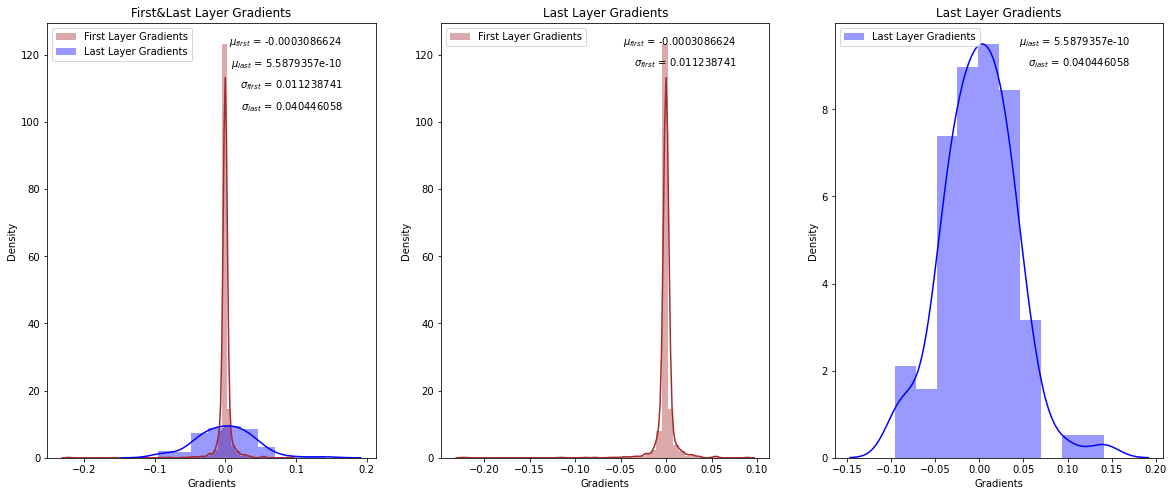

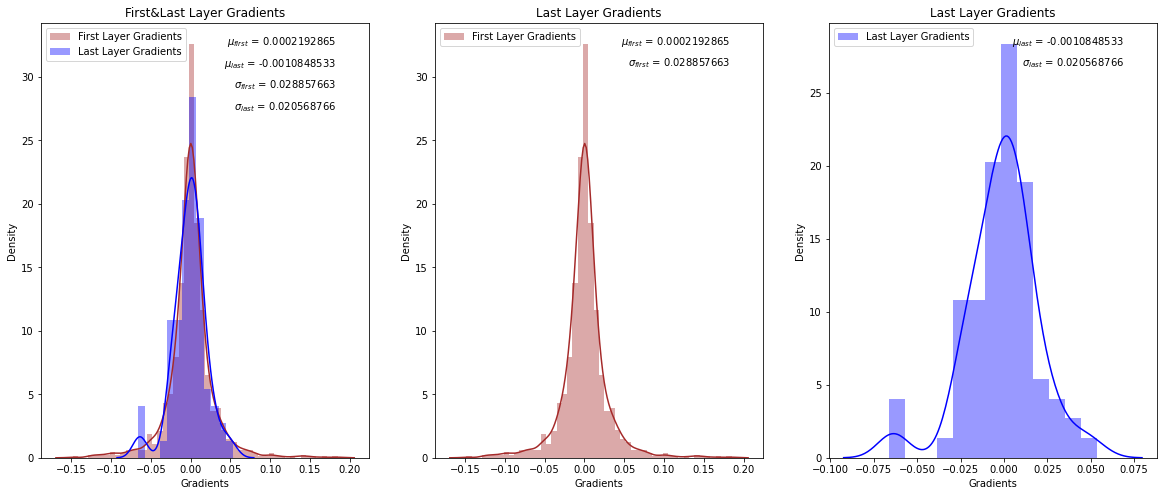

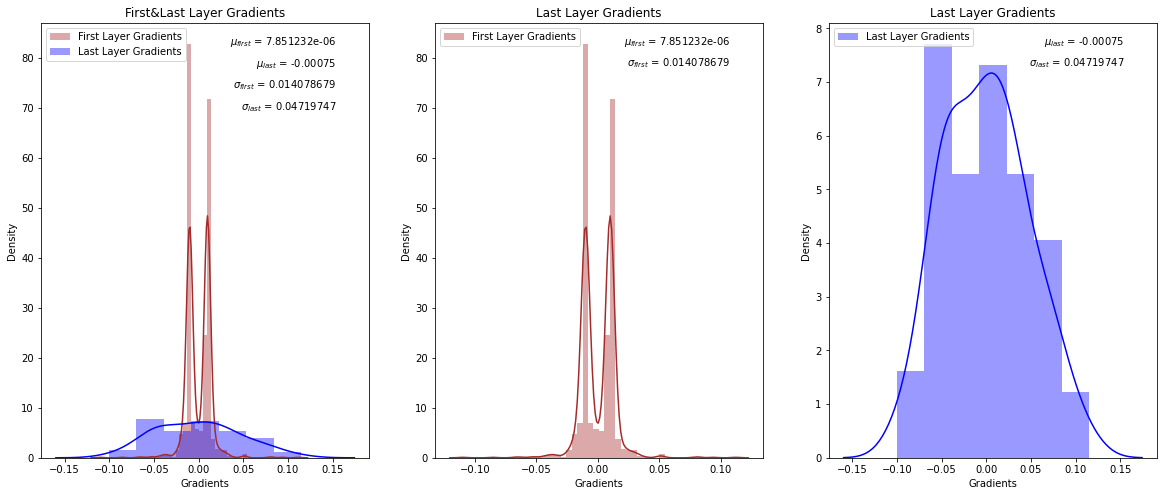

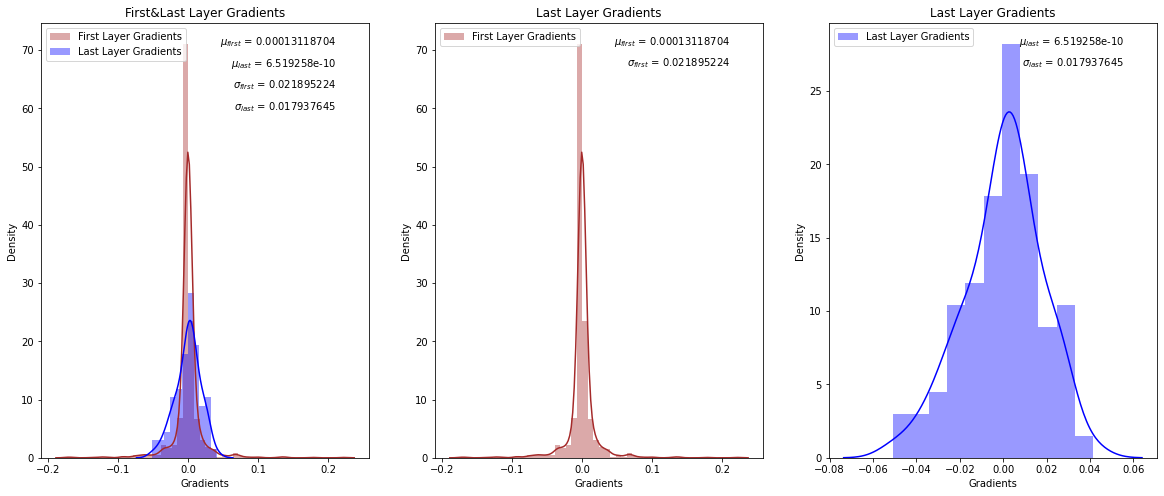

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(20, 12), sharey="row")
    
ax[0,0].set_title("Mean gradient - Non-Regularized")
for key in grad_history[0]:
    ax[0,0].plot(range(len(grad_history)), [w[key].mean() for w in grad_history], label=key)
ax[0,0].legend()

ax[1,0].set_title("StdDev - Non-Regularized")
for key in grad_history[0]:
    ax[1,0].semilogy(range(len(grad_history)), [w[key].std() for w in grad_history], label=key)
ax[1,0].legend()

ax[0,1].set_title("Mean gradient - Regularized")
for key in grad_history3[0]:
    ax[0,1].plot(range(len(grad_history3)), [w[key].mean() for w in grad_history3], label=key)
ax[0,1].legend()

ax[1,1].set_title("StdDev - Regularized")
for key in grad_history3[0]:
    ax[1,1].semilogy(range(len(grad_history3)), [w[key].std() for w in grad_history3], label=key)
ax[1,1].legend()


#First Layer and Last Layer Gradients' Distribution at the end of the Learning Process

plot_gradient_first_last(grad_history)
plot_gradient_first_last(grad_history3)
plot_gradient_first_last(grad_history4)
plot_gradient_first_last(grad_history2)

### 1.3 - Finding the best Regularization parameter

Since Regularization seems not to be working with the current values of $r$, let's see for which value it performs best and see whether there is, actually, a regularization regime in which the vanishing gradient issue is fixed.

**Results:** indeed, the one providing best performance was around $r_{opt} \approx 0.01$, and that for values higher than $0.2$ the regularization performs more poorly than the unregularized model.

In [ ]:
# Model input shape
input_shape = (28, 28, 1)

#Hyperparameters
epochs = 20
#r = 0.01
batch_size = 32
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
metric = tf.keras.metrics.SparseCategoricalAccuracy()

grad_history_l2 = []
loss_history_l2 =  [] 
accuracy_history_l2 = [] 
val_loss_history_l2 = [] 
val_accuracy_history_l2 = [] 

grad_history_l1 = []
loss_history_l1 =  [] 
accuracy_history_l1 = [] 
val_loss_history_l1 = [] 
val_accuracy_history_l1 = [] 

In [ ]:
reg = np.logspace(-3, 2, 10)
print('--- Initializing Regularization Loop ---')
index = 0
for r in reg:
    from time import time
    print('r = ', r, '------- #',index+1 , 'of', len(reg))
    model = make_MLPnet(input_shape=input_shape, activation = 'tanh',
                     predicter = 'softmax', 
                     initializer = tf.keras.initializers.RandomNormal(0,10,seed=1),
                     #initializer = tf.keras.initializers.GlorotUniform(seed = 1),
                     name = 'Layer', 
                     n_hidden=1, 
                     units = 8,
                     regularization_type='l2', 
                     regularization_value=r)
    
    model2 = make_MLPnet(input_shape=input_shape, activation = 'tanh',
                     predicter = 'softmax', 
                     initializer = tf.keras.initializers.RandomNormal(0,10,seed=1),
                     #initializer = tf.keras.initializers.GlorotUniform(seed = 1),
                     name = 'Layer', 
                     n_hidden=1, 
                     units = 8,
                     regularization_type='l1', 
                     regularization_value=r)
    
    grad, train_loss, train_accuracy, val_loss, val_accuracy, time = train_model(x_train, y_train, x_test, y_test,  model, epochs, optimizer, loss, metric, batch_size)
    grad_history_l2.append(grad)
    loss_history_l2.append(train_loss)
    accuracy_history_l2.append(train_accuracy)
    val_loss_history_l2.append(val_loss) 
    val_accuracy_history_l2.append(val_accuracy)
    
    
    from time import time
    grad, train_loss, train_accuracy, val_loss, val_accuracy, time = train_model(x_train, y_train, x_test, y_test,  model2, epochs, optimizer, loss, metric, batch_size)
    grad_history_l1.append(grad)
    loss_history_l1.append(train_loss)
    accuracy_history_l1.append(train_accuracy)
    val_loss_history_l1.append(val_loss) 
    val_accuracy_history_l1.append(val_accuracy)
    index+=1

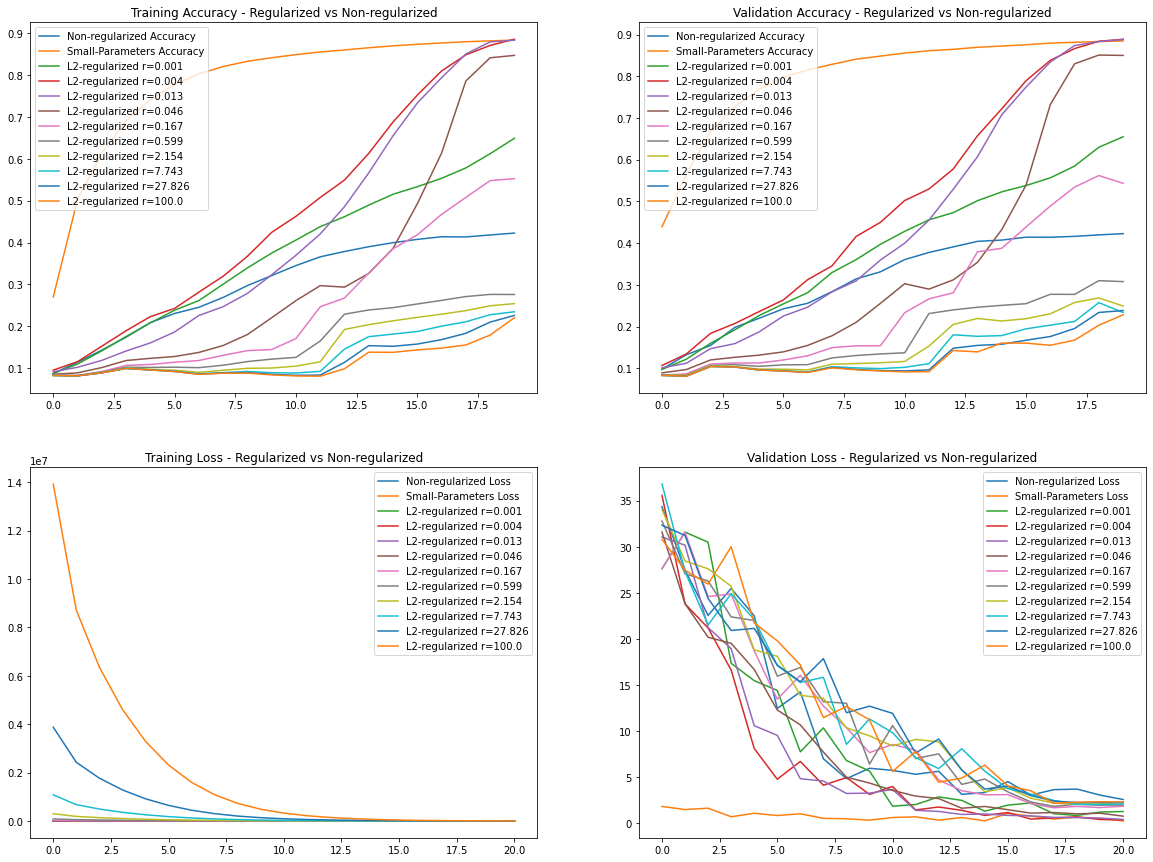

In [ ]:
#L2
fig, ax = plt.subplots(2, 2, figsize=(20,15))

ax[0,0].xlabel = 'Epoch'
ax[0,0].ylabel = 'Training Accuracy'
ax[0,0].set_title("Training Accuracy - Regularized vs Non-regularized")
ax[0,0].plot(np.arange(len(accuracy_history)), accuracy_history, label='Non-regularized Accuracy')
ax[0,0].plot(np.arange(len(accuracy_history2)), accuracy_history2, label='Small-Parameters Accuracy')  
i=0
for r in reg:
    ax[0,0].plot(np.arange(len(accuracy_history_l2[i])), accuracy_history_l2[i], label='L2-regularized r='+str(round(r, 3))) 
    i+=1
ax[0,0].legend()

ax[0,1].xlabel = 'Epoch'
ax[0,1].ylabel = 'Validation Accuracy'
ax[0,1].set_title("Validation Accuracy - Regularized vs Non-regularized")
ax[0,1].plot(np.arange(len(val_accuracy_history)), val_accuracy_history, label='Non-regularized Accuracy')
ax[0,1].plot(np.arange(len(val_accuracy_history2)), val_accuracy_history2, label='Small-Parameters Accuracy') 
i=0
for r in reg:
    ax[0,1].plot(np.arange(len(val_accuracy_history_l2[i])), val_accuracy_history_l2[i], label='L2-regularized r='+str(round(r, 3))) 
    i+=1
ax[0,1].legend()

ax[1,0].xlabel = 'Epoch'
ax[1,0].ylabel = 'Training Loss'
ax[1,0].set_title("Training Loss - Regularized vs Non-regularized")
ax[1,0].plot(np.arange(len(loss_history)), loss_history, label='Non-regularized Loss')
ax[1,0].plot(np.arange(len(loss_history)), loss_history2, label='Small-Parameters Loss')  
i=0
for r in reg:
    ax[1,0].plot(np.arange(len(loss_history_l2[i])), loss_history_l2[i], label='L2-regularized r='+str(round(r, 3))) 
    i+=1
ax[1,0].legend()

ax[1,1].xlabel = 'Epoch'
ax[1,1].ylabel = 'Validation Loss'
ax[1,1].set_title("Validation Loss - Regularized vs Non-regularized")
ax[1,1].plot(np.arange(len(val_loss_history)), val_loss_history, label='Non-regularized Loss')
ax[1,1].plot(np.arange(len(val_loss_history)), val_loss_history2, label='Small-Parameters Loss')
i=0
for r in reg:
    ax[1,1].plot(np.arange(len(val_loss_history_l2[i])), val_loss_history_l2[i], label='L2-regularized r='+str(round(r, 3))) 
    i+=1
ax[1,1].legend()

plt.show()

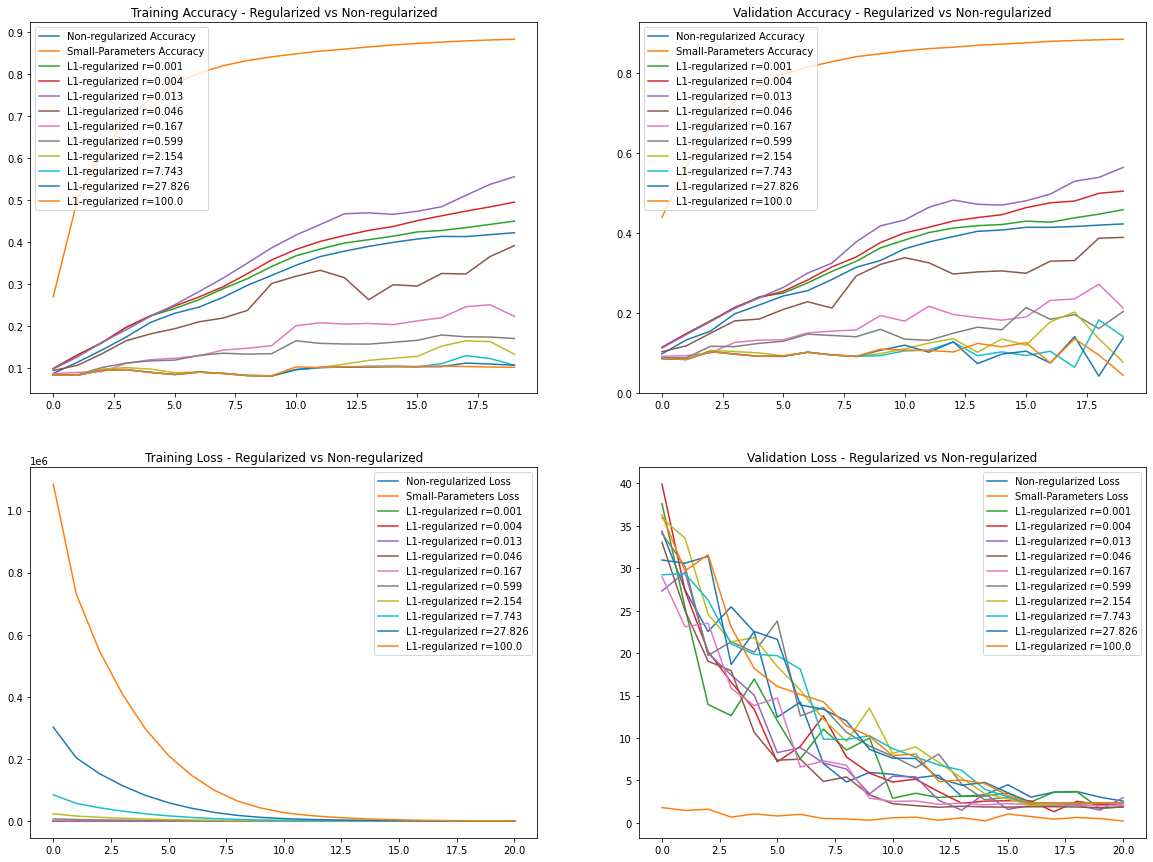

In [ ]:
#L1
fig, ax = plt.subplots(2, 2, figsize=(20,15))

ax[0,0].xlabel = 'Epoch'
ax[0,0].ylabel = 'Training Accuracy'
ax[0,0].set_title("Training Accuracy - Regularized vs Non-regularized")
ax[0,0].plot(np.arange(len(accuracy_history)), accuracy_history, label='Non-regularized Accuracy')
ax[0,0].plot(np.arange(len(accuracy_history2)), accuracy_history2, label='Small-Parameters Accuracy')  
i=0
for r in reg:
    ax[0,0].plot(np.arange(len(accuracy_history_l1[i])), accuracy_history_l1[i], label='L1-regularized r='+str(round(r, 3))) 
    i+=1
ax[0,0].legend()

ax[0,1].xlabel = 'Epoch'
ax[0,1].ylabel = 'Validation Accuracy'
ax[0,1].set_title("Validation Accuracy - Regularized vs Non-regularized")
ax[0,1].plot(np.arange(len(val_accuracy_history)), val_accuracy_history, label='Non-regularized Accuracy')
ax[0,1].plot(np.arange(len(val_accuracy_history2)), val_accuracy_history2, label='Small-Parameters Accuracy') 
i=0
for r in reg:
    ax[0,1].plot(np.arange(len(val_accuracy_history_l1[i])), val_accuracy_history_l1[i], label='L1-regularized r='+str(round(r, 3))) 
    i+=1
ax[0,1].legend()

ax[1,0].xlabel = 'Epoch'
ax[1,0].ylabel = 'Training Loss'
ax[1,0].set_title("Training Loss - Regularized vs Non-regularized")
ax[1,0].plot(np.arange(len(loss_history)), loss_history, label='Non-regularized Loss')
ax[1,0].plot(np.arange(len(loss_history)), loss_history2, label='Small-Parameters Loss')  
i=0
for r in reg:
    ax[1,0].plot(np.arange(len(loss_history_l1[i])), loss_history_l1[i], label='L1-regularized r='+str(round(r, 3))) 
    i+=1
ax[1,0].legend()

ax[1,1].xlabel = 'Epoch'
ax[1,1].ylabel = 'Validation Loss'
ax[1,1].set_title("Validation Loss - Regularized vs Non-regularized")
ax[1,1].plot(np.arange(len(val_loss_history)), val_loss_history, label='Non-regularized Loss')
ax[1,1].plot(np.arange(len(val_loss_history)), val_loss_history2, label='Small-Parameters Loss')
i=0
for r in reg:
    ax[1,1].plot(np.arange(len(val_loss_history_l1[i])), val_loss_history_l1[i], label='L1-regularized r='+str(round(r, 3))) 
    i+=1
ax[1,1].legend()

plt.show()

### 1.4 - Super-large Parameters Regime

The idea is the following: maybe regularization is not influential enough for Large (but not so large) Parameters. Might it be that for even Larger Parameters at least a slight effect is noticeable since it could effect greatly how the Parameters behave under the regularization constraint.

Configuration:

* **Shallow FFNN:** to check that the large parameters is indipendent of how many layers the network has. 


* **Activation Functions:** $tanh$


* **Initialization:** $N(\omega, \mu = 0, \sigma^2 = 20)$ --> Very Large Parameters Regime


* **Loss:** Sparse Categorical Cross-Entropy


* **Learning Algorithm:** Adam --> so as to ensure the fastest convergence and isolate the issue of Large Parameters Regime.

**RESULTS:** By the end of the 20 epochs, L2 is able to reach the unregularized case: in the ealry epochs, the gradients show greater variability compared to the unregularized case, making it possible to improve and catch up, eventually surpassing it, thanks to the higher variance in the first layer's gradients

In [ ]:
# Model input shape
input_shape = (28, 28, 1)

#Hyperparameters
epochs = 20
r = 0.0
batch_size = 32
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
loss= tf.keras.losses.SparseCategoricalCrossentropy()
metric = tf.keras.metrics.SparseCategoricalAccuracy()


model = make_MLPnet(input_shape=input_shape, activation = 'tanh',
                  predicter = 'softmax', 
                  initializer = tf.keras.initializers.RandomNormal(0,20,seed=2),
                  #initializer = tf.keras.initializers.GlorotUniform(seed = 1),
                  name = 'Layer', 
                  n_hidden=1, 
                  units = 8,
                  regularization_type='l2', 
                  regularization_value=r)

grad_history5, loss_history5, accuracy_history5, val_loss_history5, val_accuracy_history5, time5 = train_model(x_train, y_train, x_test, y_test,  model, epochs, optimizer, loss, metric, batch_size)

In [ ]:
# Model input shape
input_shape = (28, 28, 1)

#Hyperparameters
epochs = 20
r = 0.01
batch_size = 32
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
loss= tf.keras.losses.SparseCategoricalCrossentropy()
metric = tf.keras.metrics.SparseCategoricalAccuracy()


model = make_MLPnet(input_shape=input_shape, activation = 'tanh',
                  predicter = 'softmax', 
                  initializer = tf.keras.initializers.RandomNormal(0,20,seed=2),
                  #initializer = tf.keras.initializers.GlorotUniform(seed = 1),
                  name = 'Layer', 
                  n_hidden=1, 
                  units = 8,
                  regularization_type='l2', 
                  regularization_value=r)

grad_history6, loss_history6, accuracy_history6, val_loss_history6, val_accuracy_history6, time6 = train_model(x_train, y_train, x_test, y_test,  model, epochs, optimizer, loss, metric, batch_size)

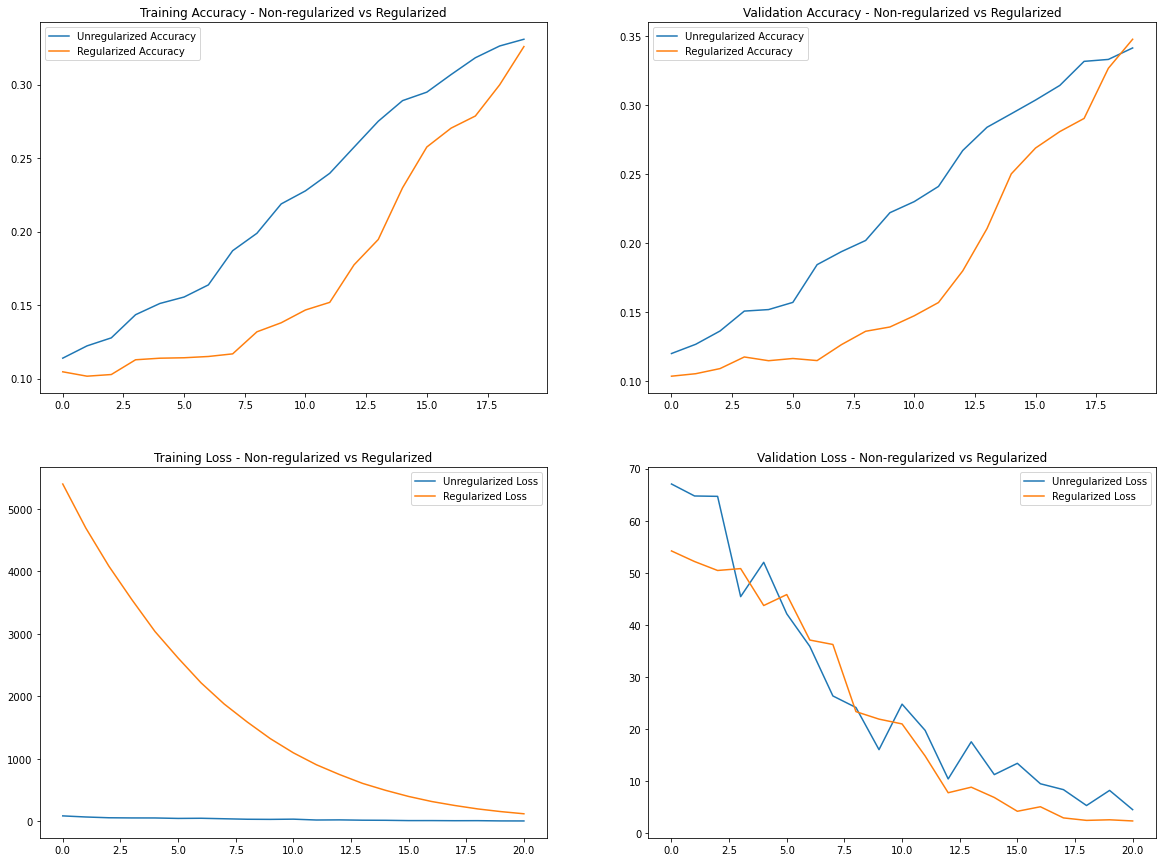

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(20,15))

ax[0,0].xlabel = 'Epoch'
ax[0,0].ylabel = 'Training Accuracy'
ax[0,0].set_title("Training Accuracy - Non-regularized vs Regularized")
ax[0,0].plot(np.arange(len(accuracy_history5)), accuracy_history5, label='Unregularized Accuracy')
ax[0,0].plot(np.arange(len(accuracy_history6)), accuracy_history6, label='Regularized Accuracy')  
ax[0,0].legend()

ax[0,1].xlabel = 'Epoch'
ax[0,1].ylabel = 'Validation Accuracy'
ax[0,1].set_title("Validation Accuracy - Non-regularized vs Regularized")
ax[0,1].plot(np.arange(len(val_accuracy_history5)), val_accuracy_history5, label='Unregularized Accuracy')
ax[0,1].plot(np.arange(len(val_accuracy_history6)), val_accuracy_history6, label='Regularized Accuracy')  
ax[0,1].legend()

ax[1,0].xlabel = 'Epoch'
ax[1,0].ylabel = 'Training Loss'
ax[1,0].set_title("Training Loss - Non-regularized vs Regularized")
ax[1,0].plot(np.arange(len(loss_history5)), loss_history5, label='Unregularized Loss')
ax[1,0].plot(np.arange(len(loss_history6)), loss_history6, label='Regularized Loss')  
ax[1,0].legend()

ax[1,1].xlabel = 'Epoch'
ax[1,1].ylabel = 'Validation Loss'
ax[1,1].set_title("Validation Loss - Non-regularized vs Regularized")
ax[1,1].plot(np.arange(len(val_loss_history5)), val_loss_history5, label='Unregularized Loss')
ax[1,1].plot(np.arange(len(val_loss_history6)), val_loss_history6, label='Regularized Loss')  
ax[1,1].legend()

plt.show()

/home/alboz/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/alboz/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/alboz/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level func

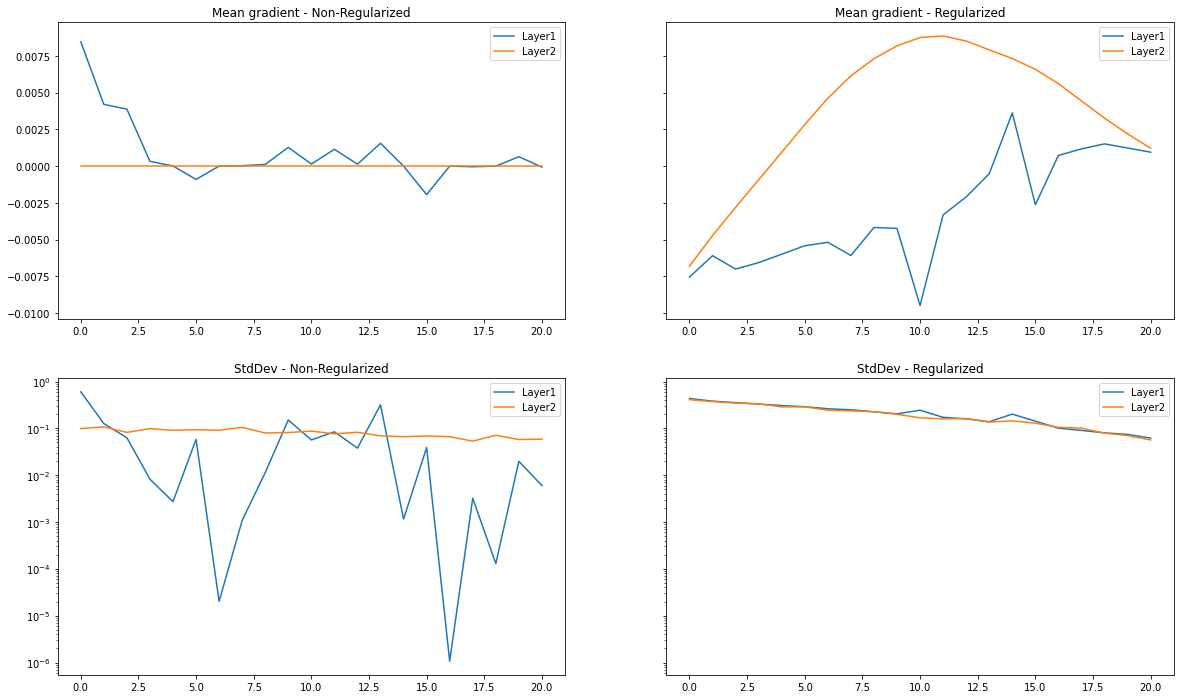

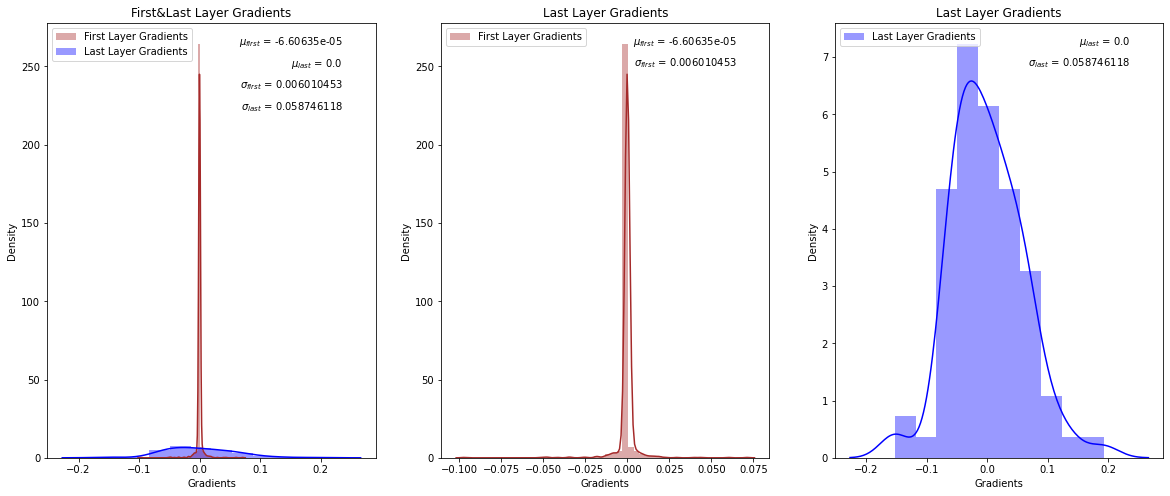

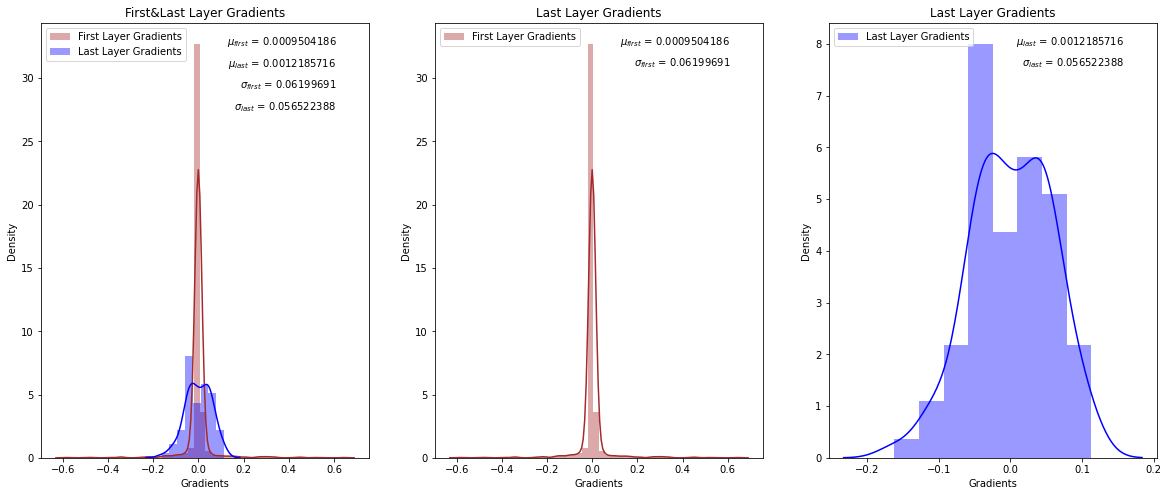

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(20, 12), sharey="row")
    
ax[0,0].set_title("Mean gradient - Non-Regularized")
for key in grad_history5[0]:
    ax[0,0].plot(range(len(grad_history5)), [w[key].mean() for w in grad_history5], label=key)
ax[0,0].legend()

ax[1,0].set_title("StdDev - Non-Regularized")
for key in grad_history5[0]:
    ax[1,0].semilogy(range(len(grad_history5)), [w[key].std() for w in grad_history5], label=key)
ax[1,0].legend()

ax[0,1].set_title("Mean gradient - Regularized")
for key in grad_history6[0]:
    ax[0,1].plot(range(len(grad_history6)), [w[key].mean() for w in grad_history6], label=key)
ax[0,1].legend()

ax[1,1].set_title("StdDev - Regularized")
for key in grad_history6[0]:
    ax[1,1].semilogy(range(len(grad_history6)), [w[key].std() for w in grad_history6], label=key)
ax[1,1].legend()


#First Layer and Last Layer Gradients' Distribution at the end of the Learning Process

plot_gradient_first_last(grad_history5)
plot_gradient_first_last(grad_history6)


### 1.5 - Uniform Large-Parameters Regime

Configuration:

* **Shallow FFNN:** to check that the large parameters is indipendent of how many layers the network has. 


* **Activation Functions:** $tanh$


* **Initialization:** $Uniform(-10,10)$ --> Very Large Parameters Regime


* **Loss:** Sparse Categorical Cross-Entropy


* **Learning Algorithm:** Adam --> so as to ensure the fastest convergence and isolate the issue of Large Parameters Regime.

**RESULTS:** the L2-regularized model outperforms completely the unregularized and L1-models, as the regularization allows, again, for grater variance in the first layer, making it possible for the learning process to keep exploring the parameter-space in search of a minimum 

In [ ]:
#UnRegularized Uniform - Large Parameters Regime

# Model input shape
input_shape = (28, 28, 1)

#Hyperparameters
epochs = 20
r = 0.0
batch_size = 32
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
loss= tf.keras.losses.SparseCategoricalCrossentropy()
metric = tf.keras.metrics.SparseCategoricalAccuracy()


model = make_MLPnet(input_shape=input_shape, activation = 'tanh',
                  predicter = 'softmax', 
                  initializer = tf.keras.initializers.RandomUniform(-10,10,seed=1),
                  #initializer = tf.keras.initializers.GlorotUniform(seed = 1),
                  name = 'Layer', 
                  n_hidden=1, 
                  units = 8,
                  regularization_type='l2', 
                  regularization_value=r)

grad_history7, loss_history7, accuracy_history7, val_loss_history7, val_accuracy_history7, time7 = train_model(x_train, y_train, x_test, y_test,  model, epochs, optimizer, loss, metric, batch_size)

In [ ]:
#L2-Regularized Uniform - Large Parameters Regime

# Model input shape
input_shape = (28, 28, 1)

#Hyperparameters
epochs = 20
r = 0.1
batch_size = 32
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
loss= tf.keras.losses.SparseCategoricalCrossentropy()
metric = tf.keras.metrics.SparseCategoricalAccuracy()


model = make_MLPnet(input_shape=input_shape, activation = 'tanh',
                  predicter = 'softmax', 
                  initializer = tf.keras.initializers.RandomUniform(-10,10,seed=1),
                  #initializer = tf.keras.initializers.GlorotUniform(seed = 1),
                  name = 'Layer', 
                  n_hidden=1, 
                  units = 8,
                  regularization_type='l2', 
                  regularization_value=r)

grad_history8, loss_history8, accuracy_history8, val_loss_history8, val_accuracy_history8, time8 = train_model(x_train, y_train, x_test, y_test,  model, epochs, optimizer, loss, metric, batch_size)

In [ ]:
#L1-Regularized Uniform - Large Parameters Regime

# Model input shape
input_shape = (28, 28, 1)

#Hyperparameters
epochs = 20
r = 0.1
batch_size = 32
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
loss= tf.keras.losses.SparseCategoricalCrossentropy()
metric = tf.keras.metrics.SparseCategoricalAccuracy()


model = make_MLPnet(input_shape=input_shape, activation = 'tanh',
                  predicter = 'softmax', 
                  initializer = tf.keras.initializers.RandomUniform(-10,10,seed=1),
                  #initializer = tf.keras.initializers.GlorotUniform(seed = 1),
                  name = 'Layer', 
                  n_hidden=1, 
                  units = 8,
                  regularization_type='l1', 
                  regularization_value=r)

grad_history9, loss_history9, accuracy_history9, val_loss_history9, val_accuracy_history9, time9 = train_model(x_train, y_train, x_test, y_test,  model, epochs, optimizer, loss, metric, batch_size)

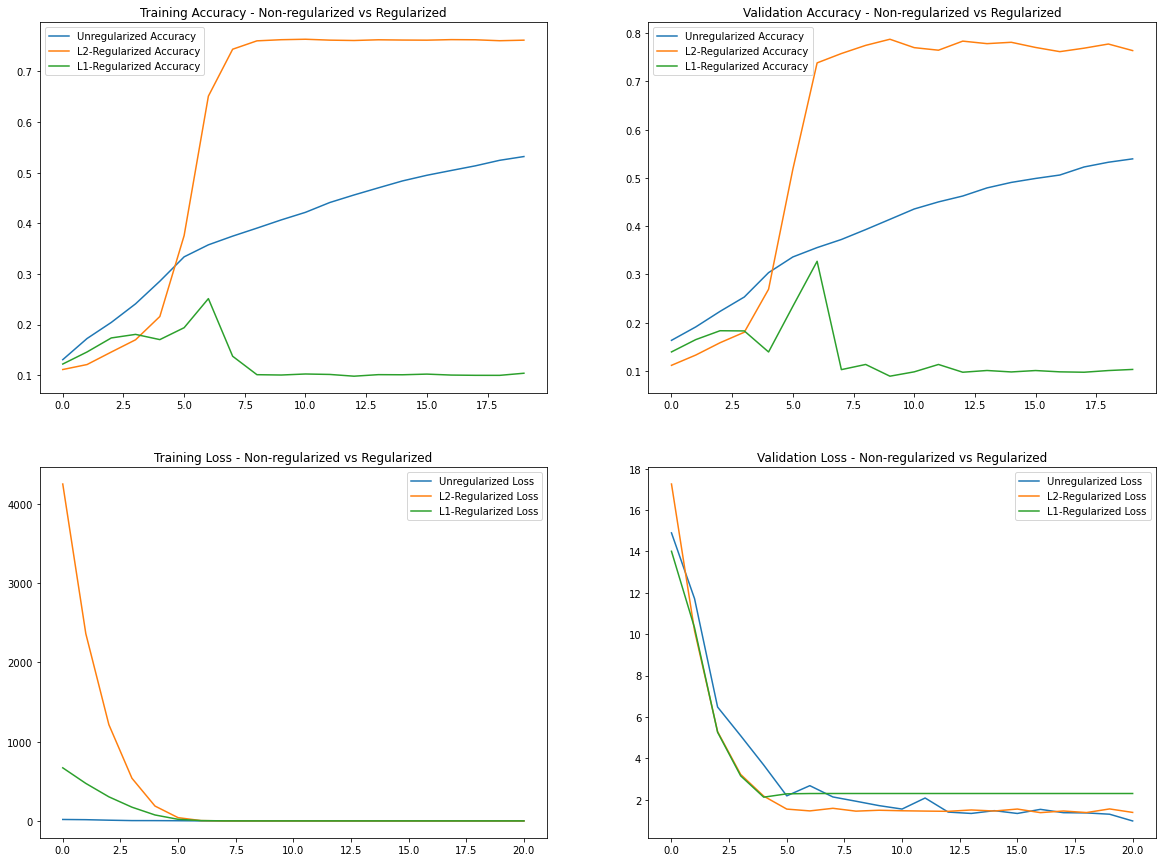

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(20,15))

ax[0,0].xlabel = 'Epoch'
ax[0,0].ylabel = 'Training Accuracy'
ax[0,0].set_title("Training Accuracy - Non-regularized vs Regularized")
ax[0,0].plot(np.arange(len(accuracy_history7)), accuracy_history7, label='Unregularized Accuracy')
ax[0,0].plot(np.arange(len(accuracy_history8)), accuracy_history8, label='L2-Regularized Accuracy') 
ax[0,0].plot(np.arange(len(accuracy_history9)), accuracy_history9, label='L1-Regularized Accuracy')  
ax[0,0].legend()

ax[0,1].xlabel = 'Epoch'
ax[0,1].ylabel = 'Validation Accuracy'
ax[0,1].set_title("Validation Accuracy - Non-regularized vs Regularized")
ax[0,1].plot(np.arange(len(val_accuracy_history7)), val_accuracy_history7, label='Unregularized Accuracy')
ax[0,1].plot(np.arange(len(val_accuracy_history8)), val_accuracy_history8, label='L2-Regularized Accuracy')
ax[0,1].plot(np.arange(len(val_accuracy_history9)), val_accuracy_history9, label='L1-Regularized Accuracy')
ax[0,1].legend()

ax[1,0].xlabel = 'Epoch'
ax[1,0].ylabel = 'Training Loss'
ax[1,0].set_title("Training Loss - Non-regularized vs Regularized")
ax[1,0].plot(np.arange(len(loss_history7)), loss_history7, label='Unregularized Loss')
ax[1,0].plot(np.arange(len(loss_history8)), loss_history8, label='L2-Regularized Loss') 
ax[1,0].plot(np.arange(len(loss_history9)), loss_history9, label='L1-Regularized Loss')  
ax[1,0].legend()

ax[1,1].xlabel = 'Epoch'
ax[1,1].ylabel = 'Validation Loss'
ax[1,1].set_title("Validation Loss - Non-regularized vs Regularized")
ax[1,1].plot(np.arange(len(val_loss_history7)), val_loss_history7, label='Unregularized Loss')
ax[1,1].plot(np.arange(len(val_loss_history8)), val_loss_history8, label='L2-Regularized Loss')  
ax[1,1].plot(np.arange(len(val_loss_history9)), val_loss_history9, label='L1-Regularized Loss') 
ax[1,1].legend()

plt.show()

/home/alboz/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/alboz/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/alboz/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level func

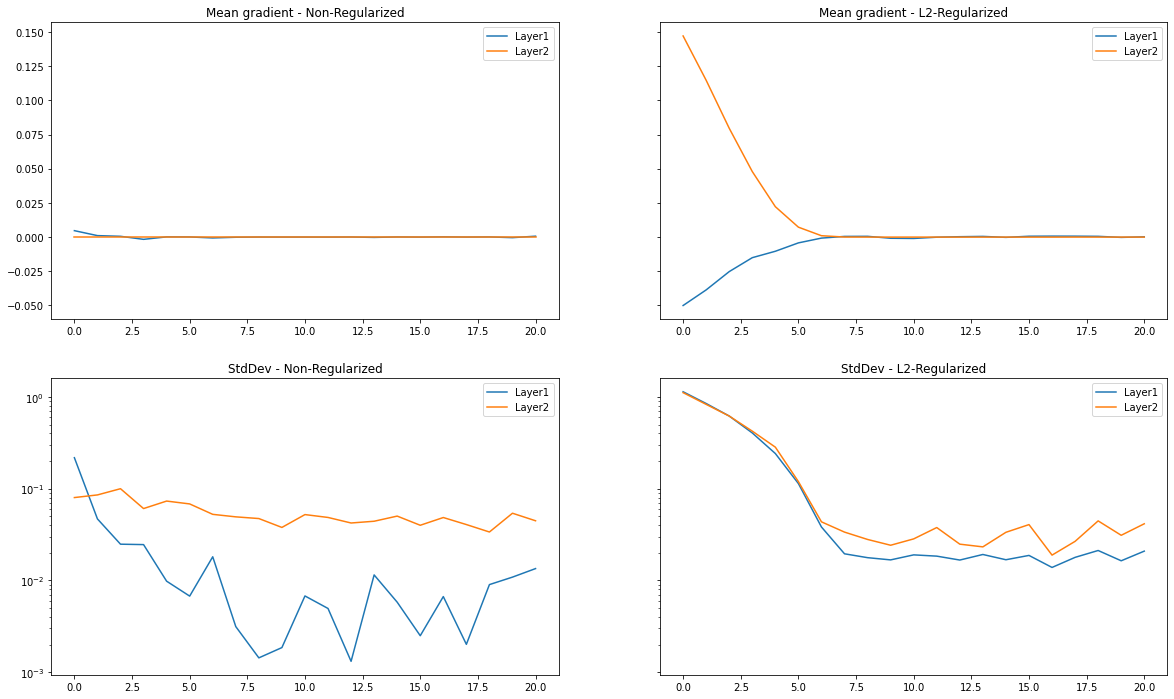

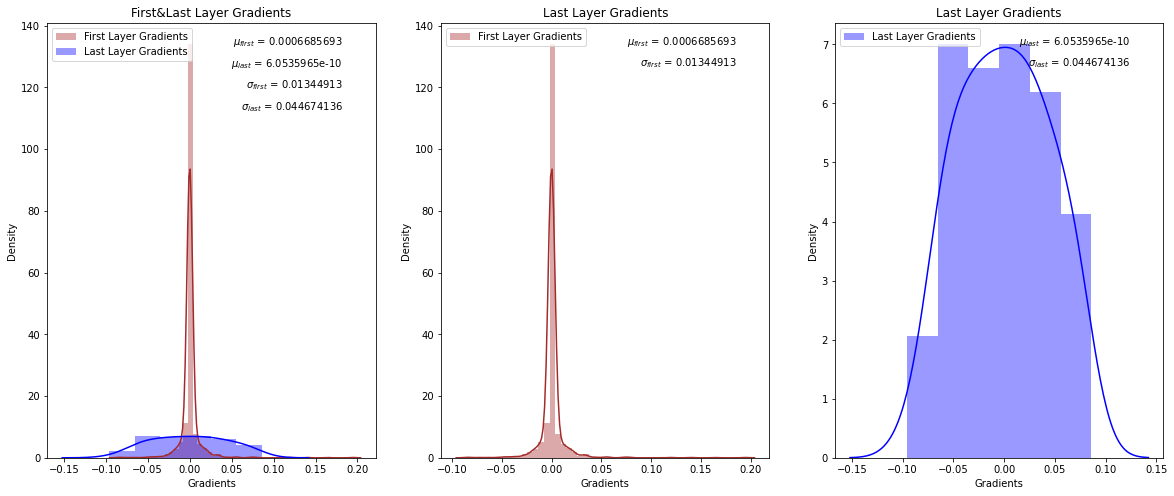

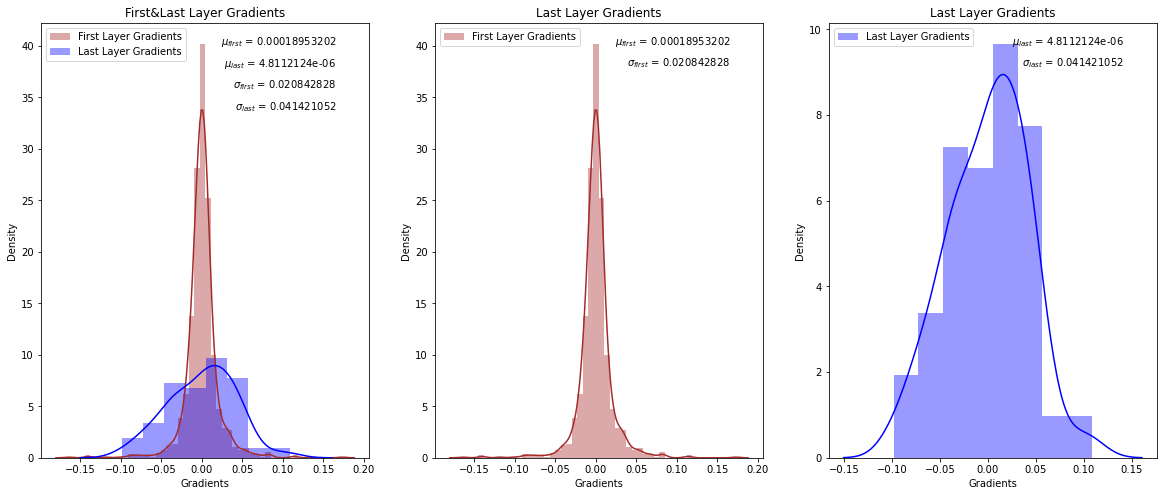

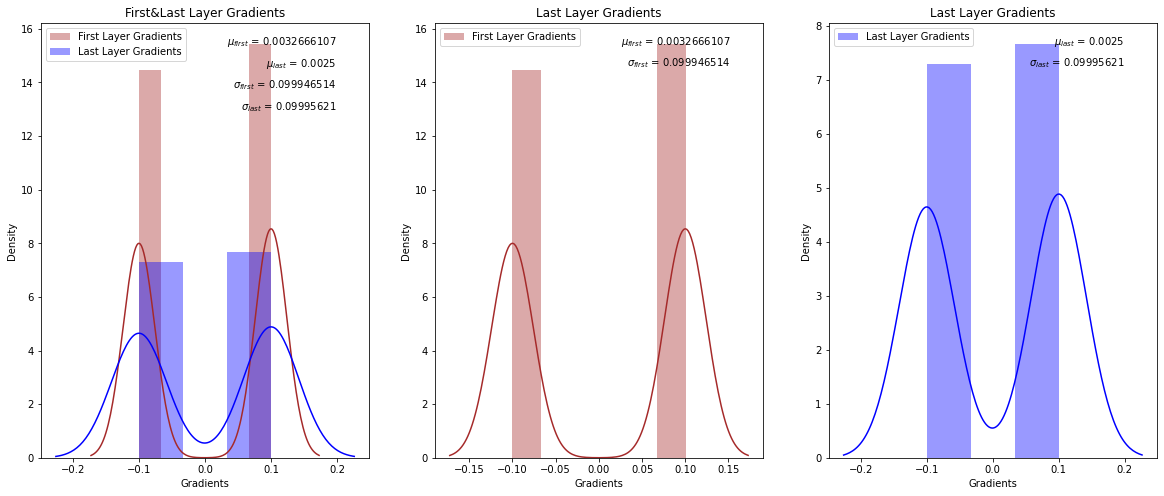

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(20, 12), sharey="row")
    
ax[0,0].set_title("Mean gradient - Non-Regularized")
for key in grad_history7[0]:
    ax[0,0].plot(range(len(grad_history7)), [w[key].mean() for w in grad_history7], label=key)
ax[0,0].legend()

ax[1,0].set_title("StdDev - Non-Regularized")
for key in grad_history7[0]:
    ax[1,0].semilogy(range(len(grad_history7)), [w[key].std() for w in grad_history7], label=key)
ax[1,0].legend()

ax[0,1].set_title("Mean gradient - L2-Regularized")
for key in grad_history8[0]:
    ax[0,1].plot(range(len(grad_history8)), [w[key].mean() for w in grad_history8], label=key)
ax[0,1].legend()

ax[1,1].set_title("StdDev - L2-Regularized")
for key in grad_history8[0]:
    ax[1,1].semilogy(range(len(grad_history8)), [w[key].std() for w in grad_history8], label=key)
ax[1,1].legend()


#First Layer and Last Layer Gradients' Distribution at the end of the Learning Process

plot_gradient_first_last(grad_history7)
plot_gradient_first_last(grad_history8)
plot_gradient_first_last(grad_history9)


### 1.6 - Regularized $\sigma$-like function vs. ReLU

Let's now compare the performance of the sub-optimally intialized, regularized model with a ReLU model with the same initialization and one with optimal initialization. 

**Results:** Surprisingly, although it takes some epochs to reach since starting from a sub-optimal point in the parameter space, the regularized model is able to converge and obtain about the same performance as the ReLU with optimal initialization

In [ ]:
# Model input shape
input_shape = (28, 28, 1)

#Hyperparameters
epochs = 20
r = 0.01
batch_size = 32
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
loss= tf.keras.losses.SparseCategoricalCrossentropy()
metric = tf.keras.metrics.SparseCategoricalAccuracy()


model = make_MLPnet(input_shape=input_shape, activation = 'tanh',
                  predicter = 'softmax', 
                  initializer = tf.keras.initializers.RandomNormal(0,10,seed=1),
                  #initializer = tf.keras.initializers.GlorotUniform(seed = 1),
                  name = 'Layer', 
                  n_hidden=1, 
                  units = 8,
                  regularization_type='l2', 
                  regularization_value=r)

grad_history3, loss_history3, accuracy_history3, val_loss_history3, val_accuracy_history3, time3 = train_model(x_train, y_train, x_test, y_test,  model, epochs, optimizer, loss, metric, batch_size)


In [ ]:
#RELU

# Model input shape
input_shape = (28, 28, 1)

#Hyperparameters
epochs = 20
r = 0.0
batch_size = 32
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
loss= tf.keras.losses.SparseCategoricalCrossentropy()
metric = tf.keras.metrics.SparseCategoricalAccuracy()


model_relu = make_MLPnet(input_shape=input_shape, activation = 'relu',
                  predicter = 'softmax', 
                  initializer = tf.keras.initializers.RandomNormal(0,10,seed=1),
                  #initializer = tf.keras.initializers.GlorotUniform(seed = 1),
                  name = 'Layer', 
                  n_hidden=1, 
                  units = 8,
                  regularization_type='l2', 
                  regularization_value=r)

grad_history_relu, loss_history_relu, accuracy_history_relu, val_loss_history_relu, val_accuracy_history_relu, time_relu = train_model(x_train, y_train, x_test, y_test,  model_relu, epochs, optimizer, loss, metric, batch_size)


model_relu2 = make_MLPnet(input_shape=input_shape, activation = 'relu',
                  predicter = 'softmax', 
                  #initializer = tf.keras.initializers.RandomNormal(0,10,seed=1),
                  initializer = tf.keras.initializers.GlorotUniform(seed = 1),
                  name = 'Layer', 
                  n_hidden=1, 
                  units = 8,
                  regularization_type='l2', 
                  regularization_value=r)

grad_history_relu2, loss_history_relu2, accuracy_history_relu2, val_loss_history_relu2, val_accuracy_history_relu2, time_relu = train_model(x_train, y_train, x_test, y_test,  model_relu2, epochs, optimizer, loss, metric, batch_size)


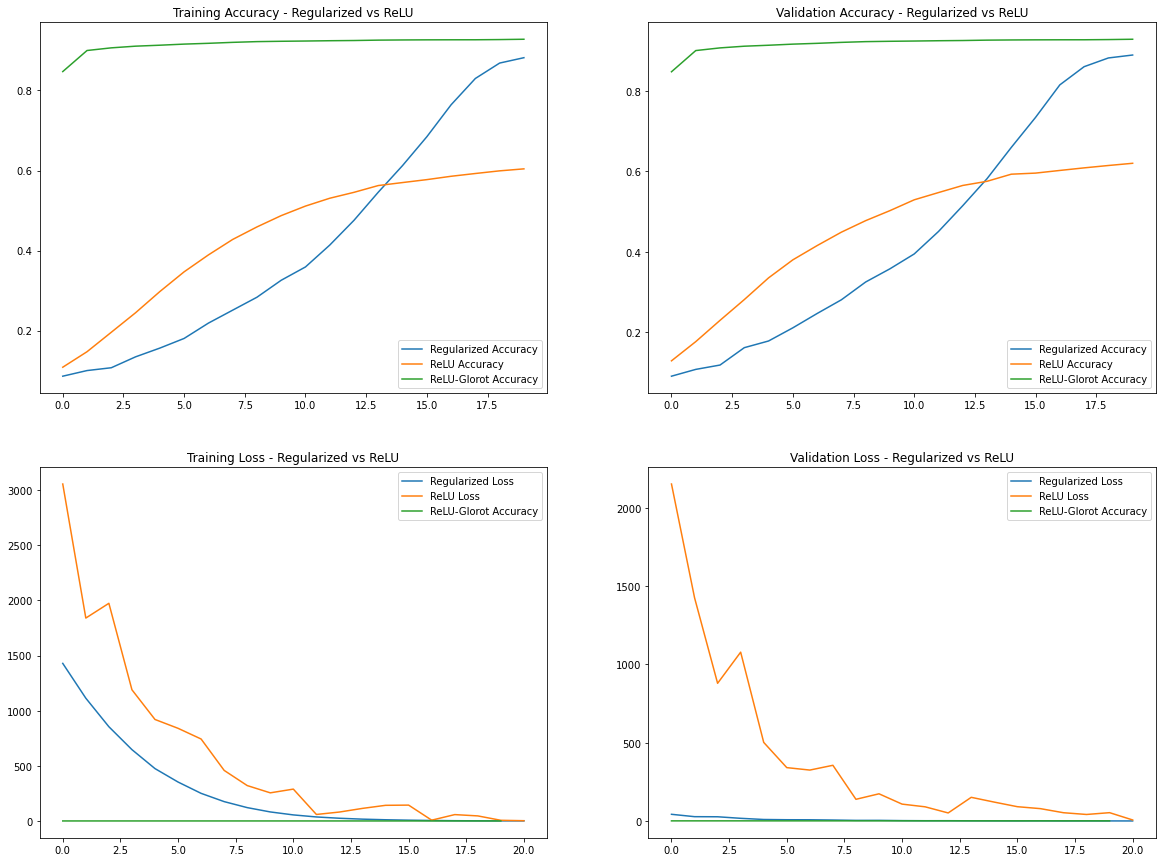

In [ ]:
#L2
fig, ax = plt.subplots(2, 2, figsize=(20,15))

ax[0,0].xlabel = 'Epoch'
ax[0,0].ylabel = 'Training Accuracy'
ax[0,0].set_title("Training Accuracy - Regularized vs ReLU")
ax[0,0].plot(np.arange(len(accuracy_history3)), accuracy_history3, label='Regularized Accuracy')
ax[0,0].plot(np.arange(len(accuracy_history_relu)), accuracy_history_relu, label='ReLU Accuracy') 
ax[0,0].plot(np.arange(len(accuracy_history_relu2)), accuracy_history_relu2, label='ReLU-Glorot Accuracy')  
ax[0,0].legend()

ax[0,1].xlabel = 'Epoch'
ax[0,1].ylabel = 'Validation Accuracy'
ax[0,1].set_title("Validation Accuracy - Regularized vs ReLU")
ax[0,1].plot(np.arange(len(val_accuracy_history3)), val_accuracy_history3, label='Regularized Accuracy')
ax[0,1].plot(np.arange(len(val_accuracy_history_relu)), val_accuracy_history_relu, label='ReLU Accuracy') 
ax[0,1].plot(np.arange(len(accuracy_history_relu2)), accuracy_history_relu2, label='ReLU-Glorot Accuracy')  
ax[0,1].legend()

ax[1,0].xlabel = 'Epoch'
ax[1,0].ylabel = 'Training Loss'
ax[1,0].set_title("Training Loss - Regularized vs ReLU")
ax[1,0].plot(np.arange(len(loss_history3)), loss_history3, label='Regularized Loss')
ax[1,0].plot(np.arange(len(loss_history_relu)), loss_history_relu, label='ReLU Loss') 
ax[1,0].plot(np.arange(len(accuracy_history_relu2)), accuracy_history_relu2, label='ReLU-Glorot Accuracy')  
ax[1,0].legend()

ax[1,1].xlabel = 'Epoch'
ax[1,1].ylabel = 'Validation Loss'
ax[1,1].set_title("Validation Loss - Regularized vs ReLU")
ax[1,1].plot(np.arange(len(val_loss_history3)), val_loss_history3, label='Regularized Loss')
ax[1,1].plot(np.arange(len(val_loss_history_relu)), val_loss_history_relu, label='ReLU Loss')
ax[1,1].plot(np.arange(len(accuracy_history_relu2)), accuracy_history_relu2, label='ReLU-Glorot Accuracy')  
ax[1,1].legend()

plt.show()

## 2 - CNN Large Parameters Regime (repeating the whole same pipeline)

### 2.1 - Initializations Comparison ($\sigma^2=1$ vs. $\sigma^2=10$)

Configuration:

* **Small CNN:** to check that the large parameters is indipendent of how many layers the network has. 


* **Activation Functions:** $tanh$


* **Initialization:** $N(\omega, \mu = 0, \sigma^2 = 10)$ --> Large Parameters Regime


* **Loss:** Sparse Categorical Cross-Entropy


* **Learning Algorithm:** Adam --> so as to ensure the fastest convergence and isolate the issue of Large Parameters Regime.

**RESULTS:** Initialization makes a big difference, even more so in the case of a CNN which has a deeper structure of the MLP used above. Thus, the effects of Many Layers and Large Parameters compund together slowing down the learning process even more. The networks used are the same, and with different initialization a very different result is obtained.

In [ ]:
#Small CNN with large parameters

# Model input shape
input_shape = (28, 28, 1)

#Hyperparameters
epochs = 20
r = 0.0
batch_size = 32
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
loss= tf.keras.losses.SparseCategoricalCrossentropy()
metric = tf.keras.metrics.SparseCategoricalAccuracy()


model = make_CNNnet(input_shape=input_shape, activation = 'tanh',
                  predicter = 'softmax', 
                  initializer = tf.keras.initializers.RandomNormal(0,10,seed=1),
                  #initializer = tf.keras.initializers.GlorotUniform(seed = 1),
                  name = 'Layer', 
                  n_hidden=1, 
                  units = 8,
                  regularization_type='l2', 
                  regularization_value=r)

cnn_grad_history, cnn_loss_history, cnn_accuracy_history, cnn_val_loss_history, cnn_val_accuracy_history, cnn_time = train_model(x_train_norm, y_train, x_test_norm, y_test,  model, epochs, optimizer, loss, metric, batch_size)

In [ ]:
#Small CNN with Small parameters

# Model input shape
input_shape = (28, 28, 1)

#Hyperparameters
epochs = 20
r = 0.0
batch_size = 32
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
loss= tf.keras.losses.SparseCategoricalCrossentropy()
metric = tf.keras.metrics.SparseCategoricalAccuracy()


model2 = make_CNNnet(input_shape=input_shape, activation = 'tanh',
                  predicter = 'softmax', 
                  initializer = tf.keras.initializers.RandomNormal(0,1,seed=1),
#                   initializer = tf.keras.initializers.GlorotUniform(seed = 1),
                  name = 'Layer', 
                  n_hidden=1, 
                  units =8,
                  regularization_type='l2', 
                  regularization_value=r)

cnn_grad_history2, cnn_loss_history2, cnn_accuracy_history2, cnn_val_loss_history2, cnn_val_accuracy_history2, cnn_time2 = train_model(x_train_norm, y_train, x_test_norm, y_test,  model2, epochs, optimizer, loss, metric, batch_size)

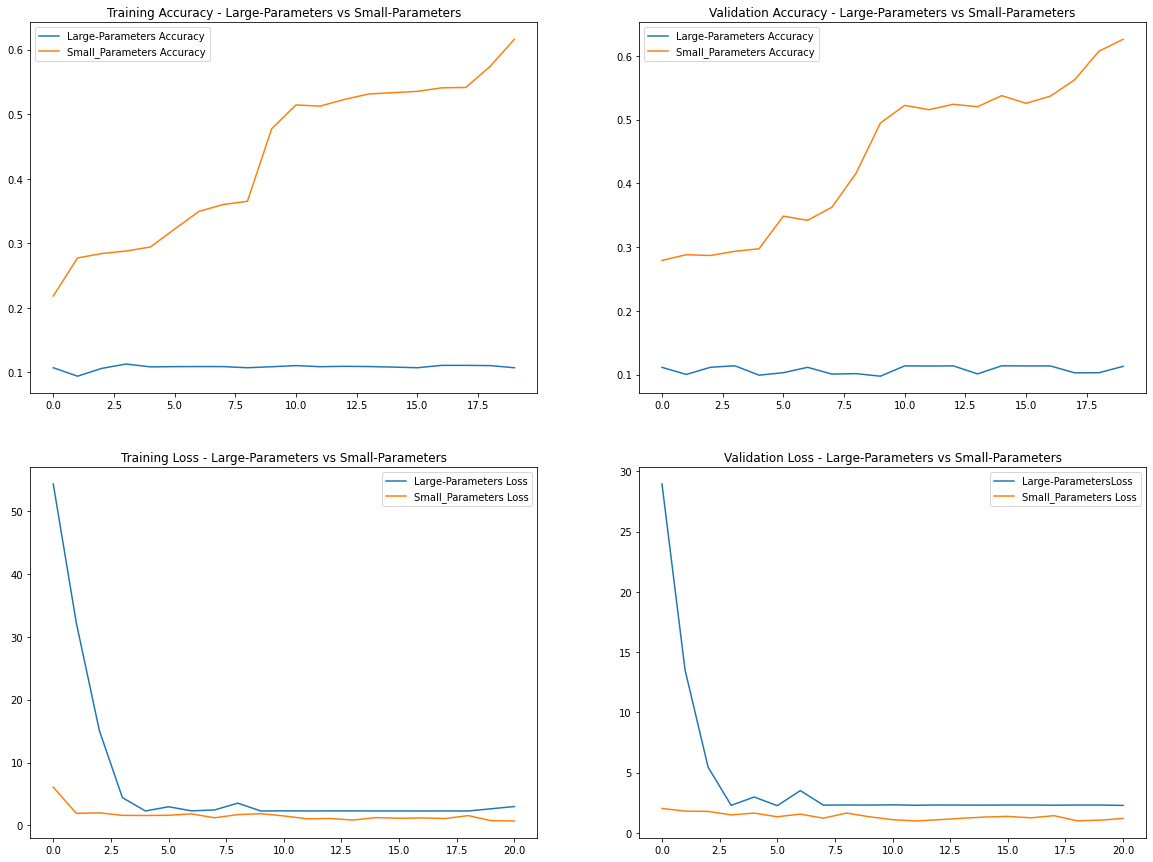

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(20,15))

ax[0,0].xlabel = 'Epoch'
ax[0,0].ylabel = 'Training Accuracy'
ax[0,0].set_title("Training Accuracy - Large-Parameters vs Small-Parameters")
ax[0,0].plot(np.arange(len(cnn_accuracy_history)), cnn_accuracy_history, label='Large-Parameters Accuracy')
ax[0,0].plot(np.arange(len(cnn_accuracy_history)), cnn_accuracy_history2, label='Small_Parameters Accuracy')  
ax[0,0].legend()

ax[0,1].xlabel = 'Epoch'
ax[0,1].ylabel = 'Validation Accuracy'
ax[0,1].set_title("Validation Accuracy - Large-Parameters vs Small-Parameters")
ax[0,1].plot(np.arange(len(cnn_val_accuracy_history)), cnn_val_accuracy_history, label='Large-Parameters Accuracy')
ax[0,1].plot(np.arange(len(cnn_val_accuracy_history)), cnn_val_accuracy_history2, label='Small_Parameters Accuracy')  
ax[0,1].legend()

ax[1,0].xlabel = 'Epoch'
ax[1,0].ylabel = 'Training Loss'
ax[1,0].set_title("Training Loss - Large-Parameters vs Small-Parameters")
ax[1,0].plot(np.arange(len(cnn_loss_history)), cnn_loss_history, label='Large-Parameters Loss')
ax[1,0].plot(np.arange(len(cnn_loss_history)), cnn_loss_history2, label='Small_Parameters Loss')  
ax[1,0].legend()

ax[1,1].xlabel = 'Epoch'
ax[1,1].ylabel = 'Validation Loss'
ax[1,1].set_title("Validation Loss - Large-Parameters vs Small-Parameters")
ax[1,1].plot(np.arange(len(cnn_val_loss_history)), cnn_val_loss_history, label='Large-ParametersLoss')
ax[1,1].plot(np.arange(len(cnn_val_loss_history)), cnn_val_loss_history2, label='Small_Parameters Loss')  
ax[1,1].legend()

plt.show()

### 2.2 - Adding Regularization

Configuration:

* **Small CNN:** to check that the large parameters is indipendent of how many layers the network has. 


* **Activation Functions:** $tanh$


* **Initialization:** $N(\omega, \mu = 0, \sigma^2 = 10)$ --> Large Parameters Regime


* **Loss:** Sparse Categorical Cross-Entropy


* **Learning Algorithm:** Adam --> so as to ensure the fastest convergence and isolate the issue of Large Parameters Regime.

**RESULTS:** Regularization manages to outperform even the optimal initialization.

In [ ]:
#Small CNN with large parameters

# Model input shape
input_shape = (28, 28, 1)

#Hyperparameters
epochs = 20
r = 0.1
batch_size = 32
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
loss= tf.keras.losses.SparseCategoricalCrossentropy()
metric = tf.keras.metrics.SparseCategoricalAccuracy()


model = make_CNNnet(input_shape=input_shape, activation = 'tanh',
                  predicter = 'softmax', 
                  initializer = tf.keras.initializers.RandomNormal(0,10,seed=1),
                  #initializer = tf.keras.initializers.GlorotUniform(seed = 1),
                  name = 'Layer', 
                  n_hidden=1, 
                  units = 8,
                  regularization_type='l2', 
                  regularization_value=r)

cnn_grad_history3, cnn_loss_history3, cnn_accuracy_history3, cnn_val_loss_history3, cnn_val_accuracy_history3, cnn_time3 = train_model(x_train_norm, y_train, x_test_norm, y_test,  model, epochs, optimizer, loss, metric, batch_size)

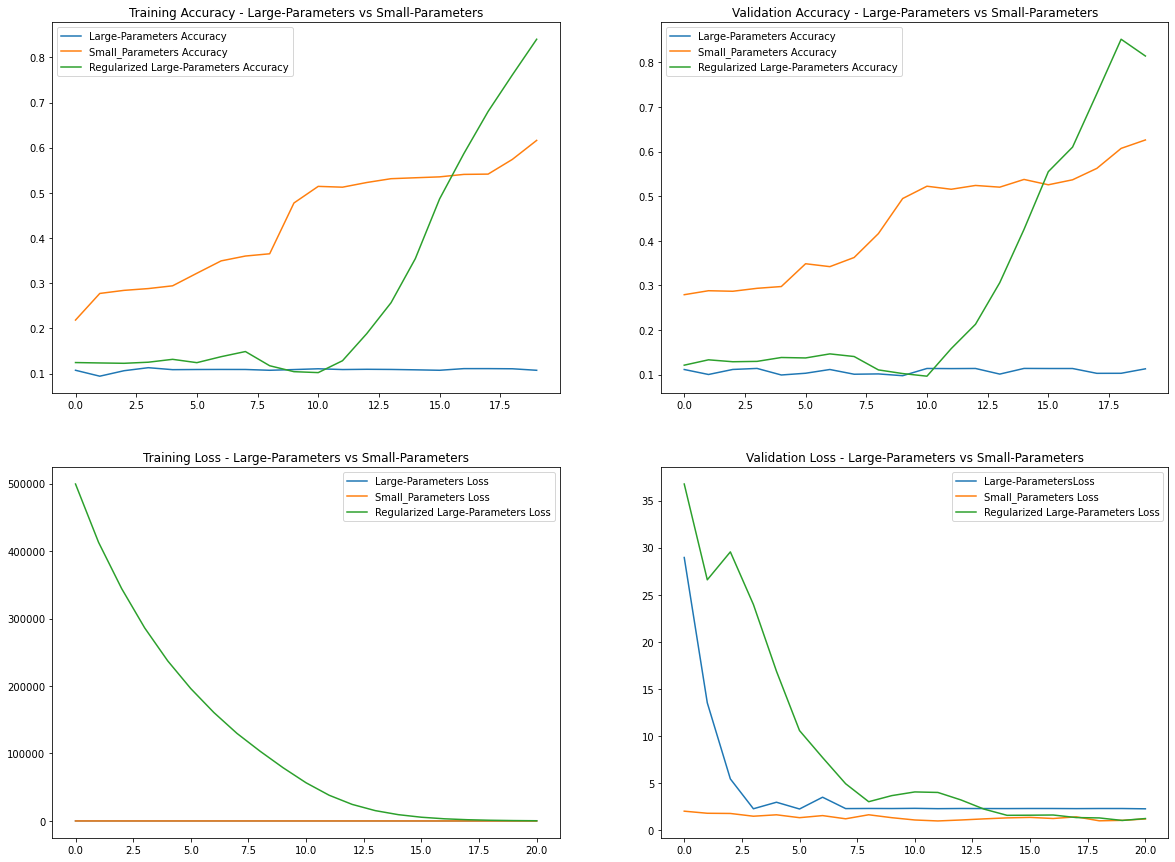

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(20,15))

ax[0,0].xlabel = 'Epoch'
ax[0,0].ylabel = 'Training Accuracy'
ax[0,0].set_title("Training Accuracy - Large-Parameters vs Small-Parameters")
ax[0,0].plot(np.arange(len(cnn_accuracy_history)), cnn_accuracy_history, label='Large-Parameters Accuracy')
ax[0,0].plot(np.arange(len(cnn_accuracy_history)), cnn_accuracy_history2, label='Small_Parameters Accuracy')
ax[0,0].plot(np.arange(len(cnn_accuracy_history3)), cnn_accuracy_history3, label='Regularized Large-Parameters Accuracy')
ax[0,0].legend()

ax[0,1].xlabel = 'Epoch'
ax[0,1].ylabel = 'Validation Accuracy'
ax[0,1].set_title("Validation Accuracy - Large-Parameters vs Small-Parameters")
ax[0,1].plot(np.arange(len(cnn_val_accuracy_history)), cnn_val_accuracy_history, label='Large-Parameters Accuracy')
ax[0,1].plot(np.arange(len(cnn_val_accuracy_history)), cnn_val_accuracy_history2, label='Small_Parameters Accuracy')
ax[0,1].plot(np.arange(len(cnn_val_accuracy_history3)), cnn_val_accuracy_history3, label='Regularized Large-Parameters Accuracy')
ax[0,1].legend()

ax[1,0].xlabel = 'Epoch'
ax[1,0].ylabel = 'Training Loss'
ax[1,0].set_title("Training Loss - Large-Parameters vs Small-Parameters")
ax[1,0].plot(np.arange(len(cnn_loss_history)), cnn_loss_history, label='Large-Parameters Loss')
ax[1,0].plot(np.arange(len(cnn_loss_history)), cnn_loss_history2, label='Small_Parameters Loss')  
ax[1,0].plot(np.arange(len(cnn_loss_history3)), cnn_loss_history3, label='Regularized Large-Parameters Loss')
ax[1,0].legend()

ax[1,1].xlabel = 'Epoch'
ax[1,1].ylabel = 'Validation Loss'
ax[1,1].set_title("Validation Loss - Large-Parameters vs Small-Parameters")
ax[1,1].plot(np.arange(len(cnn_val_loss_history)), cnn_val_loss_history, label='Large-ParametersLoss')
ax[1,1].plot(np.arange(len(cnn_val_loss_history)), cnn_val_loss_history2, label='Small_Parameters Loss') 
ax[1,1].plot(np.arange(len(cnn_val_loss_history3)), cnn_val_loss_history3, label='Regularized Large-Parameters Loss')
ax[1,1].legend()

plt.show()

### 2.4 - Super-large Parameters Regime

Configuration:

* **Shallow FFNN:** to check that the large parameters is indipendent of how many layers the network has. 


* **Activation Functions:** $tanh$


* **Initialization:** $N(\omega, \mu = 0, \sigma^2 = 20)$ --> Very Large Parameters Regime


* **Loss:** Sparse Categorical Cross-Entropy


* **Learning Algorithm:** Adam --> so as to ensure the fastest convergence and isolate the issue of Large Parameters Regime.

**RESULTS:** With this initialization, the regularized model struggles. It may be the case that starting from a very difficult position in the phase space, it takes it more time to find its way and out-perform the unregularized model. For computational time reasons, this hypothesis has not been possible to check.

In [ ]:
# Model input shape
input_shape = (28, 28, 1)

#Hyperparameters
epochs = 20
r = 0.0
batch_size = 32
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
loss= tf.keras.losses.SparseCategoricalCrossentropy()
metric = tf.keras.metrics.SparseCategoricalAccuracy()


model = make_CNNnet(input_shape=input_shape, activation = 'tanh',
                  predicter = 'softmax', 
                  initializer = tf.keras.initializers.RandomNormal(0,20,seed=1),
                  #initializer = tf.keras.initializers.GlorotUniform(seed = 1),
                  name = 'Layer', 
                  n_hidden=1, 
                  units = 8,
                  regularization_type='l2', 
                  regularization_value=r)

cnn_grad_history5, cnn_loss_history5, cnn_accuracy_history5, cnn_val_loss_history5, cnn_val_accuracy_history5, cnn_time5 = train_model(x_train_norm, y_train, x_test_norm, y_test,  model, epochs, optimizer, loss, metric, batch_size)

In [ ]:
# Model input shape
input_shape = (28, 28, 1)

#Hyperparameters
epochs = 20
r = 0.1
batch_size = 32
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
loss= tf.keras.losses.SparseCategoricalCrossentropy()
metric = tf.keras.metrics.SparseCategoricalAccuracy()


model = make_CNNnet(input_shape=input_shape, activation = 'tanh',
                  predicter = 'softmax', 
                  initializer = tf.keras.initializers.RandomNormal(0,20,seed=1),
                  #initializer = tf.keras.initializers.GlorotUniform(seed = 1),
                  name = 'Layer', 
                  n_hidden=1, 
                  units = 8,
                  regularization_type='l2', 
                  regularization_value=r)

cnn_grad_history6, cnn_loss_history6, cnn_accuracy_history6, cnn_val_loss_history6, cnn_val_accuracy_history6, cnn_time6 = train_model(x_train_norm, y_train, x_test_norm, y_test,  model, epochs, optimizer, loss, metric, batch_size)

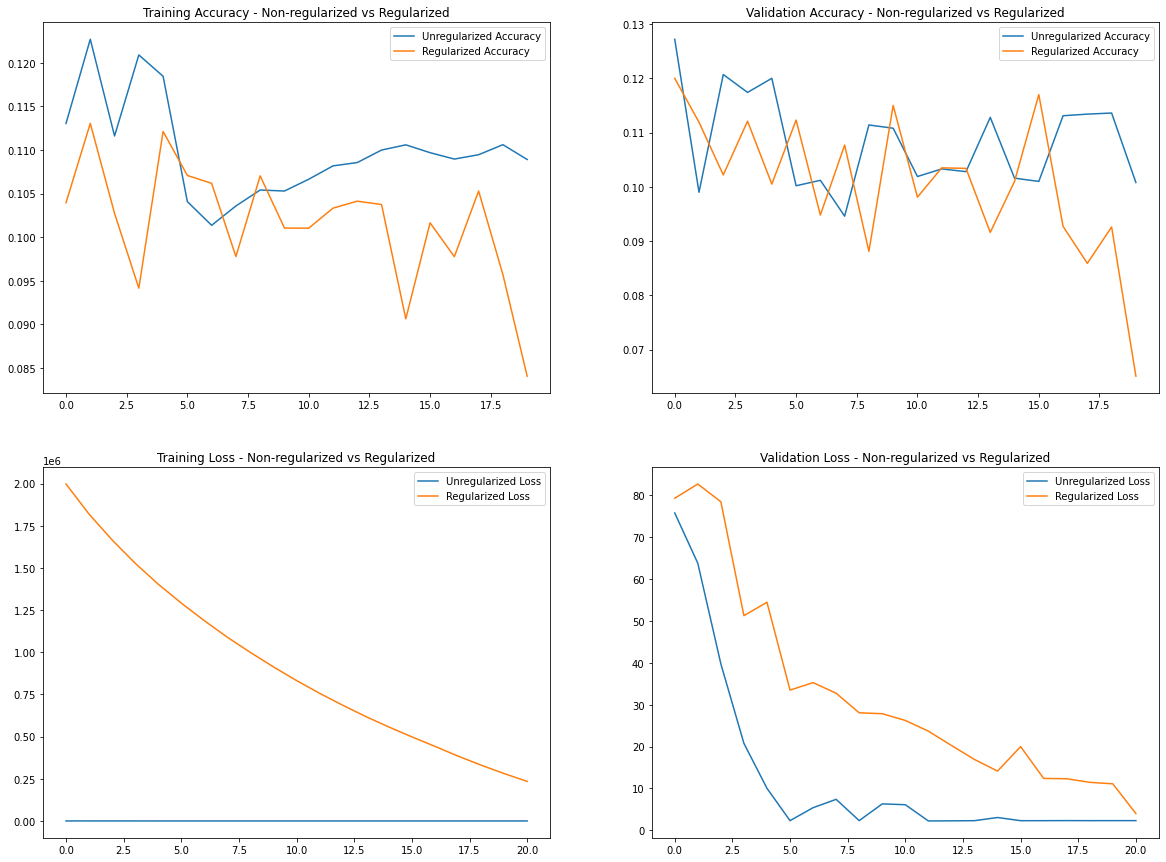

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(20,15))

ax[0,0].xlabel = 'Epoch'
ax[0,0].ylabel = 'Training Accuracy'
ax[0,0].set_title("Training Accuracy - Non-regularized vs Regularized")
ax[0,0].plot(np.arange(len(cnn_accuracy_history5)), cnn_accuracy_history5, label='Unregularized Accuracy')
ax[0,0].plot(np.arange(len(cnn_accuracy_history6)), cnn_accuracy_history6, label='Regularized Accuracy')  
ax[0,0].legend()

ax[0,1].xlabel = 'Epoch'
ax[0,1].ylabel = 'Validation Accuracy'
ax[0,1].set_title("Validation Accuracy - Non-regularized vs Regularized")
ax[0,1].plot(np.arange(len(cnn_val_accuracy_history5)), cnn_val_accuracy_history5, label='Unregularized Accuracy')
ax[0,1].plot(np.arange(len(cnn_val_accuracy_history6)), cnn_val_accuracy_history6, label='Regularized Accuracy')  
ax[0,1].legend()

ax[1,0].xlabel = 'Epoch'
ax[1,0].ylabel = 'Training Loss'
ax[1,0].set_title("Training Loss - Non-regularized vs Regularized")
ax[1,0].plot(np.arange(len(cnn_loss_history5)), cnn_loss_history5, label='Unregularized Loss')
ax[1,0].plot(np.arange(len(cnn_loss_history6)), cnn_loss_history6, label='Regularized Loss')  
ax[1,0].legend()

ax[1,1].xlabel = 'Epoch'
ax[1,1].ylabel = 'Validation Loss'
ax[1,1].set_title("Validation Loss - Non-regularized vs Regularized")
ax[1,1].plot(np.arange(len(cnn_val_loss_history5)), cnn_val_loss_history5, label='Unregularized Loss')
ax[1,1].plot(np.arange(len(cnn_val_loss_history6)), cnn_val_loss_history6, label='Regularized Loss')  
ax[1,1].legend()

plt.show()

/home/alboz/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/alboz/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/alboz/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/albo

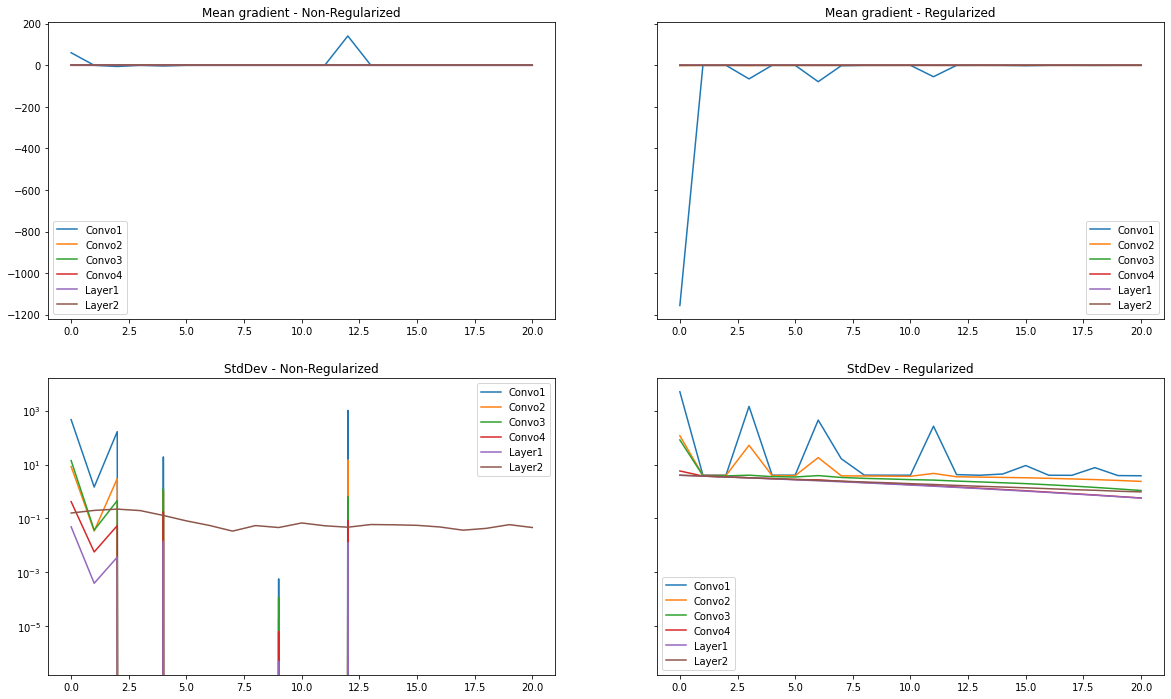

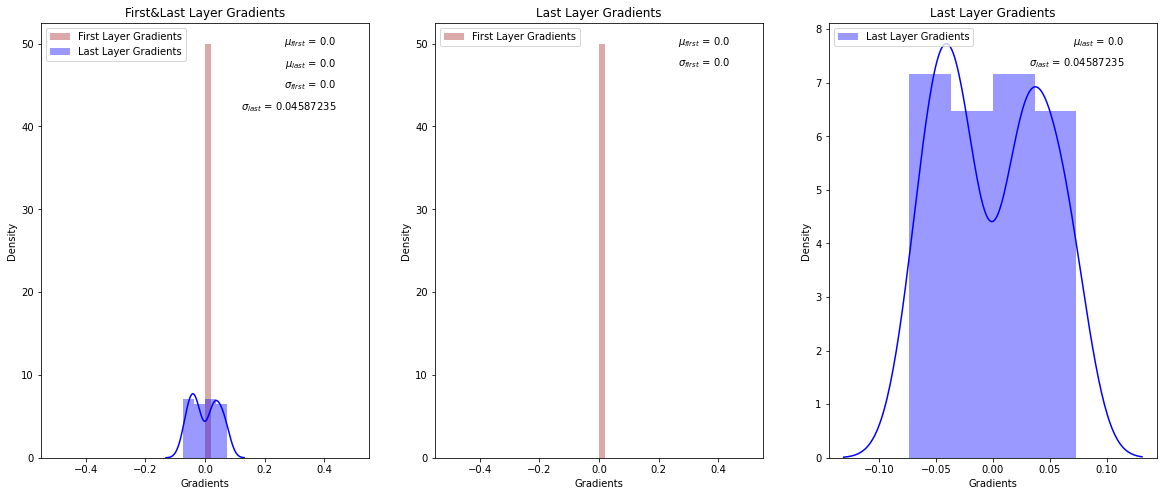

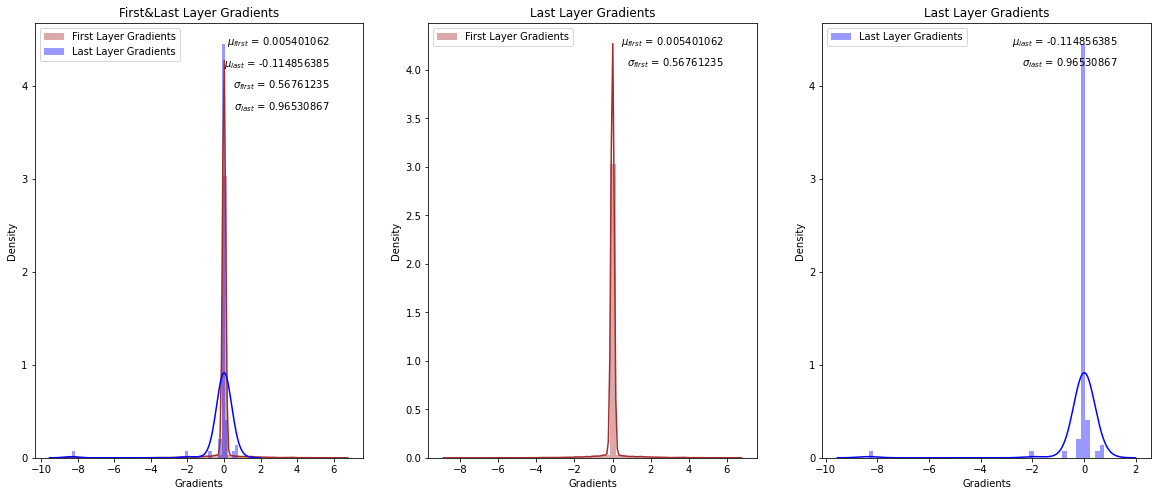

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(20, 12), sharey="row")
    
ax[0,0].set_title("Mean gradient - Non-Regularized")
for key in cnn_grad_history5[0]:
    ax[0,0].plot(range(len(cnn_grad_history5)), [w[key].mean() for w in cnn_grad_history5], label=key)
ax[0,0].legend()

ax[1,0].set_title("StdDev - Non-Regularized")
for key in cnn_grad_history5[0]:
    ax[1,0].semilogy(range(len(cnn_grad_history5)), [w[key].std() for w in cnn_grad_history5], label=key)
ax[1,0].legend()

ax[0,1].set_title("Mean gradient - Regularized")
for key in cnn_grad_history6[0]:
    ax[0,1].plot(range(len(cnn_grad_history6)), [w[key].mean() for w in cnn_grad_history6], label=key)
ax[0,1].legend()

ax[1,1].set_title("StdDev - Regularized")
for key in cnn_grad_history6[0]:
    ax[1,1].semilogy(range(len(cnn_grad_history6)), [w[key].std() for w in cnn_grad_history6], label=key)
ax[1,1].legend()


#First Layer and Last Layer Gradients' Distribution at the end of the Learning Process

plot_gradient_first_last(cnn_grad_history5)
plot_gradient_first_last(cnn_grad_history6)


### 2.5 - Uniform Large-Parameters Regime

Configuration:

* **Small CNN:** to check that the large parameters is indipendent of how many layers the network has. 


* **Activation Functions:** $tanh$


* **Initialization:** $Uniform(-10,10)$ --> Very Large Parameters Regime


* **Loss:** Sparse Categorical Cross-Entropy


* **Learning Algorithm:** Adam --> so as to ensure the fastest convergence and isolate the issue of Large Parameters Regime.

**RESULTS:** L2 completely outperforms other models.

In [ ]:
#UnRegularized Uniform - Large Parameters Regime

# Model input shape
input_shape = (28, 28, 1)

#Hyperparameters
epochs = 20
r = 0.0
batch_size = 32
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
loss= tf.keras.losses.SparseCategoricalCrossentropy()
metric = tf.keras.metrics.SparseCategoricalAccuracy()


model = make_CNNnet(input_shape=input_shape, activation = 'tanh',
                  predicter = 'softmax', 
                  initializer = tf.keras.initializers.RandomUniform(-10,10,seed=1),
                  #initializer = tf.keras.initializers.GlorotUniform(seed = 1),
                  name = 'Layer', 
                  n_hidden=1, 
                  units = 8,
                  regularization_type='l2', 
                  regularization_value=r)

cnn_grad_history7, cnn_loss_history7, cnn_accuracy_history7, cnn_val_loss_history7, cnn_val_accuracy_history7, cnn_time7 = train_model(x_train_norm, y_train, x_test_norm, y_test,  model, epochs, optimizer, loss, metric, batch_size)

In [ ]:
#L2-Regularized Uniform - Large Parameters Regime

# Model input shape
input_shape = (28, 28, 1)

#Hyperparameters
epochs = 20
r = 0.1
batch_size = 32
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
loss= tf.keras.losses.SparseCategoricalCrossentropy()
metric = tf.keras.metrics.SparseCategoricalAccuracy()


model = make_CNNnet(input_shape=input_shape, activation = 'tanh',
                  predicter = 'softmax', 
                  initializer = tf.keras.initializers.RandomUniform(-10,10,seed=1),
                  #initializer = tf.keras.initializers.GlorotUniform(seed = 1),
                  name = 'Layer', 
                  n_hidden=1, 
                  units = 8,
                  regularization_type='l2', 
                  regularization_value=r)

cnn_grad_history8, cnn_loss_history8, cnn_accuracy_history8, cnn_val_loss_history8, cnn_val_accuracy_history8, cnn_time8 = train_model(x_train_norm, y_train, x_test_norm, y_test,  model, epochs, optimizer, loss, metric, batch_size)

In [ ]:
#L1-Regularized Uniform - Large Parameters Regime

# Model input shape
input_shape = (28, 28, 1)

#Hyperparameters
epochs = 20
r = 0.1
batch_size = 32
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
loss= tf.keras.losses.SparseCategoricalCrossentropy()
metric = tf.keras.metrics.SparseCategoricalAccuracy()


model = make_CNNnet(input_shape=input_shape, activation = 'tanh',
                  predicter = 'softmax', 
                  initializer = tf.keras.initializers.RandomUniform(-10,10,seed=1),
                  #initializer = tf.keras.initializers.GlorotUniform(seed = 1),
                  name = 'Layer', 
                  n_hidden=1, 
                  units = 8,
                  regularization_type='l1', 
                  regularization_value=r)

cnn_grad_history9, cnn_loss_history9, cnn_accuracy_history9, cnn_val_loss_history9, cnn_val_accuracy_history9, cnn_time9 = train_model(x_train_norm, y_train, x_test_norm, y_test,  model, epochs, optimizer, loss, metric, batch_size)

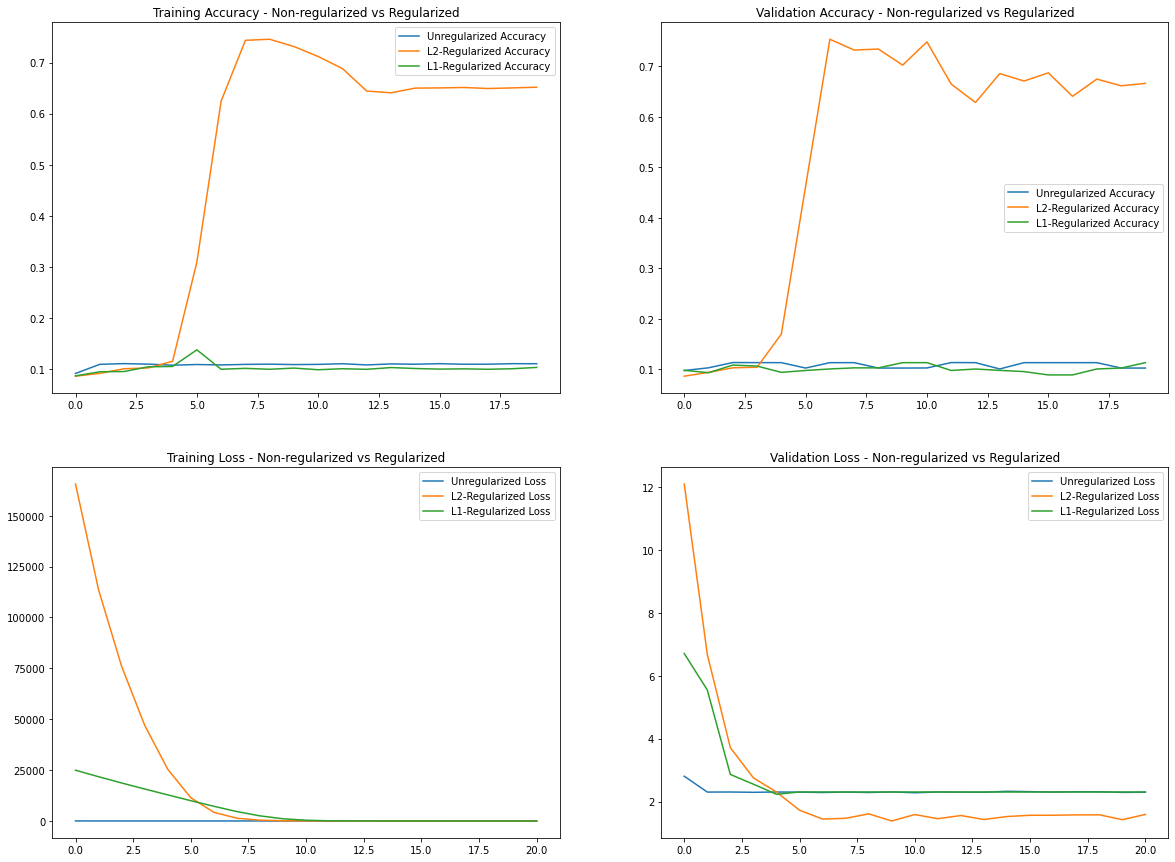

In [46]:
fig, ax = plt.subplots(2, 2, figsize=(20,15))

ax[0,0].xlabel = 'Epoch'
ax[0,0].ylabel = 'Training Accuracy'
ax[0,0].set_title("Training Accuracy - Non-regularized vs Regularized")
ax[0,0].plot(np.arange(len(cnn_accuracy_history7)), cnn_accuracy_history7, label='Unregularized Accuracy')
ax[0,0].plot(np.arange(len(cnn_accuracy_history8)), cnn_accuracy_history8, label='L2-Regularized Accuracy') 
ax[0,0].plot(np.arange(len(cnn_accuracy_history9)), cnn_accuracy_history9, label='L1-Regularized Accuracy')  
ax[0,0].legend()

ax[0,1].xlabel = 'Epoch'
ax[0,1].ylabel = 'Validation Accuracy'
ax[0,1].set_title("Validation Accuracy - Non-regularized vs Regularized")
ax[0,1].plot(np.arange(len(cnn_val_accuracy_history7)), cnn_val_accuracy_history7, label='Unregularized Accuracy')
ax[0,1].plot(np.arange(len(cnn_val_accuracy_history8)), cnn_val_accuracy_history8, label='L2-Regularized Accuracy')
ax[0,1].plot(np.arange(len(cnn_val_accuracy_history9)), cnn_val_accuracy_history9, label='L1-Regularized Accuracy')
ax[0,1].legend()

ax[1,0].xlabel = 'Epoch'
ax[1,0].ylabel = 'Training Loss'
ax[1,0].set_title("Training Loss - Non-regularized vs Regularized")
ax[1,0].plot(np.arange(len(cnn_loss_history7)), cnn_loss_history7, label='Unregularized Loss')
ax[1,0].plot(np.arange(len(cnn_loss_history8)), cnn_loss_history8, label='L2-Regularized Loss') 
ax[1,0].plot(np.arange(len(cnn_loss_history9)), cnn_loss_history9, label='L1-Regularized Loss')  
ax[1,0].legend()

ax[1,1].xlabel = 'Epoch'
ax[1,1].ylabel = 'Validation Loss'
ax[1,1].set_title("Validation Loss - Non-regularized vs Regularized")
ax[1,1].plot(np.arange(len(cnn_val_loss_history7)), cnn_val_loss_history7, label='Unregularized Loss')
ax[1,1].plot(np.arange(len(cnn_val_loss_history8)), cnn_val_loss_history8, label='L2-Regularized Loss')  
ax[1,1].plot(np.arange(len(cnn_val_loss_history9)), cnn_val_loss_history9, label='L1-Regularized Loss') 
ax[1,1].legend()

plt.show()

/home/alboz/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/alboz/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/alboz/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/albo

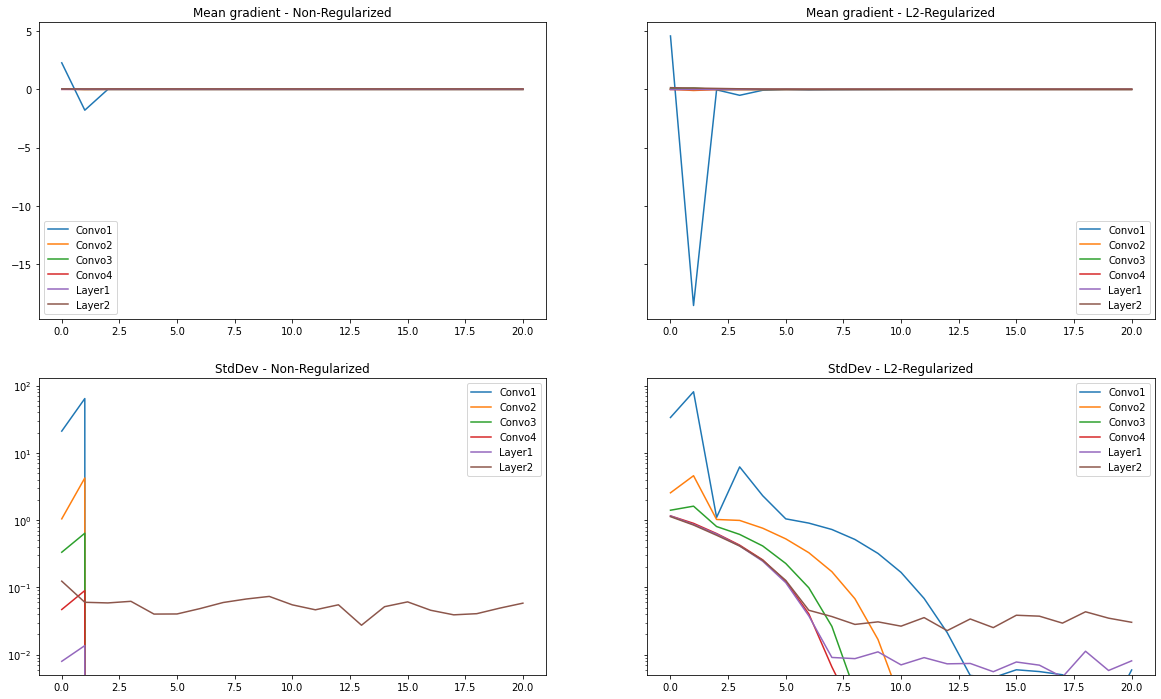

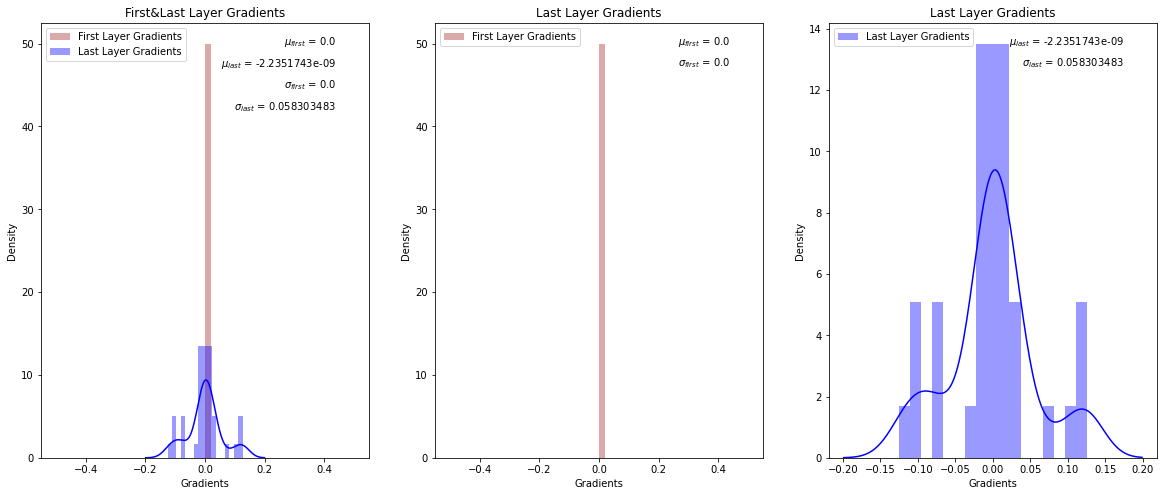

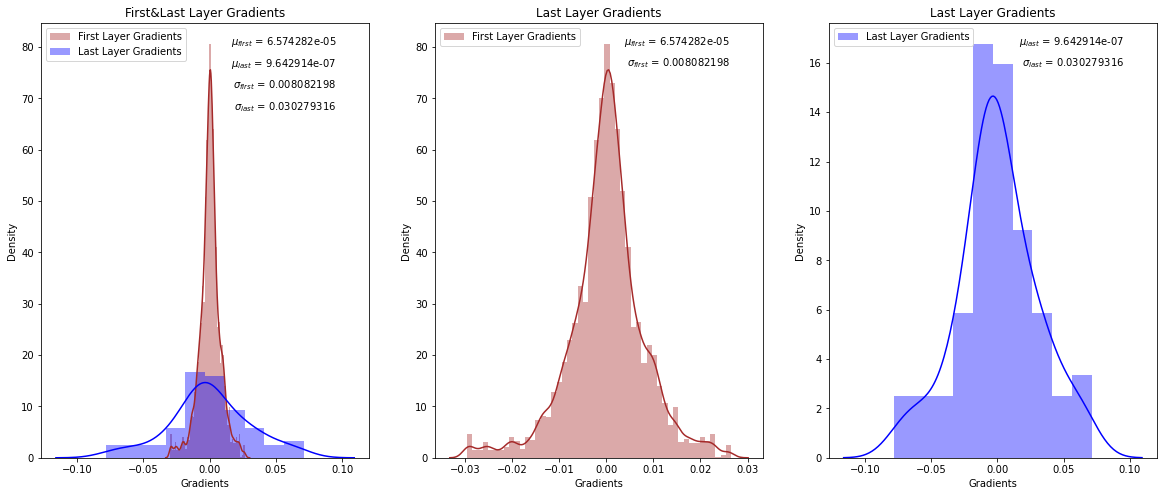

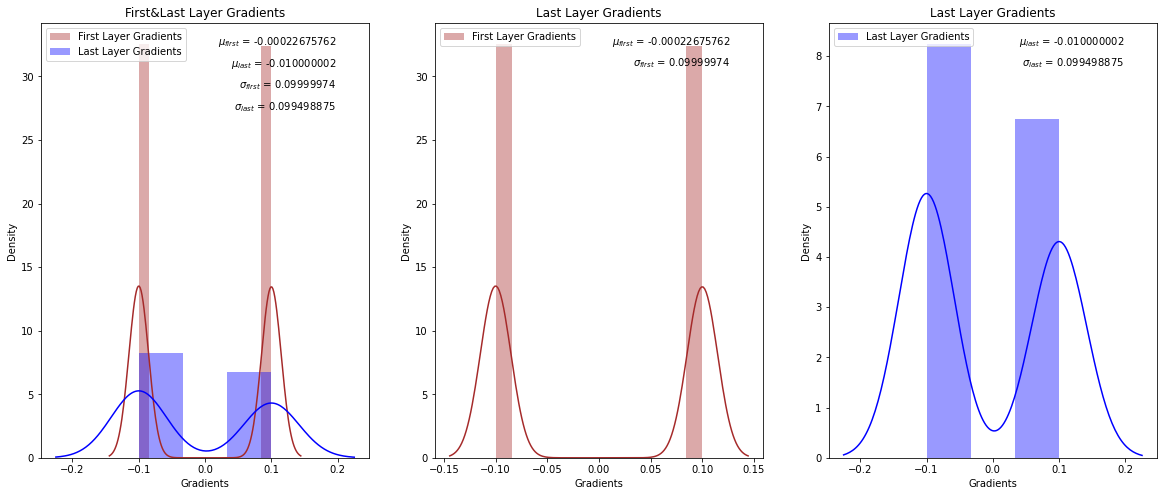

In [47]:
fig, ax = plt.subplots(2, 2, figsize=(20, 12), sharey="row")
    
ax[0,0].set_title("Mean gradient - Non-Regularized")
for key in cnn_grad_history7[0]:
    ax[0,0].plot(range(len(cnn_grad_history7)), [w[key].mean() for w in cnn_grad_history7], label=key)
ax[0,0].legend()

ax[1,0].set_title("StdDev - Non-Regularized")
for key in cnn_grad_history7[0]:
    ax[1,0].semilogy(range(len(cnn_grad_history7)), [w[key].std() for w in cnn_grad_history7], label=key)
ax[1,0].legend()

ax[0,1].set_title("Mean gradient - L2-Regularized")
for key in cnn_grad_history8[0]:
    ax[0,1].plot(range(len(cnn_grad_history8)), [w[key].mean() for w in cnn_grad_history8], label=key)
ax[0,1].legend()

ax[1,1].set_title("StdDev - L2-Regularized")
for key in cnn_grad_history8[0]:
    ax[1,1].semilogy(range(len(cnn_grad_history8)), [w[key].std() for w in cnn_grad_history8], label=key)
ax[1,1].legend()


#First Layer and Last Layer Gradients' Distribution at the end of the Learning Process

plot_gradient_first_last(cnn_grad_history7)
plot_gradient_first_last(cnn_grad_history8)
plot_gradient_first_last(cnn_grad_history9)


# 3 - Paper Model

### 3.1 - Initializations Comparison ($\sigma^2=1$ vs. $\sigma^2=10$)

Configuration:

* **Paper CNN:** to check that the large parameters is indipendent of how many layers the network has. 


* **Activation Functions:** $tanh$


* **Initialization:** 

    * $N(\omega, \mu = 0, \sigma^2 = 1)$ --> Not-Large Parameters Regime 
    * $N(\omega, \mu = 0, \sigma^2 = 10)$ --> Large Parameters Regime


* **Loss:** Unregularized Sparse Categorical Cross-Entropy (r = 0)


* **Learning Algorithm:** Adam --> so as to ensure the fastest convergence and isolate the issue of Large Parameters Regime.


Comparing to see if the Large Parameters Regime makes it more difficult to train the model. In fact, it does. The Training Accuracy improves slowly and we can clearly see that at the end of training the distribution of gradients in the first layer is peaked around zero with very small standard deviation. 

**Results:** 


In [ ]:
# Model input shape
input_shape = (28, 28, 1)

#Hyperparameters
epochs = 20
r = 0.0
batch_size = 32
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
loss= tf.keras.losses.SparseCategoricalCrossentropy()
metric = tf.keras.metrics.SparseCategoricalAccuracy()


model = paper_net(issue = 'parameters',
                  activation = 'tanh',
                  predicter = 'softmax', 
                  initializer = tf.keras.initializers.RandomNormal(0,10,seed=1),
                  #initializer = tf.keras.initializers.GlorotUniform(seed = 1),
                  name = 'Layer', 
                  regularization_type='l2', 
                  regularization_value=r)

#getWeights = RecordWeights(model)
#getWeights.on_epoch_end(-1) #Record initial weights

pap_grad_history, pap_loss_history, pap_accuracy_history, pap_val_loss_history, pap_val_accuracy_history, pap_time = train_model(x_train_norm, y_train, x_test_norm, y_test,  model, epochs, optimizer, loss, metric, batch_size)
#model.summary()



In [ ]:
# Model input shape
input_shape = (28, 28, 1)

#Hyperparameters
epochs = 20
r = 0.0
batch_size = 32
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
loss= tf.keras.losses.SparseCategoricalCrossentropy()
metric = tf.keras.metrics.SparseCategoricalAccuracy()


model2 = paper_net(issue = 'parameters',
                  activation = 'tanh',
                  predicter = 'softmax', 
                  initializer = tf.keras.initializers.RandomNormal(0,1,seed=1),
                  #initializer = tf.keras.initializers.GlorotUniform(seed = 1),
                  name = 'Layer', 
                  regularization_type='l2', 
                  regularization_value=r)

pap_grad_history2, pap_loss_history2, pap_accuracy_history2, pap_val_loss_history2, pap_val_accuracy_history2, pap_time2 = train_model(x_train_norm, y_train, x_test_norm, y_test,  model2, epochs, optimizer, loss, metric, batch_size)

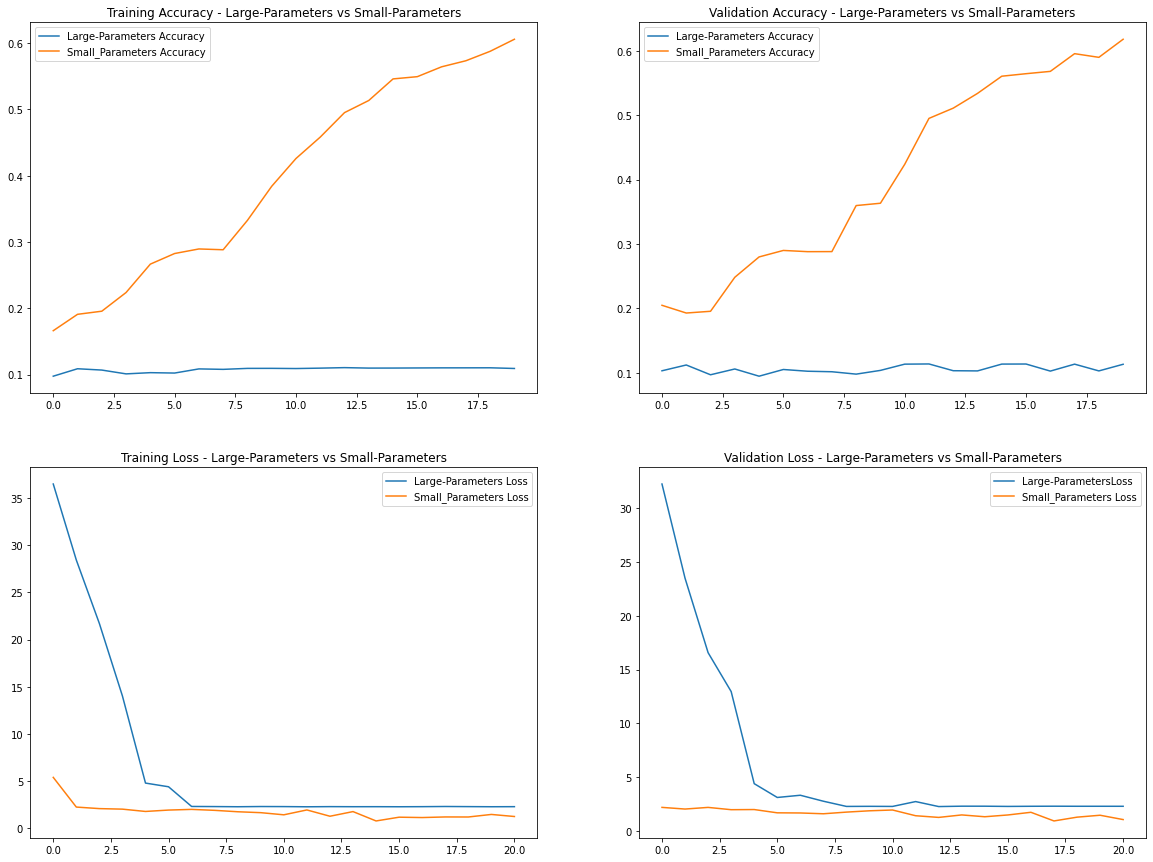

In [50]:
fig, ax = plt.subplots(2, 2, figsize=(20,15))

ax[0,0].xlabel = 'Epoch'
ax[0,0].ylabel = 'Training Accuracy'
ax[0,0].set_title("Training Accuracy - Large-Parameters vs Small-Parameters")
ax[0,0].plot(np.arange(len(pap_accuracy_history)), pap_accuracy_history, label='Large-Parameters Accuracy')
ax[0,0].plot(np.arange(len(pap_accuracy_history)), pap_accuracy_history2, label='Small_Parameters Accuracy')  
ax[0,0].legend()

ax[0,1].xlabel = 'Epoch'
ax[0,1].ylabel = 'Validation Accuracy'
ax[0,1].set_title("Validation Accuracy - Large-Parameters vs Small-Parameters")
ax[0,1].plot(np.arange(len(pap_val_accuracy_history)), pap_val_accuracy_history, label='Large-Parameters Accuracy')
ax[0,1].plot(np.arange(len(pap_val_accuracy_history)), pap_val_accuracy_history2, label='Small_Parameters Accuracy')  
ax[0,1].legend()

ax[1,0].xlabel = 'Epoch'
ax[1,0].ylabel = 'Training Loss'
ax[1,0].set_title("Training Loss - Large-Parameters vs Small-Parameters")
ax[1,0].plot(np.arange(len(pap_loss_history)), pap_loss_history, label='Large-Parameters Loss')
ax[1,0].plot(np.arange(len(pap_loss_history)), pap_loss_history2, label='Small_Parameters Loss')  
ax[1,0].legend()

ax[1,1].xlabel = 'Epoch'
ax[1,1].ylabel = 'Validation Loss'
ax[1,1].set_title("Validation Loss - Large-Parameters vs Small-Parameters")
ax[1,1].plot(np.arange(len(pap_val_loss_history)), pap_val_loss_history, label='Large-ParametersLoss')
ax[1,1].plot(np.arange(len(pap_val_loss_history)), pap_val_loss_history2, label='Small_Parameters Loss')  
ax[1,1].legend()

plt.show()

/home/alboz/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/alboz/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/alboz/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/albo

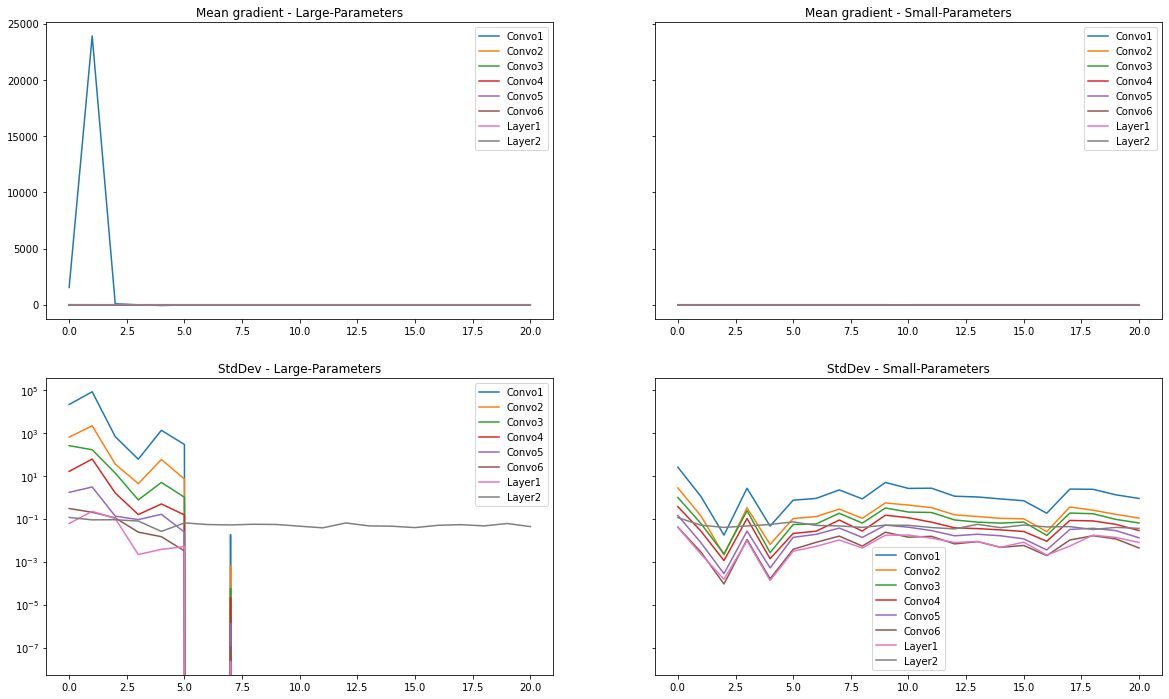

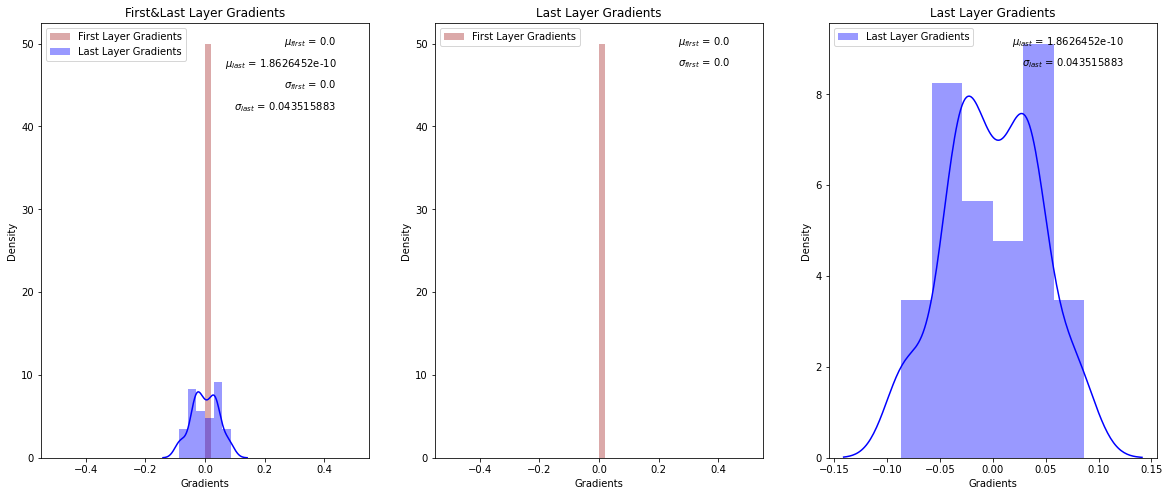

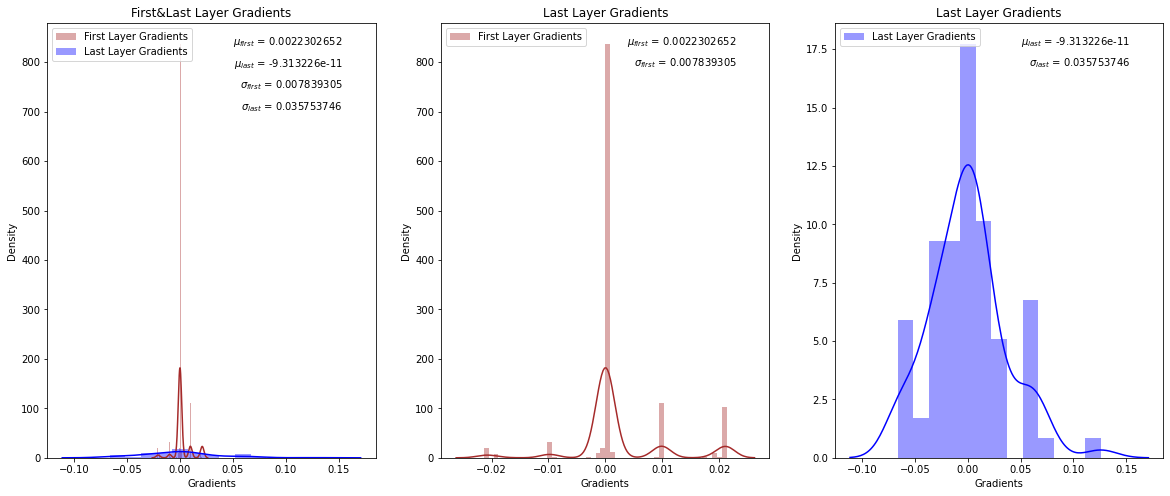

In [51]:
fig, ax = plt.subplots(2, 2, figsize=(20, 12), sharey = "row")
    
ax[0,0].set_title("Mean gradient - Large-Parameters")
for key in pap_grad_history[0]:
    ax[0,0].plot(range(len(pap_grad_history)), [w[key].mean() for w in pap_grad_history], label=key)
ax[0,0].legend()

ax[1,0].set_title("StdDev - Large-Parameters")
for key in pap_grad_history[0]:
    ax[1,0].semilogy(range(len(pap_grad_history)), [w[key].std() for w in pap_grad_history], label=key)
ax[1,0].legend()

ax[0,1].set_title("Mean gradient - Small-Parameters")
for key in pap_grad_history2[0]:
    ax[0,1].plot(range(len(pap_grad_history2)), [w[key].mean() for w in pap_grad_history2], label=key)
ax[0,1].legend()

ax[1,1].set_title("StdDev - Small-Parameters")
for key in pap_grad_history2[0]:
    ax[1,1].semilogy(range(len(pap_grad_history2)), [w[key].std() for w in pap_grad_history2], label=key)
ax[1,1].legend()


#First Layer and Last Layer Gradients' Distribution at the end of the Learning Process

plot_gradient_first_last(pap_grad_history ,paper=True)
plot_gradient_first_last(pap_grad_history2,paper=True)

### 3.2 - Adding Regularization

Configuration:

* **Paper CNN:** to check that the large parameters is indipendent of how many layers the network has. 


* **Activation Functions:** $tanh$


* **Initialization:** 

    * $N(\omega, \mu = 0, \sigma^2 = 10)$ --> Large Parameters Regime


* **Loss:** Sparse Categorical Cross-Entropy (r = 0)


* **Learning Algorithm:** Adam --> so as to ensure the fastest convergence and isolate the issue of Large Parameters Regime.

* **Regularization:** L2 (r=0.01)

Adding regularization to see how the results change when regularization is added. Does it perform better compared to the non regularized case?

**Results:**



In [ ]:
# Model input shape
input_shape = (28, 28, 1)

#Hyperparameters
epochs = 20
r = 0.1
batch_size = 32
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
loss= tf.keras.losses.SparseCategoricalCrossentropy()
metric = tf.keras.metrics.SparseCategoricalAccuracy()


model = paper_net(issue = 'parameters',
                  activation = 'tanh',
                  predicter = 'softmax', 
                  initializer = tf.keras.initializers.RandomNormal(0,10,seed=1),
                  #initializer = tf.keras.initializers.GlorotUniform(seed = 1),
                  name = 'Layer', 
                  regularization_type='l2', 
                  regularization_value=r)

pap_grad_history3, pap_loss_history3, pap_accuracy_history3, pap_val_loss_history3, pap_val_accuracy_history3, pap_time3 = train_model(x_train_norm, y_train, x_test_norm, y_test,  model, epochs, optimizer, loss, metric, batch_size)

In [ ]:
# Model input shape
input_shape = (28, 28, 1)

#Hyperparameters
epochs = 20
r = 0.01
batch_size = 32
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
loss= tf.keras.losses.SparseCategoricalCrossentropy()
metric = tf.keras.metrics.SparseCategoricalAccuracy()


model = paper_net(issue = 'parameters',
                  activation = 'tanh',
                  predicter = 'softmax', 
                  initializer = tf.keras.initializers.RandomNormal(0,10,seed=1),
                  #initializer = tf.keras.initializers.GlorotUniform(seed = 1),
                  name = 'Layer', 
                  regularization_type='l1', 
                  regularization_value=r)

pap_grad_history4, pap_loss_history4, pap_accuracy_history4, pap_val_loss_history4, pap_val_accuracy_history4, pap_time4 = train_model(x_train_norm, y_train, x_test_norm, y_test,  model, epochs, optimizer, loss, metric, batch_size)

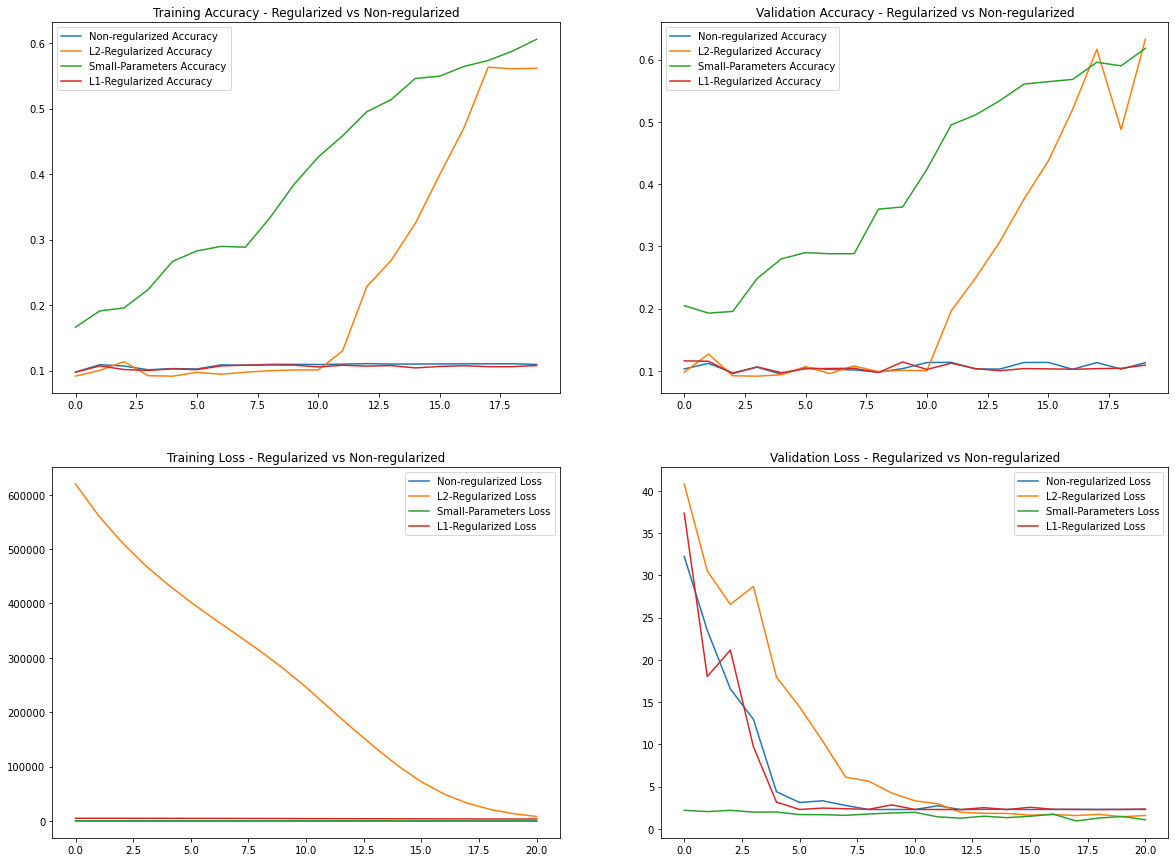

In [54]:
fig, ax = plt.subplots(2, 2, figsize=(20,15))

ax[0,0].xlabel = 'Epoch'
ax[0,0].ylabel = 'Training Accuracy'
ax[0,0].set_title("Training Accuracy - Regularized vs Non-regularized")
ax[0,0].plot(np.arange(len(pap_accuracy_history)), pap_accuracy_history, label='Non-regularized Accuracy')
ax[0,0].plot(np.arange(len(pap_accuracy_history3)), pap_accuracy_history3, label='L2-Regularized Accuracy')
ax[0,0].plot(np.arange(len(pap_accuracy_history2)), pap_accuracy_history2, label='Small-Parameters Accuracy') 
ax[0,0].plot(np.arange(len(pap_accuracy_history4)), pap_accuracy_history4, label='L1-Regularized Accuracy') 
ax[0,0].legend()

ax[0,1].xlabel = 'Epoch'
ax[0,1].ylabel = 'Validation Accuracy'
ax[0,1].set_title("Validation Accuracy - Regularized vs Non-regularized")
ax[0,1].plot(np.arange(len(pap_val_accuracy_history)), pap_val_accuracy_history, label='Non-regularized Accuracy')
ax[0,1].plot(np.arange(len(pap_val_accuracy_history3)), pap_val_accuracy_history3, label='L2-Regularized Accuracy')
ax[0,1].plot(np.arange(len(pap_val_accuracy_history2)), pap_val_accuracy_history2, label='Small-Parameters Accuracy')  
ax[0,1].plot(np.arange(len(pap_val_accuracy_history4)), pap_val_accuracy_history4, label='L1-Regularized Accuracy')
ax[0,1].legend()

ax[1,0].xlabel = 'Epoch'
ax[1,0].ylabel = 'Training Loss'
ax[1,0].set_title("Training Loss - Regularized vs Non-regularized")
ax[1,0].plot(np.arange(len(pap_loss_history)), pap_loss_history, label='Non-regularized Loss')
ax[1,0].plot(np.arange(len(pap_loss_history3)), pap_loss_history3, label='L2-Regularized Loss')
ax[1,0].plot(np.arange(len(pap_loss_history)), pap_loss_history2, label='Small-Parameters Loss')  
ax[1,0].plot(np.arange(len(pap_loss_history4)), pap_loss_history4, label='L1-Regularized Loss')
ax[1,0].legend()

ax[1,1].xlabel = 'Epoch'
ax[1,1].ylabel = 'Validation Loss'
ax[1,1].set_title("Validation Loss - Regularized vs Non-regularized")
ax[1,1].plot(np.arange(len(pap_val_loss_history)), pap_val_loss_history, label='Non-regularized Loss')
ax[1,1].plot(np.arange(len(pap_val_loss_history3)), pap_val_loss_history3, label='L2-Regularized Loss')
ax[1,1].plot(np.arange(len(pap_val_loss_history)), pap_val_loss_history2, label='Small-Parameters Loss')
ax[1,1].plot(np.arange(len(pap_val_loss_history4)), pap_val_loss_history4, label='L1-Regularized Loss')
ax[1,1].legend()

plt.show()

/home/alboz/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/alboz/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/alboz/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/albo

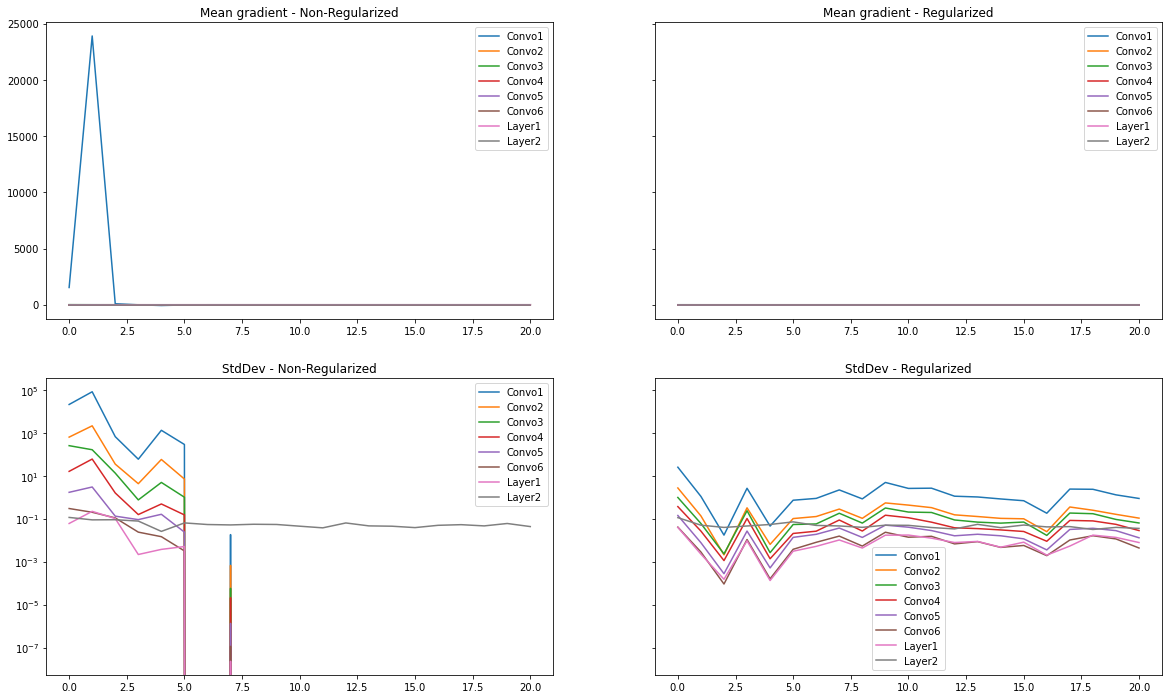

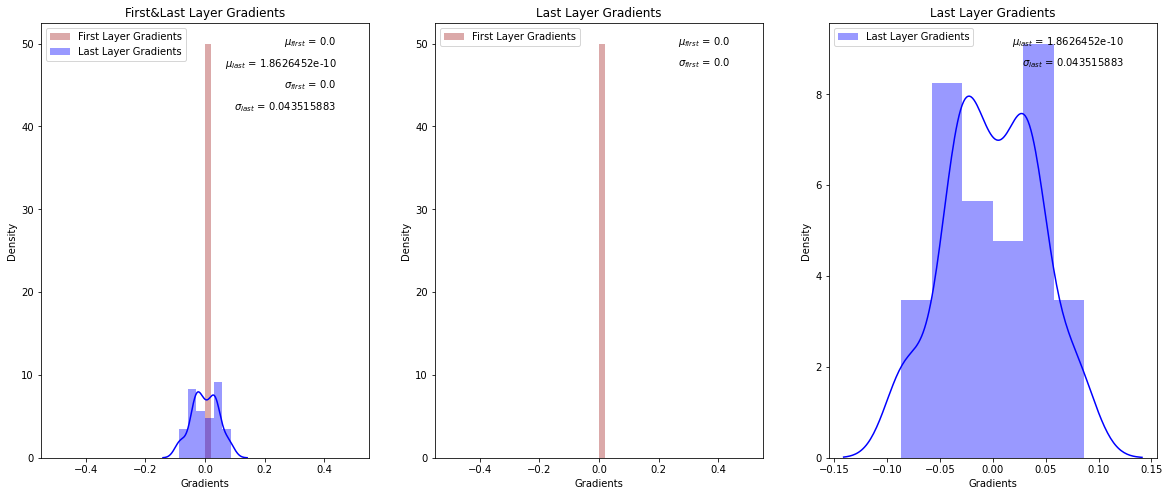

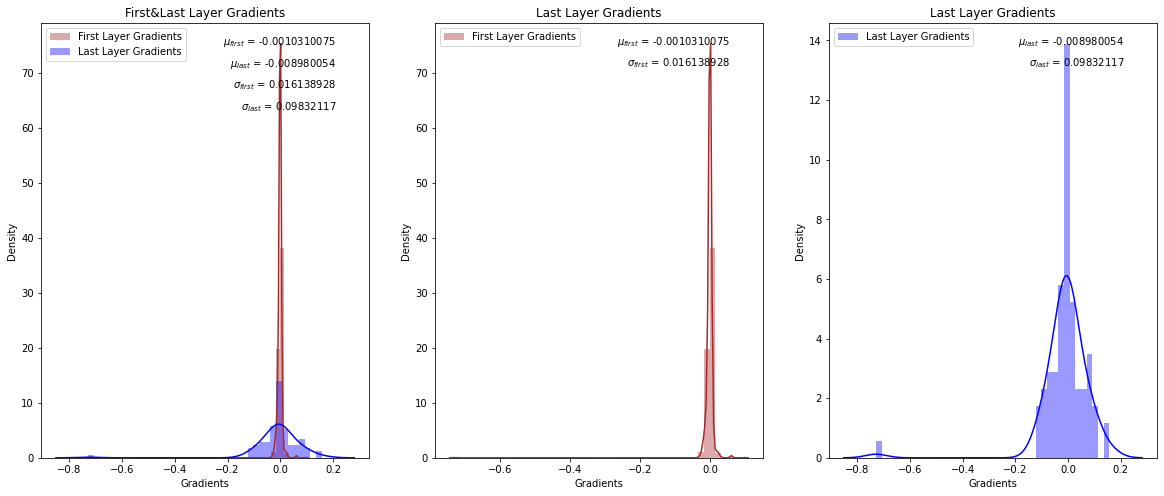

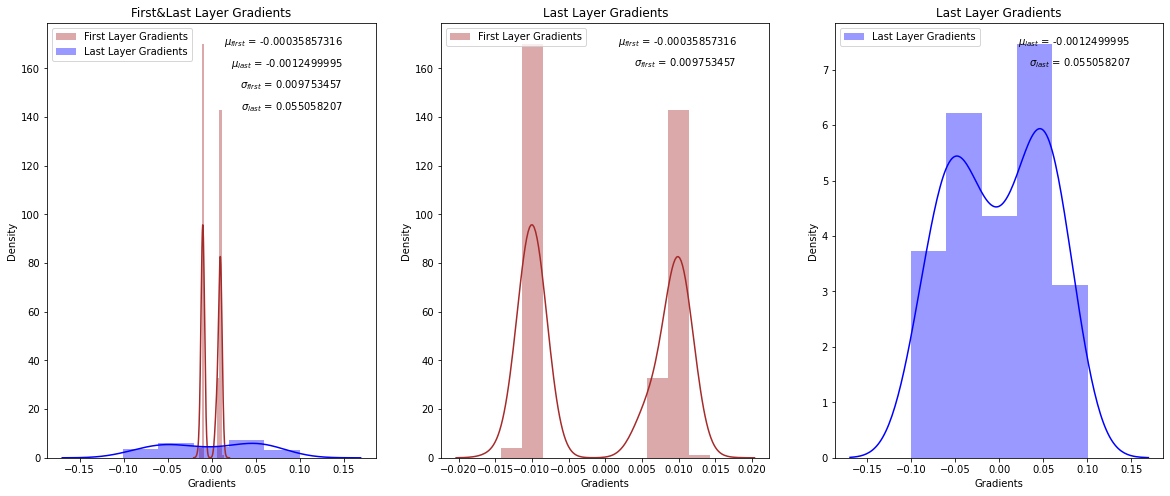

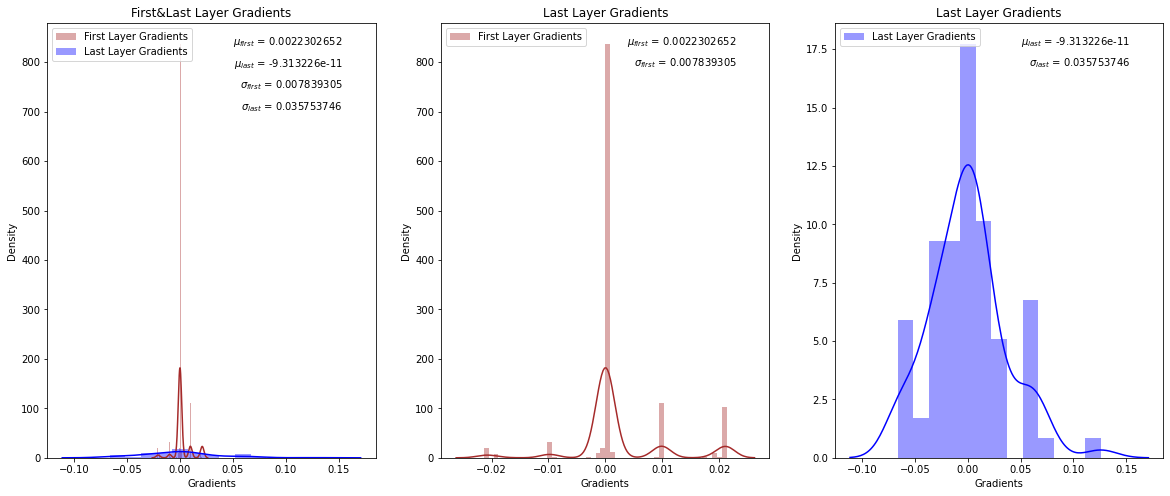

In [55]:
fig, ax = plt.subplots(2, 2, figsize=(20, 12), sharey="row")
    
ax[0,0].set_title("Mean gradient - Non-Regularized")
for key in pap_grad_history[0]:
    ax[0,0].plot(range(len(pap_grad_history)), [w[key].mean() for w in pap_grad_history], label=key)
ax[0,0].legend()

ax[1,0].set_title("StdDev - Non-Regularized")
for key in pap_grad_history[0]:
    ax[1,0].semilogy(range(len(pap_grad_history)), [w[key].std() for w in pap_grad_history], label=key)
ax[1,0].legend()

ax[0,1].set_title("Mean gradient - Regularized")
for key in pap_grad_history2[0]:
    ax[0,1].plot(range(len(pap_grad_history3)), [w[key].mean() for w in pap_grad_history2], label=key)
ax[0,1].legend()

ax[1,1].set_title("StdDev - Regularized")
for key in pap_grad_history2[0]:
    ax[1,1].semilogy(range(len(pap_grad_history3)), [w[key].std() for w in pap_grad_history2], label=key)
ax[1,1].legend()


#First Layer and Last Layer Gradients' Distribution at the end of the Learning Process

plot_gradient_first_last(pap_grad_history ,paper=True)
plot_gradient_first_last(pap_grad_history3,paper=True)
plot_gradient_first_last(pap_grad_history4,paper=True)
plot_gradient_first_last(pap_grad_history2,paper=True)

### 3.3 - Finding the best Regularization parameter

Since Regularization seems not to be working with the current values of $r$, let's see for which value it performs best and see whether there is, actually, a regularization regime in which the vanishing gradient issue is fixed.

**Results:** in a very wide range of regularization parameters $ r\in[10^{-3},10^2] $ [to be continued]

In [56]:
# Model input shape
input_shape = (28, 28, 1)

#Hyperparameters
epochs = 20
#r = 0.01
batch_size = 32
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
metric = tf.keras.metrics.SparseCategoricalAccuracy()

pap_grad_history_l2 = []
pap_loss_history_l2 =  [] 
pap_accuracy_history_l2 = [] 
pap_val_loss_history_l2 = [] 
pap_val_accuracy_history_l2 = [] 

pap_grad_history_l1 = []
pap_loss_history_l1 =  [] 
pap_accuracy_history_l1 = [] 
pap_val_loss_history_l1 = [] 
pap_val_accuracy_history_l1 = [] 

In [ ]:
reg = np.logspace(-3, 2, 10)
print('--- Initializing Regularization Loop ---')
index = 0
for r in reg:
    from time import time
    print('r = ', r, '------- #',index+1 , 'of', len(reg))
    model = paper_net(issue = 'parameters',
                  activation = 'tanh',
                  predicter = 'softmax', 
                  initializer = tf.keras.initializers.RandomNormal(0,10,seed=1),
                  #initializer = tf.keras.initializers.GlorotUniform(seed = 1),
                  name = 'Layer', 
                  regularization_type='l2', 
                  regularization_value=r)
    
    model2 = paper_net(issue = 'parameters',
                  activation = 'tanh',
                  predicter = 'softmax', 
                  initializer = tf.keras.initializers.RandomNormal(0,10,seed=1),
                  #initializer = tf.keras.initializers.GlorotUniform(seed = 1),
                  name = 'Layer', 
                  regularization_type='l1', 
                  regularization_value=r)
    
    grad, train_loss, train_accuracy, val_loss, val_accuracy, time = train_model(x_train_norm, y_train, x_test_norm, y_test,  model, epochs, optimizer, loss, metric, batch_size)
    pap_grad_history_l2.append(grad)
    pap_loss_history_l2.append(train_loss)
    pap_accuracy_history_l2.append(train_accuracy)
    pap_val_loss_history_l2.append(val_loss) 
    pap_val_accuracy_history_l2.append(val_accuracy)
    

    grad, train_loss, train_accuracy, val_loss, val_accuracy, time = train_model(x_train_norm, y_train, x_test_norm, y_test,  model2, epochs, optimizer, loss, metric, batch_size)
    pap_grad_history_l1.append(grad)
    pap_loss_history_l1.append(train_loss)
    pap_accuracy_history_l1.append(train_accuracy)
    pap_val_loss_history_l1.append(val_loss) 
    pap_val_accuracy_history_l1.append(val_accuracy)
    index+=1
    

#getWeights = RecordWeights(model)
#getWeights.on_epoch_end(-1) #Record initial weights

#grad_history4, loss_history4, accuracy_history4, val_loss_history4, val_accuracy_history4, time4 = train_model(x_train, y_train, x_test, y_test,  model, epochs, optimizer, loss, metric, batch_size)
#model.summary()

In [ ]:
#L2
fig, ax = plt.subplots(2, 2, figsize=(20,15))

ax[0,0].xlabel = 'Epoch'
ax[0,0].ylabel = 'Training Accuracy'
ax[0,0].set_title("Training Accuracy - Regularized vs Non-regularized")
ax[0,0].plot(np.arange(len(pap_accuracy_history)), pap_accuracy_history, label='Non-regularized Accuracy')
ax[0,0].plot(np.arange(len(pap_accuracy_history2)), pap_accuracy_history2, label='Small-Parameters Accuracy')  
i=0
for r in reg:
    ax[0,0].plot(np.arange(len(pap_accuracy_history_l2[i])), pap_accuracy_history_l2[i], label='L2-regularized r='+str(round(r, 3))) 
    i+=1
ax[0,0].legend()

ax[0,1].xlabel = 'Epoch'
ax[0,1].ylabel = 'Validation Accuracy'
ax[0,1].set_title("Validation Accuracy - Regularized vs Non-regularized")
ax[0,1].plot(np.arange(len(pap_val_accuracy_history)), pap_val_accuracy_history, label='Non-regularized Accuracy')
ax[0,1].plot(np.arange(len(pap_val_accuracy_history2)), pap_val_accuracy_history2, label='Small-Parameters Accuracy') 
i=0
for r in reg:
    ax[0,1].plot(np.arange(len(pap_val_accuracy_history_l2[i])), pap_val_accuracy_history_l2[i], label='L2-regularized r='+str(round(r, 3))) 
    i+=1
ax[0,1].legend()

ax[1,0].xlabel = 'Epoch'
ax[1,0].ylabel = 'Training Loss'
ax[1,0].set_title("Training Loss - Regularized vs Non-regularized")
ax[1,0].plot(np.arange(len(pap_loss_history)), pap_loss_history, label='Non-regularized Loss')
ax[1,0].plot(np.arange(len(pap_loss_history)), pap_loss_history2, label='Small-Parameters Loss')  
i=0
for r in reg:
    ax[1,0].plot(np.arange(len(pap_loss_history_l2[i])), pap_loss_history_l2[i], label='L2-regularized r='+str(round(r, 3))) 
    i+=1
ax[1,0].legend()

ax[1,1].xlabel = 'Epoch'
ax[1,1].ylabel = 'Validation Loss'
ax[1,1].set_title("Validation Loss - Regularized vs Non-regularized")
ax[1,1].plot(np.arange(len(pap_val_loss_history)), pap_val_loss_history, label='Non-regularized Loss')
ax[1,1].plot(np.arange(len(pap_val_loss_history)), pap_val_loss_history2, label='Small-Parameters Loss')
i=0
for r in reg:
    ax[1,1].plot(np.arange(len(pap_val_loss_history_l2[i])), pap_val_loss_history_l2[i], label='L2-regularized r='+str(round(r, 3))) 
    i+=1
ax[1,1].legend()

plt.show()

In [ ]:
#L1
fig, ax = plt.subplots(2, 2, figsize=(20,15))

ax[0,0].xlabel = 'Epoch'
ax[0,0].ylabel = 'Training Accuracy'
ax[0,0].set_title("Training Accuracy - Regularized vs Non-regularized")
ax[0,0].plot(np.arange(len(pap_accuracy_history)), pap_accuracy_history, label='Non-regularized Accuracy')
ax[0,0].plot(np.arange(len(pap_accuracy_history2)), pap_accuracy_history2, label='Small-Parameters Accuracy')  
i=0
for r in reg:
    ax[0,0].plot(np.arange(len(pap_accuracy_history_l1[i])), pap_accuracy_history_l1[i], label='L1-regularized r='+str(round(r, 3))) 
    i+=1
ax[0,0].legend()

ax[0,1].xlabel = 'Epoch'
ax[0,1].ylabel = 'Validation Accuracy'
ax[0,1].set_title("Validation Accuracy - Regularized vs Non-regularized")
ax[0,1].plot(np.arange(len(pap_val_accuracy_history)), pap_val_accuracy_history, label='Non-regularized Accuracy')
ax[0,1].plot(np.arange(len(pap_val_accuracy_history2)), pap_val_accuracy_history2, label='Small-Parameters Accuracy') 
i=0
for r in reg:
    ax[0,1].plot(np.arange(len(pap_val_accuracy_history_l1[i])), pap_val_accuracy_history_l1[i], label='L1-regularized r='+str(round(r, 3))) 
    i+=1
ax[0,1].legend()

ax[1,0].xlabel = 'Epoch'
ax[1,0].ylabel = 'Training Loss'
ax[1,0].set_title("Training Loss - Regularized vs Non-regularized")
ax[1,0].plot(np.arange(len(pap_loss_history)), pap_loss_history, label='Non-regularized Loss')
ax[1,0].plot(np.arange(len(pap_loss_history)), pap_loss_history2, label='Small-Parameters Loss')  
i=0
for r in reg:
    ax[1,0].plot(np.arange(len(pap_loss_history_l1[i])), pap_loss_history_l1[i], label='L1-regularized r='+str(round(r, 3))) 
    i+=1
ax[1,0].legend()

ax[1,1].xlabel = 'Epoch'
ax[1,1].ylabel = 'Validation Loss'
ax[1,1].set_title("Validation Loss - Regularized vs Non-regularized")
ax[1,1].plot(np.arange(len(pap_val_loss_history)), pap_val_loss_history, label='Non-regularized Loss')
ax[1,1].plot(np.arange(len(pap_val_loss_history)), pap_val_loss_history2, label='Small-Parameters Loss')
i=0
for r in reg:
    ax[1,1].plot(np.arange(len(pap_val_loss_history_l1[i])), pap_val_loss_history_l1[i], label='L1-regularized r='+str(round(r, 3))) 
    i+=1
ax[1,1].legend()

plt.show()

### 3.4 - Super-large Parameters Regime

Configuration:

* **Paper CNN:** to check that the large parameters is indipendent of how many layers the network has. 


* **Activation Functions:** $tanh$


* **Initialization:** $N(\omega, \mu = 0, \sigma^2 = 20)$ --> Very Large Parameters Regime


* **Loss:** Sparse Categorical Cross-Entropy


* **Learning Algorithm:** Adam --> so as to ensure the fastest convergence and isolate the issue of Large Parameters Regime.

**RESULTS:** 

In [ ]:
# Model input shape
input_shape = (28, 28, 1)

#Hyperparameters
epochs = 20
r = 0.0
batch_size = 32
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
loss= tf.keras.losses.SparseCategoricalCrossentropy()
metric = tf.keras.metrics.SparseCategoricalAccuracy()


model = paper_net(issue = 'parameters',
                  activation = 'tanh',
                  predicter = 'softmax', 
                  initializer = tf.keras.initializers.RandomNormal(0,20,seed=1),
                  #initializer = tf.keras.initializers.GlorotUniform(seed = 1),
                  name = 'Layer', 
                  regularization_type='l2', 
                  regularization_value=r)

pap_grad_history5, pap_loss_history5, pap_accuracy_history5, pap_val_loss_history5, pap_val_accuracy_history5, pap_time5 = train_model(x_train_norm, y_train, x_test_norm, y_test,  model, epochs, optimizer, loss, metric, batch_size)

In [ ]:
# Model input shape
input_shape = (28, 28, 1)

#Hyperparameters
epochs = 20
r = 0.1
batch_size = 32
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
loss= tf.keras.losses.SparseCategoricalCrossentropy()
metric = tf.keras.metrics.SparseCategoricalAccuracy()


model = paper_net(issue = 'parameters',
                  activation = 'tanh',
                  predicter = 'softmax', 
                  initializer = tf.keras.initializers.RandomNormal(0,20,seed=1),
                  #initializer = tf.keras.initializers.GlorotUniform(seed = 1),
                  name = 'Layer', 
                  regularization_type='l2', 
                  regularization_value=r)

pap_grad_history6, pap_loss_history6, pap_accuracy_history6, pap_val_loss_history6, pap_val_accuracy_history6, pap_time6 = train_model(x_train_norm, y_train, x_test_norm, y_test,  model, epochs, optimizer, loss, metric, batch_size)

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(20,15))

ax[0,0].xlabel = 'Epoch'
ax[0,0].ylabel = 'Training Accuracy'
ax[0,0].set_title("Training Accuracy - Non-regularized vs Regularized")
ax[0,0].plot(np.arange(len(pap_accuracy_history5)), pap_accuracy_history5, label='Unregularized Accuracy')
ax[0,0].plot(np.arange(len(pap_accuracy_history6)), pap_accuracy_history6, label='Regularized Accuracy')  
ax[0,0].legend()

ax[0,1].xlabel = 'Epoch'
ax[0,1].ylabel = 'Validation Accuracy'
ax[0,1].set_title("Validation Accuracy - Non-regularized vs Regularized")
ax[0,1].plot(np.arange(len(pap_val_accuracy_history5)), pap_val_accuracy_history5, label='Unregularized Accuracy')
ax[0,1].plot(np.arange(len(pap_val_accuracy_history6)), pap_val_accuracy_history6, label='Regularized Accuracy')  
ax[0,1].legend()

ax[1,0].xlabel = 'Epoch'
ax[1,0].ylabel = 'Training Loss'
ax[1,0].set_title("Training Loss - Non-regularized vs Regularized")
ax[1,0].plot(np.arange(len(pap_loss_history5)), pap_loss_history5, label='Unregularized Loss')
ax[1,0].plot(np.arange(len(pap_loss_history6)), pap_loss_history6, label='Regularized Loss')  
ax[1,0].legend()

ax[1,1].xlabel = 'Epoch'
ax[1,1].ylabel = 'Validation Loss'
ax[1,1].set_title("Validation Loss - Non-regularized vs Regularized")
ax[1,1].plot(np.arange(len(pap_val_loss_history5)), pap_val_loss_history5, label='Unregularized Loss')
ax[1,1].plot(np.arange(len(pap_val_loss_history6)), pap_val_loss_history6, label='Regularized Loss')  
ax[1,1].legend()

plt.show()

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(20, 12), sharey="row")
    
ax[0,0].set_title("Mean gradient - Non-Regularized")
for key in pap_grad_history5[0]:
    ax[0,0].plot(range(len(pap_grad_history5)), [w[key].mean() for w in pap_grad_history5], label=key)
ax[0,0].legend()

ax[1,0].set_title("StdDev - Non-Regularized")
for key in pap_grad_history5[0]:
    ax[1,0].semilogy(range(len(pap_grad_history5)), [w[key].std() for w in pap_grad_history5], label=key)
ax[1,0].legend()

ax[0,1].set_title("Mean gradient - Regularized")
for key in pap_grad_history6[0]:
    ax[0,1].plot(range(len(pap_grad_history6)), [w[key].mean() for w in pap_grad_history6], label=key)
ax[0,1].legend()

ax[1,1].set_title("StdDev - Regularized")
for key in pap_grad_history6[0]:
    ax[1,1].semilogy(range(len(pap_grad_history6)), [w[key].std() for w in pap_grad_history6], label=key)
ax[1,1].legend()


#First Layer and Last Layer Gradients' Distribution at the end of the Learning Process

plot_gradient_first_last(pap_grad_history5,paper=True)
plot_gradient_first_last(pap_grad_history6,paper=True)


### 3.5 - Uniform Large-Parameters Regime

Configuration:

* **Paper CNN:** to check that the large parameters is indipendent of how many layers the network has. 


* **Activation Functions:** $tanh$


* **Initialization:** $Uniform(-10,10)$ --> Very Large Parameters Regime


* **Loss:** Sparse Categorical Cross-Entropy


* **Learning Algorithm:** Adam --> so as to ensure the fastest convergence and isolate the issue of Large Parameters Regime.

**RESULTS:** 

In [ ]:
#UnRegularized Uniform - Large Parameters Regime

# Model input shape
input_shape = (28, 28, 1)

#Hyperparameters
epochs = 20
r = 0.0
batch_size = 32
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
loss= tf.keras.losses.SparseCategoricalCrossentropy()
metric = tf.keras.metrics.SparseCategoricalAccuracy()


model = paper_net(issue = 'parameters',
                  activation = 'tanh',
                  predicter = 'softmax', 
                  initializer = tf.keras.initializers.RandomUniform(-10,10,seed=1),
                  #initializer = tf.keras.initializers.GlorotUniform(seed = 1),
                  name = 'Layer', 
                  regularization_type='l2', 
                  regularization_value=r)

pap_grad_history7, pap_loss_history7, pap_accuracy_history7, pap_val_loss_history7, pap_val_accuracy_history7, pap_time7 = train_model(x_train_norm, y_train, x_test_norm, y_test,  model, epochs, optimizer, loss, metric, batch_size)

In [ ]:
#L2-Regularized Uniform - Large Parameters Regime

# Model input shape
input_shape = (28, 28, 1)

#Hyperparameters
epochs = 20
r = 0.1
batch_size = 32
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
loss= tf.keras.losses.SparseCategoricalCrossentropy()
metric = tf.keras.metrics.SparseCategoricalAccuracy()


model = paper_net(issue = 'parameters',
                  activation = 'tanh',
                  predicter = 'softmax', 
                  initializer = tf.keras.initializers.RandomUniform(-10,10,seed=1),
                  #initializer = tf.keras.initializers.GlorotUniform(seed = 1),
                  name = 'Layer', 
                  regularization_type='l2', 
                  regularization_value=r)

pap_grad_history8, pap_loss_history8, pap_accuracy_history8, pap_val_loss_history8, pap_val_accuracy_history8, pap_time8 = train_model(x_train_norm, y_train, x_test_norm, y_test,  model, epochs, optimizer, loss, metric, batch_size)

In [ ]:
#L1-Regularized Uniform - Large Parameters Regime

# Model input shape
input_shape = (28, 28, 1)

#Hyperparameters
epochs = 20
r = 0.1
batch_size = 32
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
loss= tf.keras.losses.SparseCategoricalCrossentropy()
metric = tf.keras.metrics.SparseCategoricalAccuracy()


model = paper_net(issue = 'parameters',
                  activation = 'tanh',
                  predicter = 'softmax', 
                  initializer = tf.keras.initializers.RandomUniform(-10,10,seed=1),
                  #initializer = tf.keras.initializers.GlorotUniform(seed = 1),
                  name = 'Layer', 
                  regularization_type='l1', 
                  regularization_value=r)

pap_grad_history9, pap_loss_history9, pap_accuracy_history9, pap_val_loss_history9, pap_val_accuracy_history9, pap_time9 = train_model(x_train_norm, y_train, x_test_norm, y_test,  model, epochs, optimizer, loss, metric, batch_size)

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(20,15))

ax[0,0].xlabel = 'Epoch'
ax[0,0].ylabel = 'Training Accuracy'
ax[0,0].set_title("Training Accuracy - Non-regularized vs Regularized")
ax[0,0].plot(np.arange(len(pap_accuracy_history7)), pap_accuracy_history7, label='Unregularized Accuracy')
ax[0,0].plot(np.arange(len(pap_accuracy_history8)), pap_accuracy_history8, label='L2-Regularized Accuracy') 
ax[0,0].plot(np.arange(len(pap_accuracy_history9)), pap_accuracy_history9, label='L1-Regularized Accuracy')  
ax[0,0].legend()

ax[0,1].xlabel = 'Epoch'
ax[0,1].ylabel = 'Validation Accuracy'
ax[0,1].set_title("Validation Accuracy - Non-regularized vs Regularized")
ax[0,1].plot(np.arange(len(pap_val_accuracy_history7)), pap_val_accuracy_history7, label='Unregularized Accuracy')
ax[0,1].plot(np.arange(len(pap_val_accuracy_history8)), pap_val_accuracy_history8, label='L2-Regularized Accuracy')
ax[0,1].plot(np.arange(len(pap_val_accuracy_history9)), pap_val_accuracy_history9, label='L1-Regularized Accuracy')
ax[0,1].legend()

ax[1,0].xlabel = 'Epoch'
ax[1,0].ylabel = 'Training Loss'
ax[1,0].set_title("Training Loss - Non-regularized vs Regularized")
ax[1,0].plot(np.arange(len(pap_loss_history7)), pap_loss_history7, label='Unregularized Loss')
ax[1,0].plot(np.arange(len(pap_loss_history8)), pap_loss_history8, label='L2-Regularized Loss') 
ax[1,0].plot(np.arange(len(pap_loss_history9)), pap_loss_history9, label='L1-Regularized Loss')  
ax[1,0].legend()

ax[1,1].xlabel = 'Epoch'
ax[1,1].ylabel = 'Validation Loss'
ax[1,1].set_title("Validation Loss - Non-regularized vs Regularized")
ax[1,1].plot(np.arange(len(pap_val_loss_history7)), pap_val_loss_history7, label='Unregularized Loss')
ax[1,1].plot(np.arange(len(pap_val_loss_history8)), pap_val_loss_history8, label='L2-Regularized Loss')  
ax[1,1].plot(np.arange(len(pap_val_loss_history9)), pap_val_loss_history9, label='L1-Regularized Loss') 
ax[1,1].legend()

plt.show()

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(20, 12), sharey="row")
    
ax[0,0].set_title("Mean gradient - Non-Regularized")
for key in pap_grad_history7[0]:
    ax[0,0].plot(range(len(pap_grad_history7)), [w[key].mean() for w in pap_grad_history7], label=key)
ax[0,0].legend()

ax[1,0].set_title("StdDev - Non-Regularized")
for key in pap_grad_history7[0]:
    ax[1,0].semilogy(range(len(pap_grad_history7)), [w[key].std() for w in pap_grad_history7], label=key)
ax[1,0].legend()

ax[0,1].set_title("Mean gradient - L2-Regularized")
for key in pap_grad_history8[0]:
    ax[0,1].plot(range(len(pap_grad_history8)), [w[key].mean() for w in pap_grad_history8], label=key)
ax[0,1].legend()

ax[1,1].set_title("StdDev - L2-Regularized")
for key in pap_grad_history8[0]:
    ax[1,1].semilogy(range(len(pap_grad_history8)), [w[key].std() for w in pap_grad_history8], label=key)
ax[1,1].legend()


#First Layer and Last Layer Gradients' Distribution at the end of the Learning Process

plot_gradient_first_last(pap_grad_history7, paper=True)
plot_gradient_first_last(pap_grad_history8, paper=True)
plot_gradient_first_last(pap_grad_history9, paper=True)
